# Well Count Graphs

This notebook should help inform where wells are in the state and their proximity to streams

In [1]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys
import seaborn as sns
import math
import dask.dataframe as dd
import dask_geopandas as dgp
import gc
import time

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'




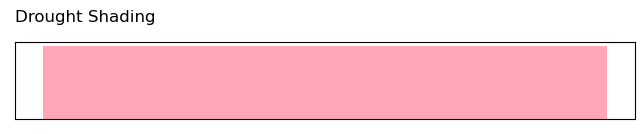

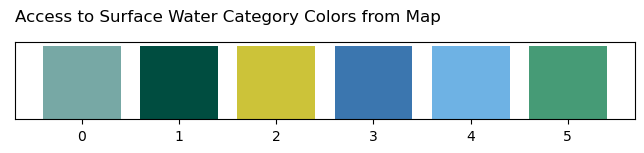

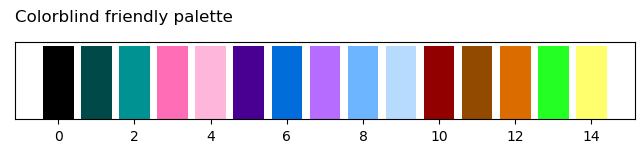

In [51]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

# Custom palette (adjust colors if needed)
custom_palette = {
    "0-100m": "#440154",  # Deep purple
    "0-500m": "#3b528b",  # Blue
    "0-1000m": "#21918c",  # Teal
    "0-1500m": "#5ec962",  # Green
    "0-2000m": "#fde725",  # Yellow
    ">2000m": "#fca636"  # Orange
}

In [3]:
# Put your huc number here
huc_num = '8'

# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""

In [78]:
filename = f"{StudyArea}_mShallowGWWellCountSummary.csv"
filepath = os.path.join(outputpath, filename)
boundaries_stats = pd.read_csv(filepath)
# boundaries_stats = boundaries_stats.rename(columns={"huc4_wb":"huc4"})
boundaries_stats = boundaries_stats.drop(['Unnamed: 0'], axis=1)
boundaries_stats

Decade      huc8         DTW_Category  Well Count
0       1980  15010001   Near Surface (<2m)           2
1       1980  15010002   Near Surface (<2m)           3
2       1980  15010003        Deep (10-61m)           4
3       1980  15010003   Near Surface (<2m)          17
4       1980  15010003      Shallow (5-10m)           2
...      ...       ...                  ...         ...
1046    2020  15080301      Shallow (5-10m)           7
1047    2020  15080301  Very Shallow (2-5m)           3
1048    2020  15080302        Deep (10-61m)           1
1049    2020  15080302      Shallow (5-10m)           5
1050    2020  15080302  Very Shallow (2-5m)           2

[1051 rows x 4 columns]

In [5]:
filename = f"{StudyArea}_mMeltedDataframe.csv"
filepath = os.path.join(outputpath, filename)
boundaries_melted = pd.read_csv(filepath)
# boundaries_melted = boundaries_melted.rename(columns={"huc4_wb":"huc4"})
boundaries_melted = boundaries_melted.drop(['Unnamed: 0'], axis=1)
boundaries_melted

Combo_ID      huc8        Date    DTW  DTW_meters         DTW_Category  \
0        521955  15010001  1988-09-01    0.0     0.00000   Near Surface (<2m)   
1        521956  15010001  1988-09-01    0.0     0.00000   Near Surface (<2m)   
2        526708  15010001  1990-01-01    0.0     0.00000   Near Surface (<2m)   
3        526707  15010001  1990-02-01    0.0     0.00000   Near Surface (<2m)   
4        528959  15010001  1991-06-01  105.0    32.00400        Deep (10-61m)   
...         ...       ...         ...    ...         ...                  ...   
71832    552204  15080302  2020-11-01    9.9     3.01752  Very Shallow (2-5m)   
71833    616444  15080302  2020-11-01   31.5     9.60120      Shallow (5-10m)   
71834    616444  15080302  2021-11-01   29.9     9.11352      Shallow (5-10m)   
71835    616444  15080302  2022-11-01   29.0     8.83920      Shallow (5-10m)   
71836    616444  15080302  2023-11-01   31.7     9.66216      Shallow (5-10m)   

       Decade  
0        1980  
1        1980  
2        1990  
3        1990  
4        1990  
...       ...  
71832    2020  
71833    2020  
71834    2020  
71835    2020  
71836    2020  

[71837 rows x 7 columns]

In [6]:
individualwells = pd.pivot_table(boundaries_melted, index=["Combo_ID"], columns=["Decade"], values=["DTW_meters"], dropna=False, aggfunc=np.median)
individualwells

DTW_meters                                    
Decade                1980       1990     2000     2010   2020
Combo_ID                                                      
83578               3.6576        NaN      NaN      NaN    NaN
84067               0.0000        NaN      NaN      NaN    NaN
84614               3.6576        NaN      NaN      NaN    NaN
84630               5.4864        NaN      NaN      NaN    NaN
84633               5.4864        NaN      NaN      NaN    NaN
...                    ...        ...      ...      ...    ...
363620113565501     2.5908   2.865120  2.86512  2.22504  3.048
364710114033401        NaN  45.201840      NaN      NaN    NaN
364825114052801        NaN  11.612880      NaN      NaN    NaN
365429113555301        NaN  19.242024      NaN      NaN    NaN
365432113560501        NaN  17.526000      NaN      NaN    NaN

[43783 rows x 5 columns]

In [7]:
individualwells.reset_index(inplace=True)

In [8]:
# individualwells.to_csv(outputpath+"/MedianWL_Decades_IndividualWells.csv")

In [73]:
distances = [100, 
             500, 
             1000, 
             1500, 
             2000
             ]

stats_distances = {}

for i in distances:
    # filename = f"HUC4s_{i}_ShallowGWWellCountSummary.csv"
    filename = f'{StudyArea}_{i}mShallowGWWellCountSummary.csv'
    filepath = os.path.join(outputpath, filename)
    stats_distances[f"{i}m"] = pd.read_csv(filepath)
    stats_distances[f"{i}m"] = stats_distances[f"{i}m"].drop(['Unnamed: 0'], axis=1)

In [10]:
distances = [100, 
             500, 
             1000, 
             1500, 
             2000
             ]

melted_distances = {}

for i in distances:
    # filename = f"HUC4s_{i}_ShallowGWWellCountSummary.csv"
    filename = f'{StudyArea}_{i}mMeltedDataframe.csv'
    filepath = os.path.join(outputpath, filename)
    melted_distances[f"{i}m"] = pd.read_csv(filepath)
    melted_distances[f"{i}m"] = melted_distances[f"{i}m"].drop(['Unnamed: 0'], axis=1)

In [53]:
wells_to_remove = set(melted_distances['2000m']['Combo_ID'])
melted_distances['>2000m'] = boundaries_melted[~boundaries_melted['Combo_ID'].isin(wells_to_remove)]
melted_distances['>2000m']

Combo_ID      huc8        Date    DTW  DTW_meters  \
7               517813  15010002  1987-05-01    0.0     0.00000   
8               518224  15010002  1987-10-01    0.0     0.00000   
10              533440  15010002  1991-11-01    0.0     0.00000   
11              221906  15010002  2013-04-01   32.0     9.75360   
14              641939  15010003  1980-04-01   60.0    18.28800   
...                ...       ...         ...    ...         ...   
71673           233075  15080301  2021-04-01  108.0    32.91840   
71683  312154109394401  15080301  2022-11-01  155.3    47.33544   
71712           630131  15080302  1987-02-01   11.8     3.59664   
71748           630131  15080302  1990-12-01   18.1     5.51688   
71798           630131  15080302  2007-03-01   27.3     8.32104   

              DTW_Category  Decade  
7       Near Surface (<2m)    1980  
8       Near Surface (<2m)    1980  
10      Near Surface (<2m)    1990  
11         Shallow (5-10m)    2010  
14           Deep (10-61m)    1980  
...                    ...     ...  
71673        Deep (10-61m)    2020  
71683        Deep (10-61m)    2020  
71712  Very Shallow (2-5m)    1980  
71748      Shallow (5-10m)    1990  
71798      Shallow (5-10m)    2000  

[17979 rows x 7 columns]

In [54]:
# Assign Distance categories
# Assign categories before merging
melted_distances['100m']["Distance_to_Stream"] = "0-100m"
melted_distances['500m']["Distance_to_Stream"] = "0-500m"
melted_distances['1000m']["Distance_to_Stream"] = "0-1000m"
melted_distances['1500m']["Distance_to_Stream"] = "0-1500m"
melted_distances['2000m']["Distance_to_Stream"] = "0-2000m"
melted_distances['>2000m']["Distance_to_Stream"] = ">2000m"  # Default category

melted_distances['1500m']

C:\Users\det19\AppData\Local\Temp\ipykernel_23096\2804974720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_distances['>2000m']["Distance_to_Stream"] = ">2000m"  # Default category


Combo_ID      huc8        Date   DTW  DTW_meters         DTW_Category  \
0        521955  15010001  1988-09-01   0.0     0.00000   Near Surface (<2m)   
1        521956  15010001  1988-09-01   0.0     0.00000   Near Surface (<2m)   
2        526708  15010001  1990-01-01   0.0     0.00000   Near Surface (<2m)   
3        526707  15010001  1990-02-01   0.0     0.00000   Near Surface (<2m)   
4        921252  15010001  2018-04-01  28.0     8.53440      Shallow (5-10m)   
...         ...       ...         ...   ...         ...                  ...   
49321    552204  15080302  2020-11-01   9.9     3.01752  Very Shallow (2-5m)   
49322    616444  15080302  2020-11-01  31.5     9.60120      Shallow (5-10m)   
49323    616444  15080302  2021-11-01  29.9     9.11352      Shallow (5-10m)   
49324    616444  15080302  2022-11-01  29.0     8.83920      Shallow (5-10m)   
49325    616444  15080302  2023-11-01  31.7     9.66216      Shallow (5-10m)   

       Decade Distance_to_Stream  
0        1980            0-1500m  
1        1980            0-1500m  
2        1990            0-1500m  
3        1990            0-1500m  
4        2010            0-1500m  
...       ...                ...  
49321    2020            0-1500m  
49322    2020            0-1500m  
49323    2020            0-1500m  
49324    2020            0-1500m  
49325    2020            0-1500m  

[49326 rows x 8 columns]

In [56]:
near_100m = melted_distances['100m'].copy()
near_500m = melted_distances['500m'].copy()
near_1000m = melted_distances['1000m'].copy()
near_1500m = melted_distances['1500m'].copy()
near_2000m = melted_distances['2000m'].copy()
away = melted_distances[">2000m"].copy()

# Merge all datasets (now they all have Distance_to_Stream labels)
final_df = pd.concat([near_100m, near_500m, near_1000m, near_1500m, near_2000m, away])
final_df

Combo_ID      huc8        Date    DTW  DTW_meters  \
0               921252  15010001  2018-04-01   28.0     8.53440   
1               921254  15010001  2018-04-01   28.0     8.53440   
2               521579  15010003  1988-08-01    0.0     0.00000   
3               526741  15010003  1990-06-01   33.0    10.05840   
4               919879  15010003  2016-09-01   30.0     9.14400   
...                ...       ...         ...    ...         ...   
71673           233075  15080301  2021-04-01  108.0    32.91840   
71683  312154109394401  15080301  2022-11-01  155.3    47.33544   
71712           630131  15080302  1987-02-01   11.8     3.59664   
71748           630131  15080302  1990-12-01   18.1     5.51688   
71798           630131  15080302  2007-03-01   27.3     8.32104   

              DTW_Category  Decade Distance_to_Stream  
0          Shallow (5-10m)    2010             0-100m  
1          Shallow (5-10m)    2010             0-100m  
2       Near Surface (<2m)    1980             0-100m  
3            Deep (10-61m)    1990             0-100m  
4          Shallow (5-10m)    2010             0-100m  
...                    ...     ...                ...  
71673        Deep (10-61m)    2020             >2000m  
71683        Deep (10-61m)    2020             >2000m  
71712  Very Shallow (2-5m)    1980             >2000m  
71748      Shallow (5-10m)    1990             >2000m  
71798      Shallow (5-10m)    2000             >2000m  

[206306 rows x 8 columns]

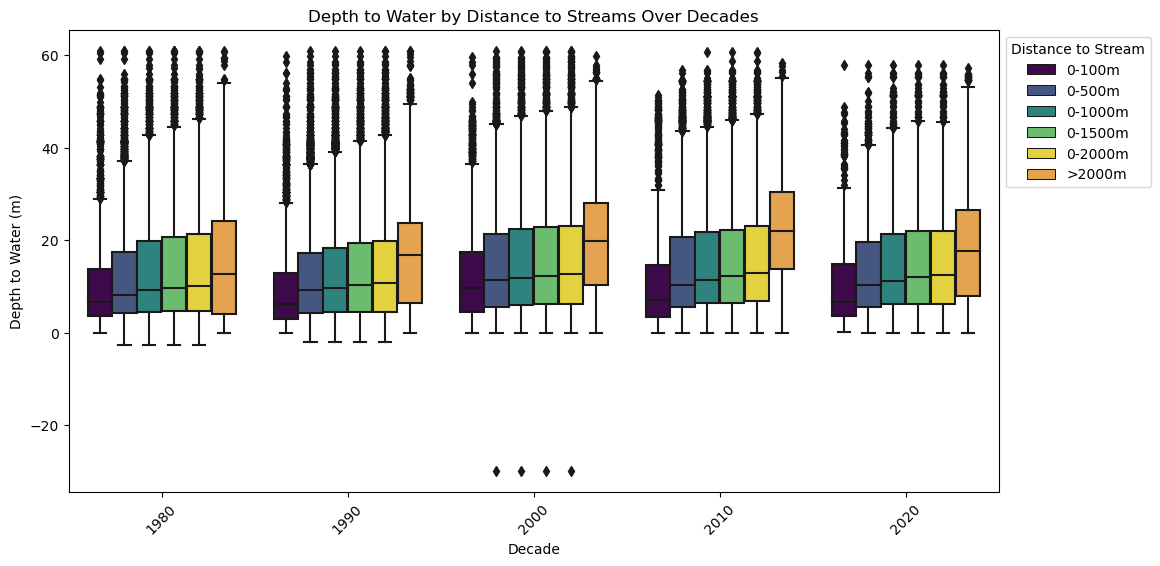

In [57]:
# Custom palette (adjust colors if needed)
custom_palette = {
    "0-100m": "#440154",  # Deep purple
    "0-500m": "#3b528b",  # Blue
    "0-1000m": "#21918c",  # Teal
    "0-1500m": "#5ec962",  # Green
    "0-2000m": "#fde725",  # Yellow
    ">2000m": "#fca636"  # Orange
}

plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df, x="Decade", y="DTW_meters", hue="Distance_to_Stream", palette=custom_palette)

plt.title("Depth to Water by Distance to Streams Over Decades")
plt.xlabel("Decade")
plt.ylabel("Depth to Water (m)")
plt.legend(title="Distance to Stream", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

In [58]:
melted_distances

{'100m':        Combo_ID      huc8        Date   DTW  DTW_meters        DTW_Category  \
 0        921252  15010001  2018-04-01  28.0     8.53440     Shallow (5-10m)   
 1        921254  15010001  2018-04-01  28.0     8.53440     Shallow (5-10m)   
 2        521579  15010003  1988-08-01   0.0     0.00000  Near Surface (<2m)   
 3        526741  15010003  1990-06-01  33.0    10.05840       Deep (10-61m)   
 4        919879  15010003  2016-09-01  30.0     9.14400     Shallow (5-10m)   
 ...         ...       ...         ...   ...         ...                 ...   
 10099    212327  15080302  2020-11-01  20.0     6.09600     Shallow (5-10m)   
 10100    616444  15080302  2020-11-01  31.5     9.60120     Shallow (5-10m)   
 10101    616444  15080302  2021-11-01  29.9     9.11352     Shallow (5-10m)   
 10102    616444  15080302  2022-11-01  29.0     8.83920     Shallow (5-10m)   
 10103    616444  15080302  2023-11-01  31.7     9.66216     Shallow (5-10m)   
 
        Decade Distance_to_Str

In [63]:
melted_distances.keys()

dict_keys(['100m', '500m', '1000m', '1500m', '2000m', 'Away from Streams', '>2000m'])

In [64]:
melted_distances_modified = {}
melted_distances_modified['0-100m'] = near_100m.copy()

# 100-500m: Remove wells already in 500m
wells_to_remove = set(melted_distances['100m']['Combo_ID'])
melted_distances_modified['100-500m'] = melted_distances['500m'][~melted_distances['500m']['Combo_ID'].isin(wells_to_remove)]

# 500-1000m: Remove wells already in 500m
wells_to_remove = set(melted_distances['500m']['Combo_ID'])
melted_distances_modified['500-1000m'] = melted_distances['1000m'][~melted_distances['1000m']['Combo_ID'].isin(wells_to_remove)]

# 1000-1500m: Remove wells already in 1000m
wells_to_remove = set(melted_distances['1000m']['Combo_ID'])
melted_distances_modified['1000-1500m'] = melted_distances['1500m'][~melted_distances['1500m']['Combo_ID'].isin(wells_to_remove)]

# 1500-2000m: Remove wells already in 1500m
wells_to_remove = set(melted_distances['1500m']['Combo_ID'])
melted_distances_modified['1500-2000m'] = melted_distances['2000m'][~melted_distances['2000m']['Combo_ID'].isin(wells_to_remove)]

# >2000m: Remove wells already in 2000m
wells_to_remove = set(melted_distances['2000m']['Combo_ID'])
melted_distances_modified['>2000m'] = boundaries_melted[~boundaries_melted['Combo_ID'].isin(wells_to_remove)]



In [61]:
# Assign Distance_to_Stream labels
distance_labels = {
    '0-100m': "0-100m",
    '100-500m': "100-500m",
    '500-1000m': "500-1000m",
    '1000-1500m': "1000-1500m",
    '1500-2000m': "1500-2000m",
    '>2000m': ">2000m"
}

for key in melted_distances_modified:
    melted_distances_modified[key]["Distance_to_Stream"] = distance_labels[key]

# Combine everything
final_df = pd.concat(melted_distances_modified.values())
final_df


C:\Users\det19\AppData\Local\Temp\ipykernel_23096\3859712955.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_distances_modified[key]["Distance_to_Stream"] = distance_labels[key]
C:\Users\det19\AppData\Local\Temp\ipykernel_23096\3859712955.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_distances_modified[key]["Distance_to_Stream"] = distance_labels[key]


Combo_ID      huc8        Date    DTW  DTW_meters  \
0               921252  15010001  2018-04-01   28.0     8.53440   
1               921254  15010001  2018-04-01   28.0     8.53440   
2               521579  15010003  1988-08-01    0.0     0.00000   
3               526741  15010003  1990-06-01   33.0    10.05840   
4               919879  15010003  2016-09-01   30.0     9.14400   
...                ...       ...         ...    ...         ...   
71673           233075  15080301  2021-04-01  108.0    32.91840   
71683  312154109394401  15080301  2022-11-01  155.3    47.33544   
71712           630131  15080302  1987-02-01   11.8     3.59664   
71748           630131  15080302  1990-12-01   18.1     5.51688   
71798           630131  15080302  2007-03-01   27.3     8.32104   

              DTW_Category  Decade Distance_to_Stream  
0          Shallow (5-10m)    2010             0-100m  
1          Shallow (5-10m)    2010             0-100m  
2       Near Surface (<2m)    1980             0-100m  
3            Deep (10-61m)    1990             0-100m  
4          Shallow (5-10m)    2010             0-100m  
...                    ...     ...                ...  
71673        Deep (10-61m)    2020             >2000m  
71683        Deep (10-61m)    2020             >2000m  
71712  Very Shallow (2-5m)    1980             >2000m  
71748      Shallow (5-10m)    1990             >2000m  
71798      Shallow (5-10m)    2000             >2000m  

[71837 rows x 8 columns]

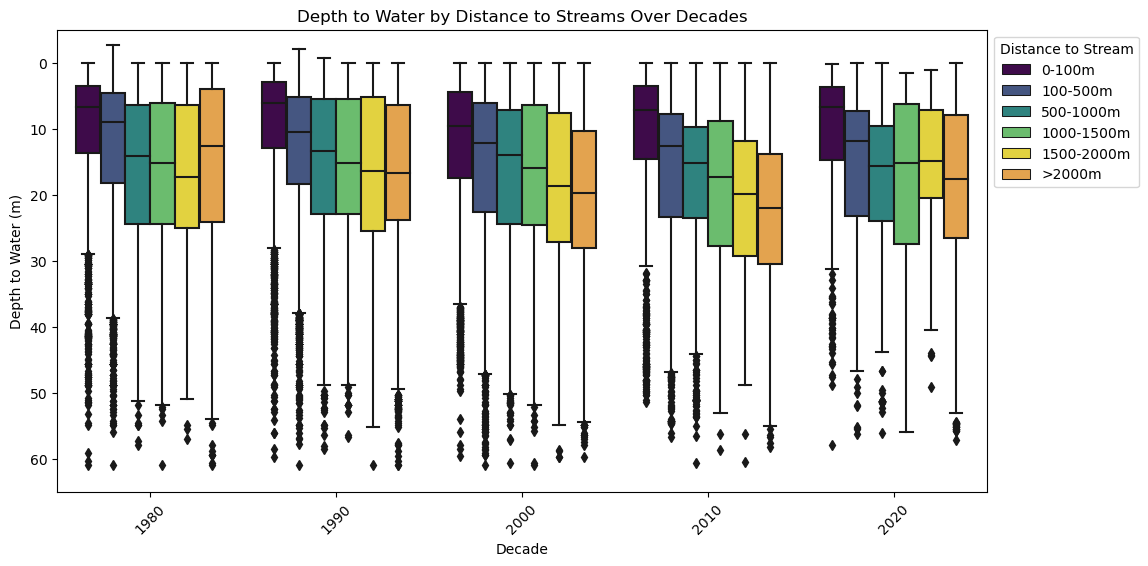

In [65]:
# Custom palette (adjust colors if needed)
custom_palette = {
    "0-100m": "#440154",  # Deep purple
    "100-500m": "#3b528b",  # Blue
    "500-1000m": "#21918c",  # Teal
    "1000-1500m": "#5ec962",  # Green
    "1500-2000m": "#fde725",  # Yellow
    ">2000m": "#fca636"  # Orange
}

plt.figure(figsize=(12, 6))
sns.boxplot(data=final_df, x="Decade", y="DTW_meters", hue="Distance_to_Stream", palette=custom_palette)

plt.ylim(65,-5)
plt.title("Depth to Water by Distance to Streams Over Decades")
plt.xlabel("Decade")
plt.ylabel("Depth to Water (m)")
plt.legend(title="Distance to Stream", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

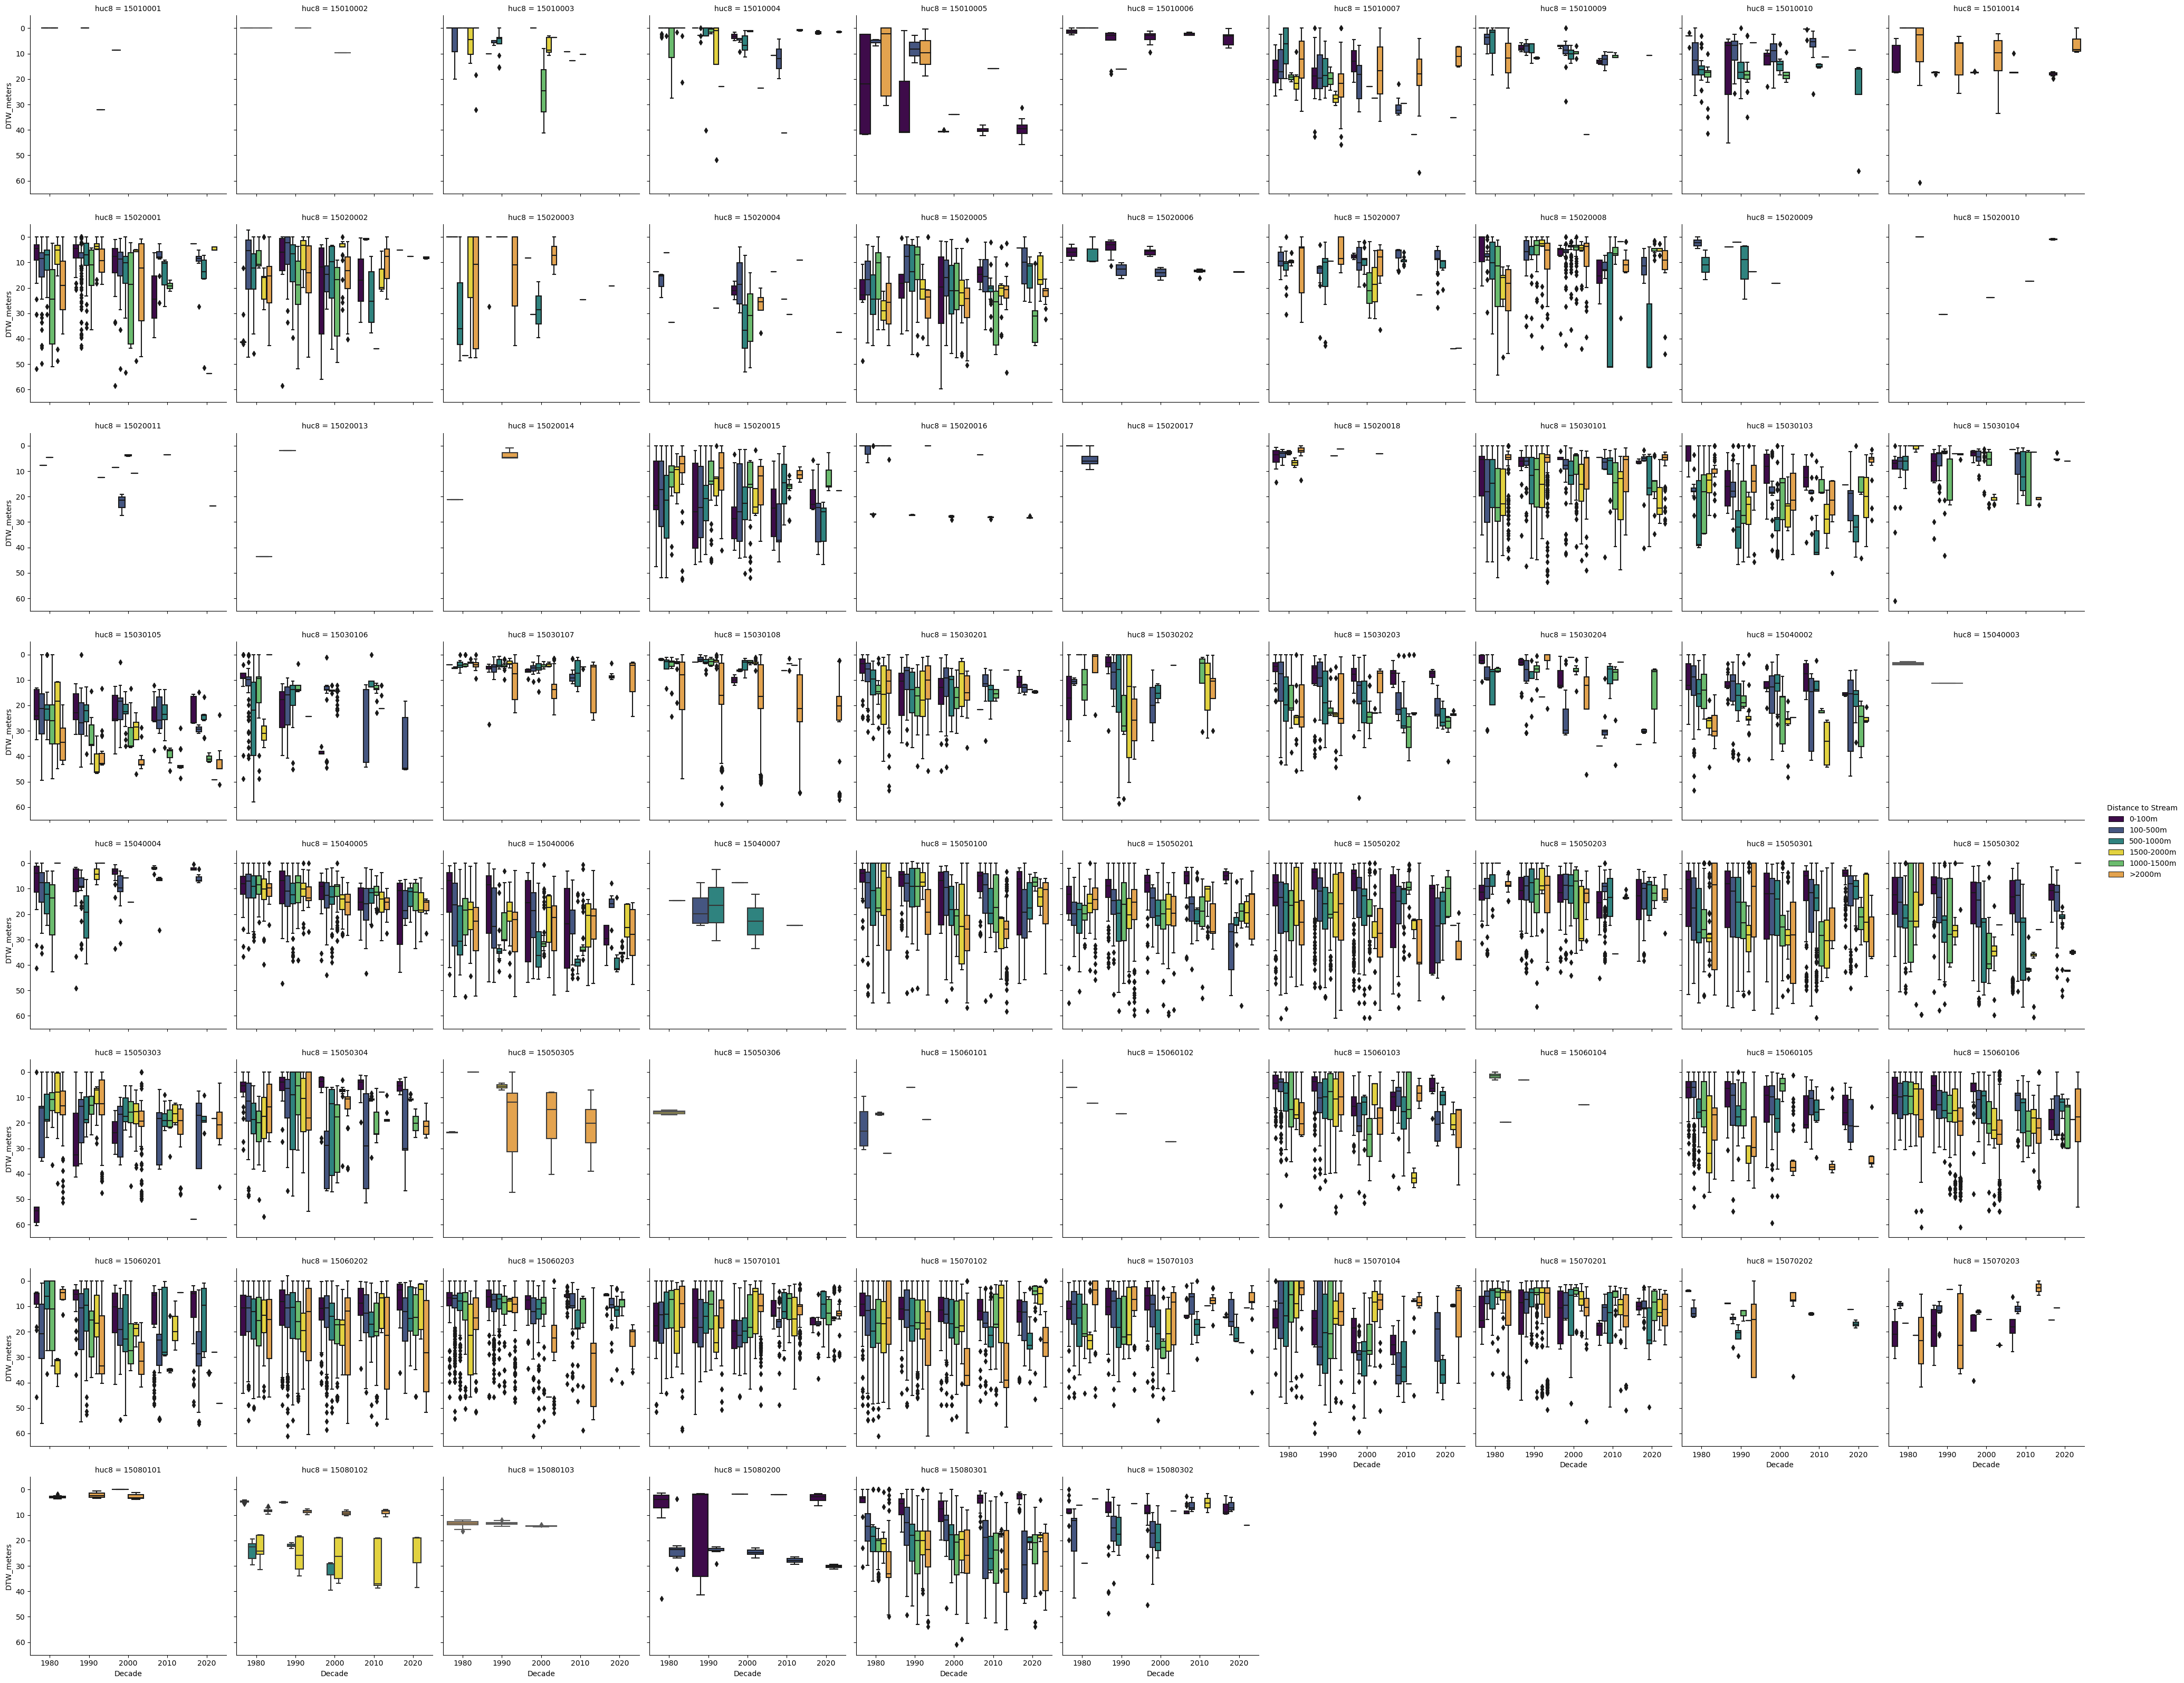

In [66]:
# Create FacetGrid to plot all HUC8s together
g = sns.FacetGrid(final_df, col=Naming_col, col_wrap=10, sharey=True, height=4,ylim=[65,-5])

g.map_dataframe(sns.boxplot, x="Decade", y="DTW_meters", hue="Distance_to_Stream", palette=custom_palette)

# Adjust the legend
g.add_legend(title="Distance to Stream")
plt.show()


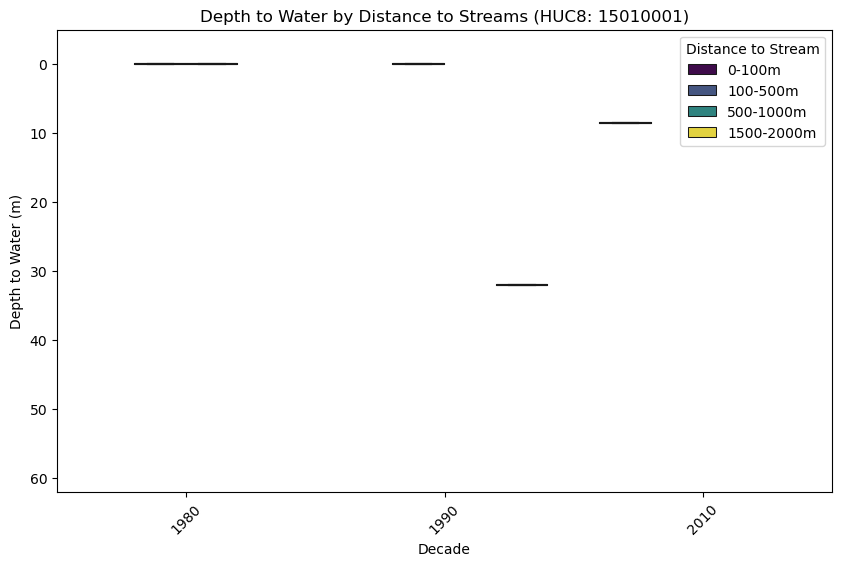

<Figure size 640x480 with 0 Axes>

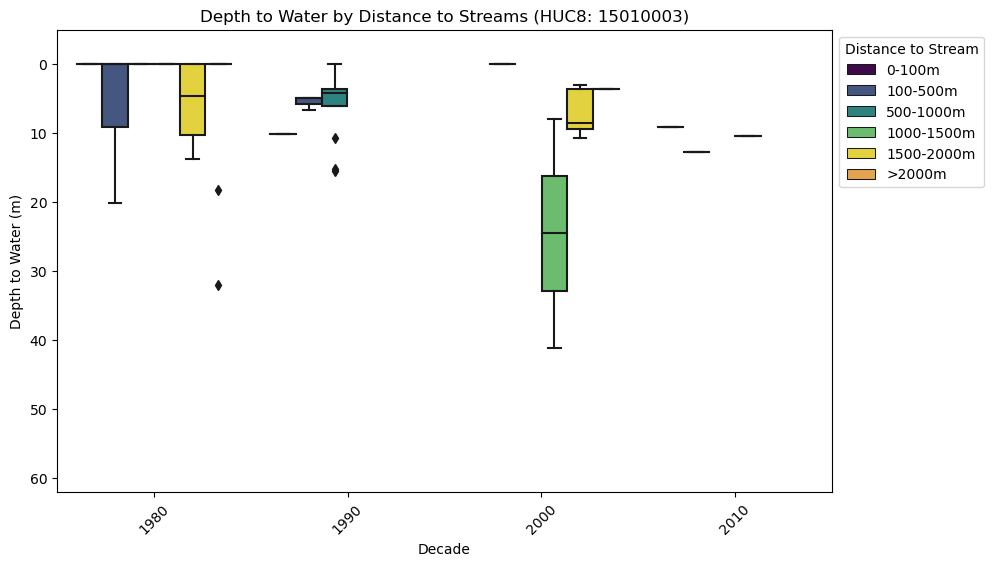

<Figure size 640x480 with 0 Axes>

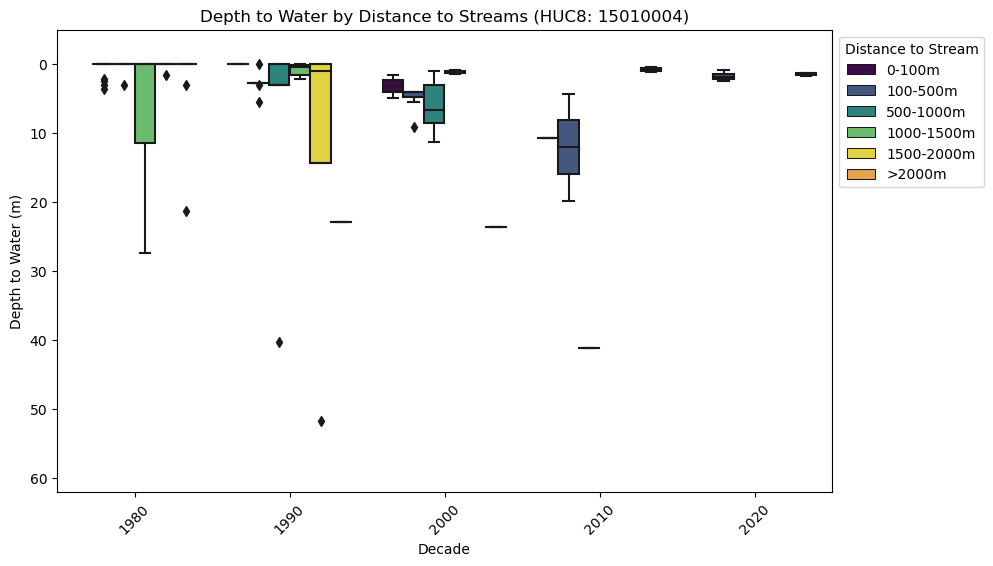

<Figure size 640x480 with 0 Axes>

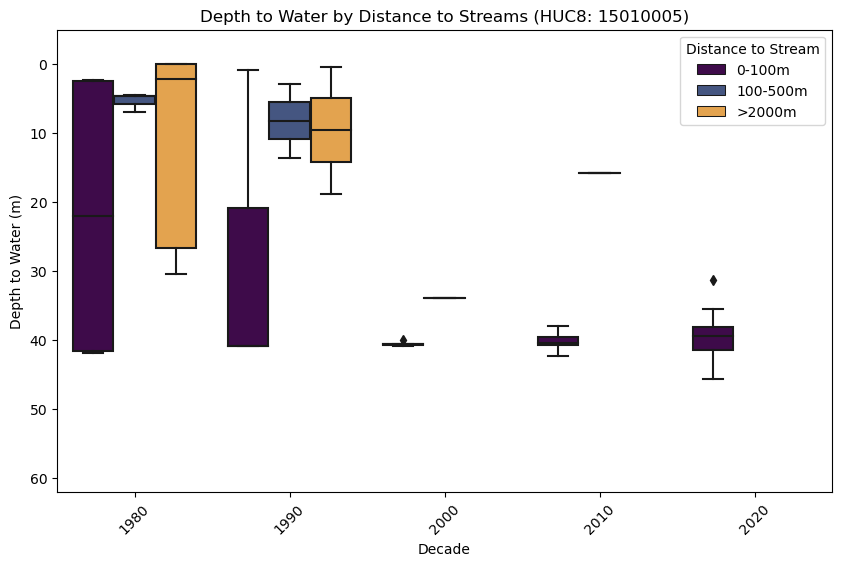

<Figure size 640x480 with 0 Axes>

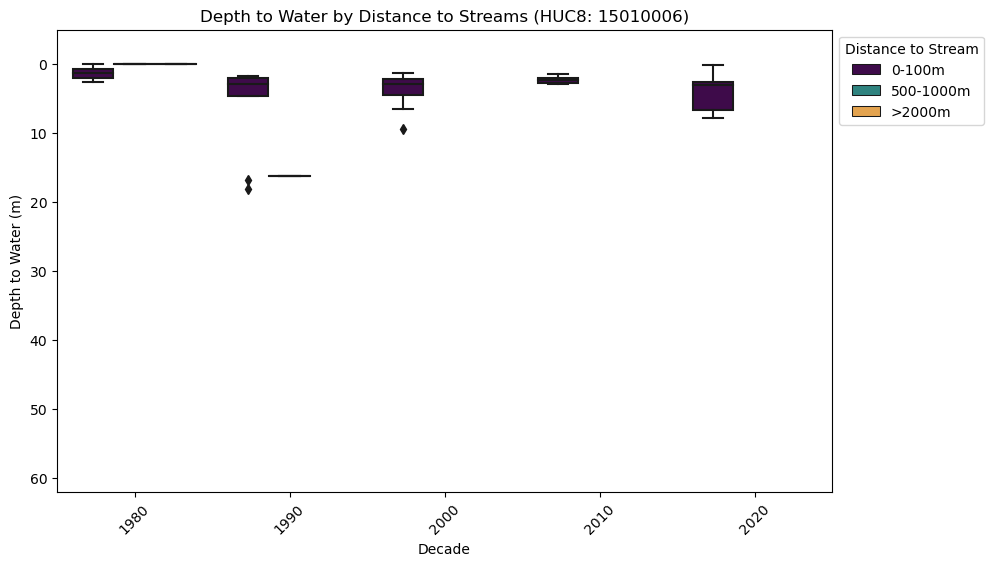

<Figure size 640x480 with 0 Axes>

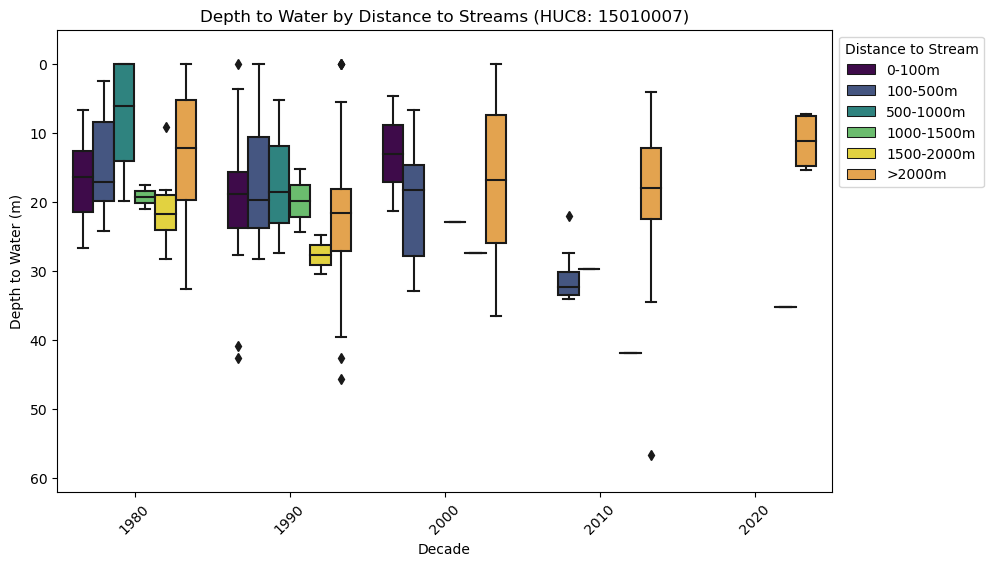

<Figure size 640x480 with 0 Axes>

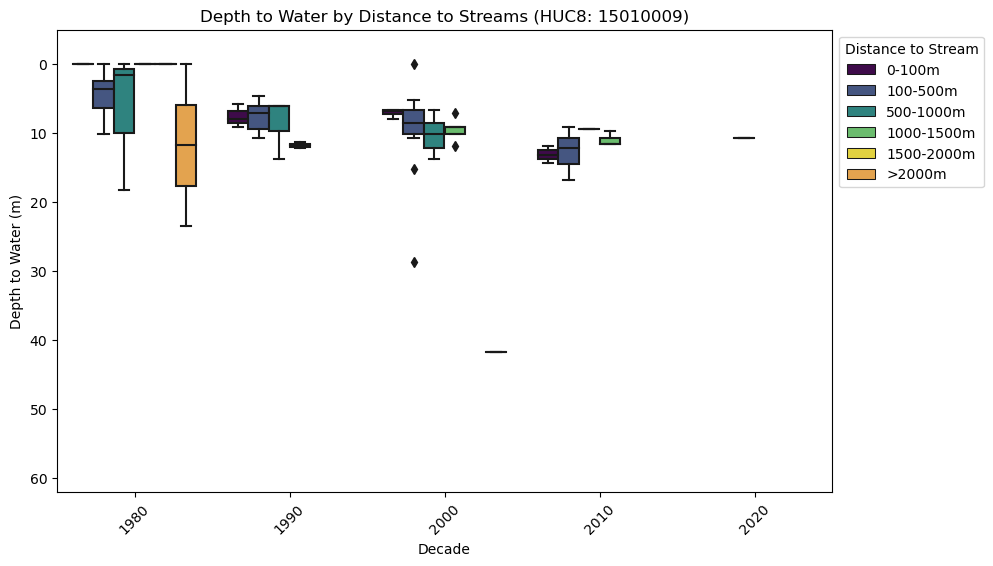

<Figure size 640x480 with 0 Axes>

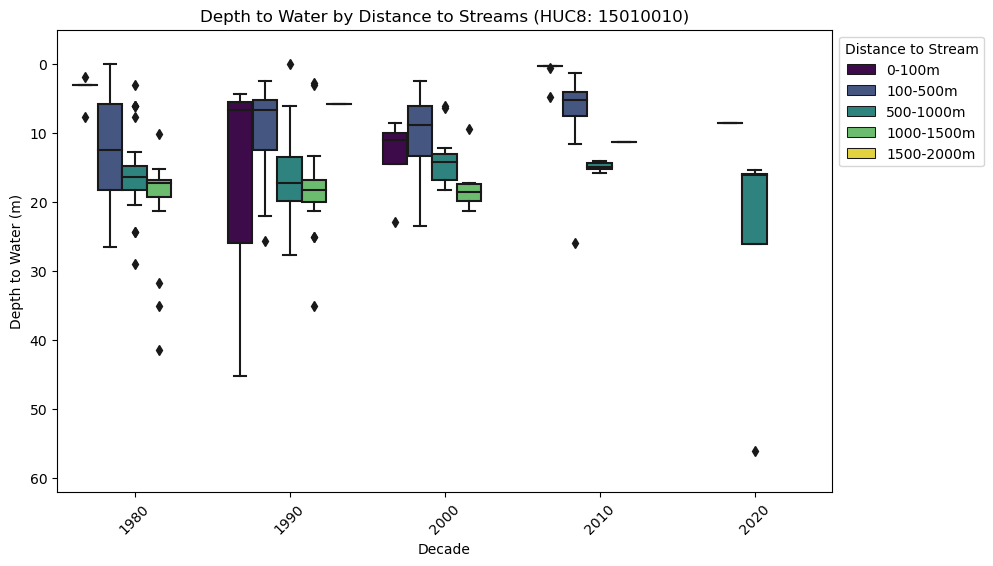

<Figure size 640x480 with 0 Axes>

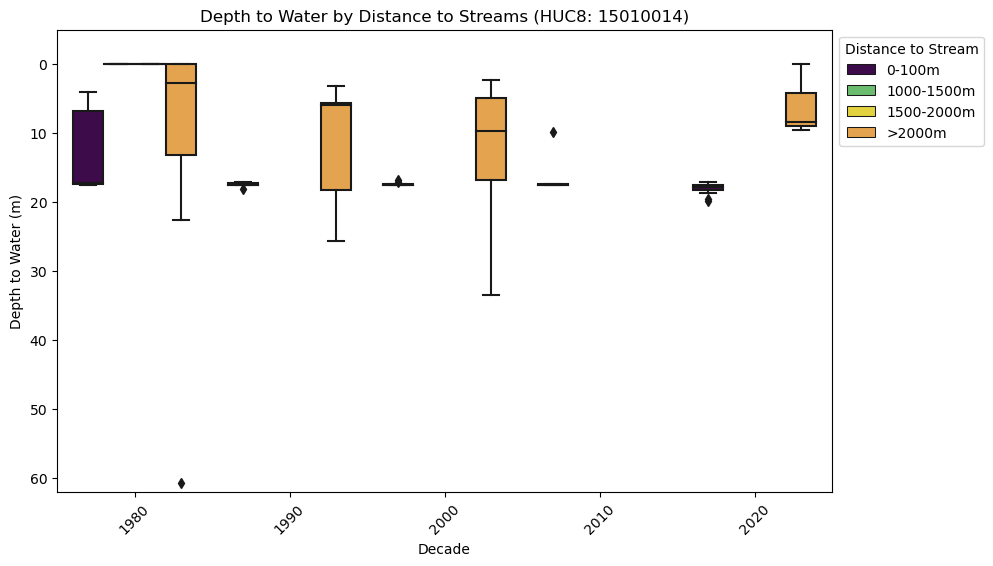

<Figure size 640x480 with 0 Axes>

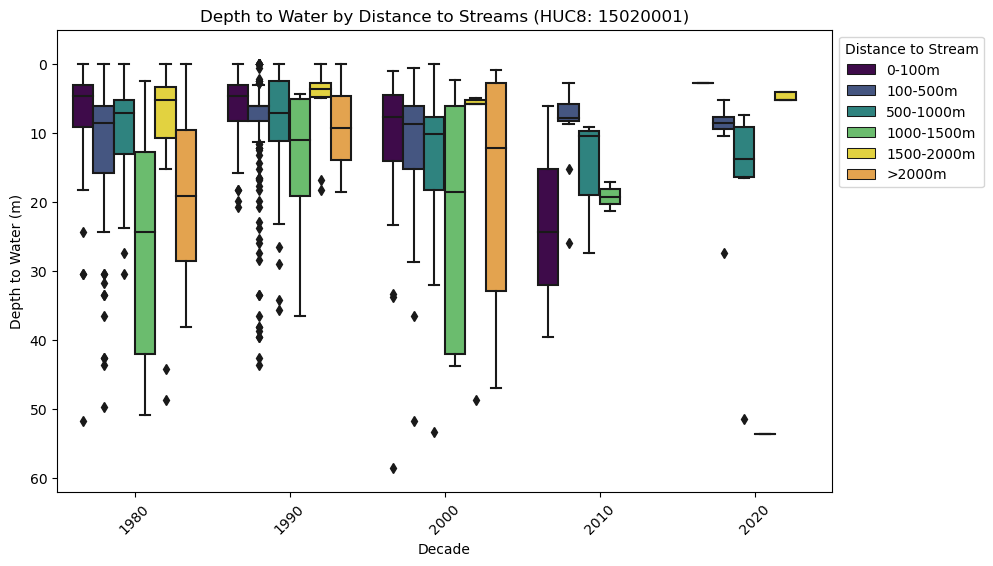

<Figure size 640x480 with 0 Axes>

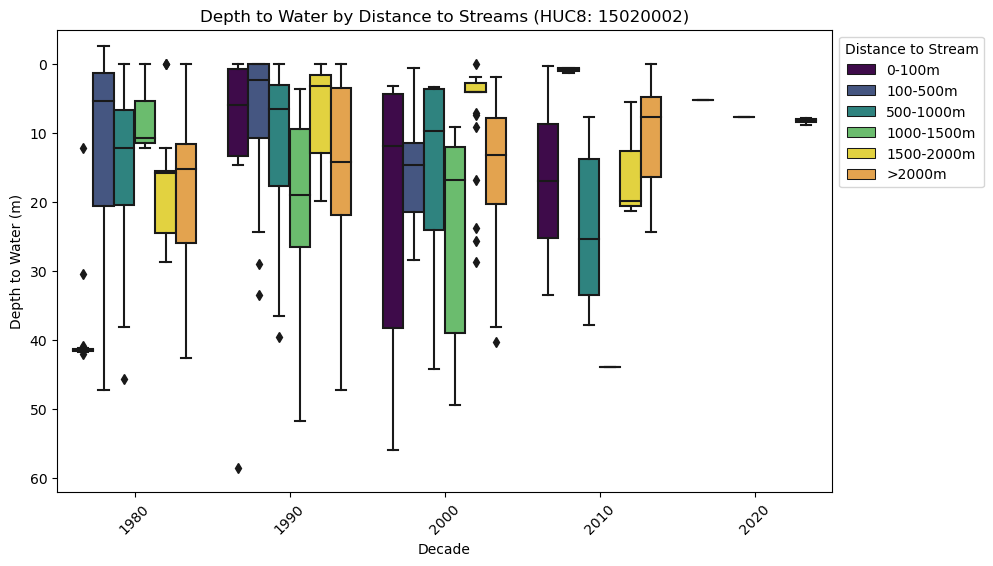

<Figure size 640x480 with 0 Axes>

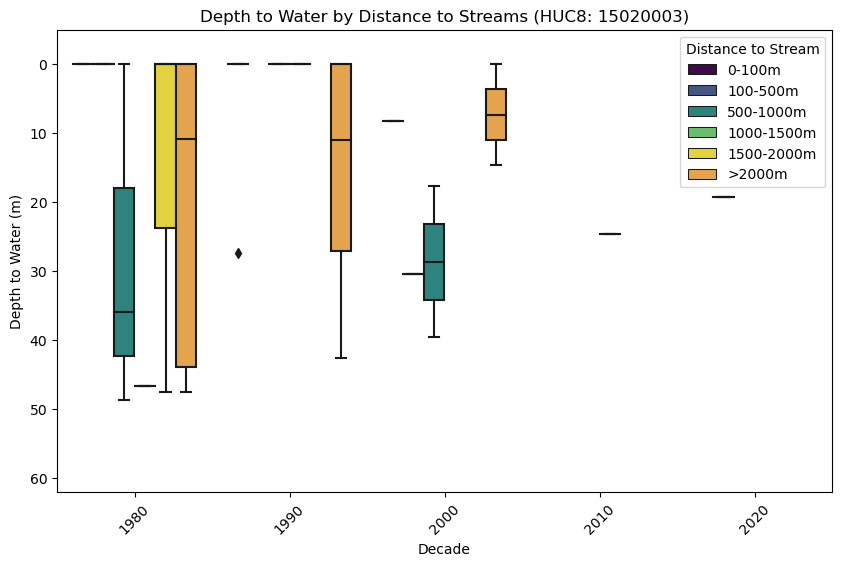

<Figure size 640x480 with 0 Axes>

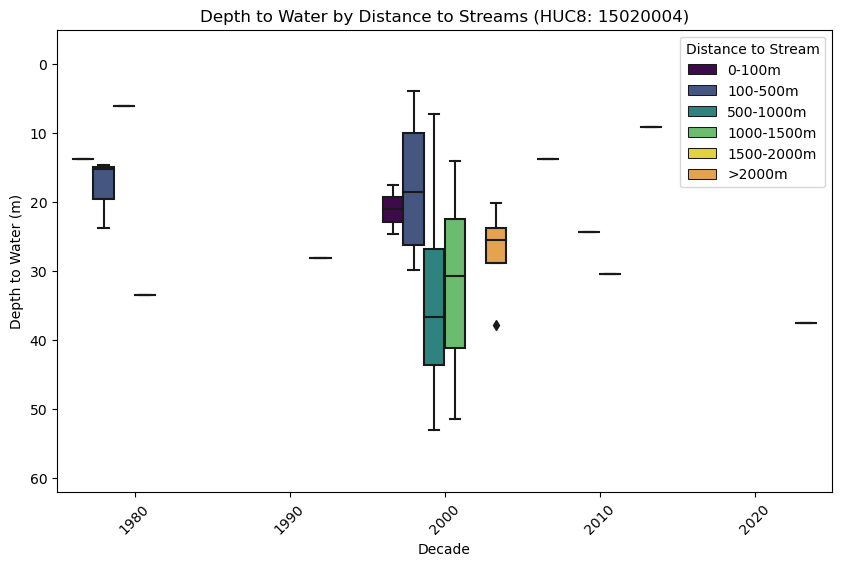

<Figure size 640x480 with 0 Axes>

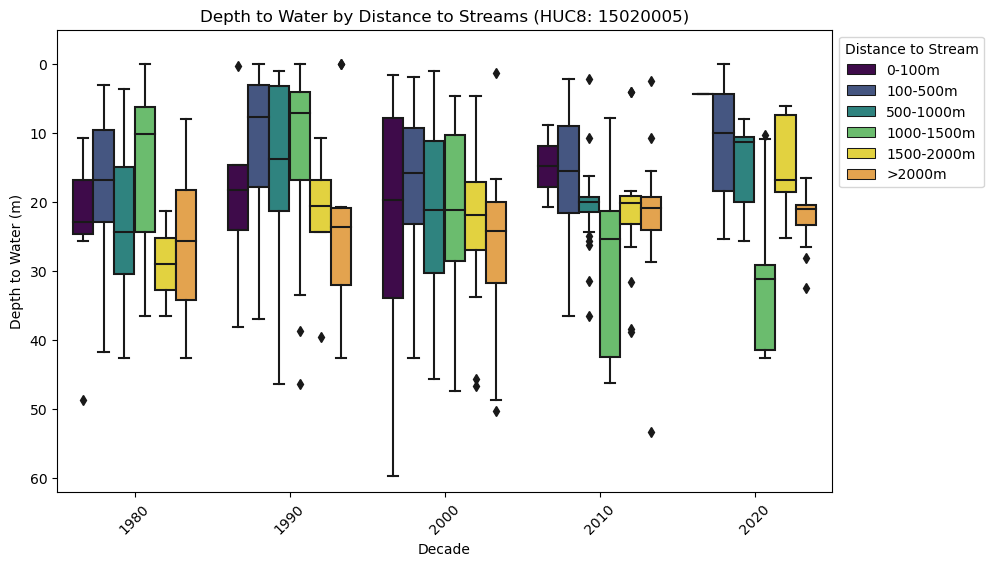

<Figure size 640x480 with 0 Axes>

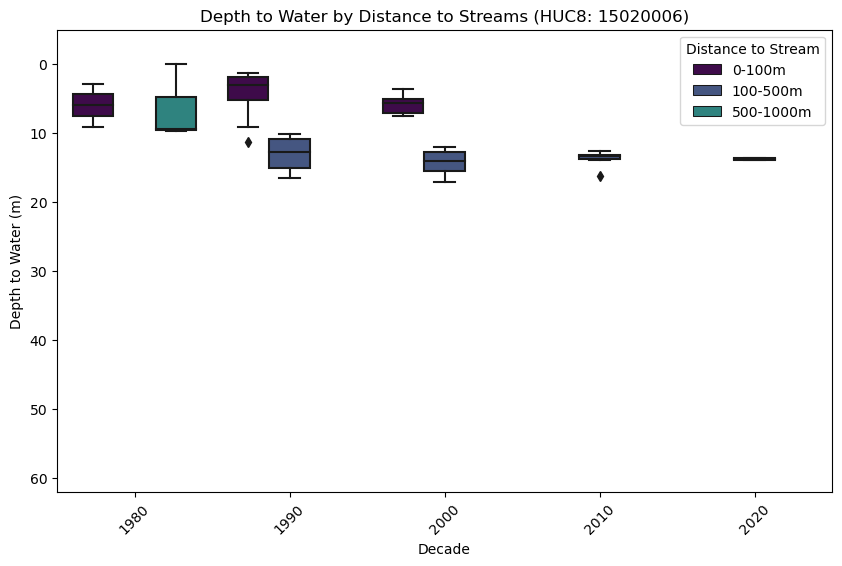

<Figure size 640x480 with 0 Axes>

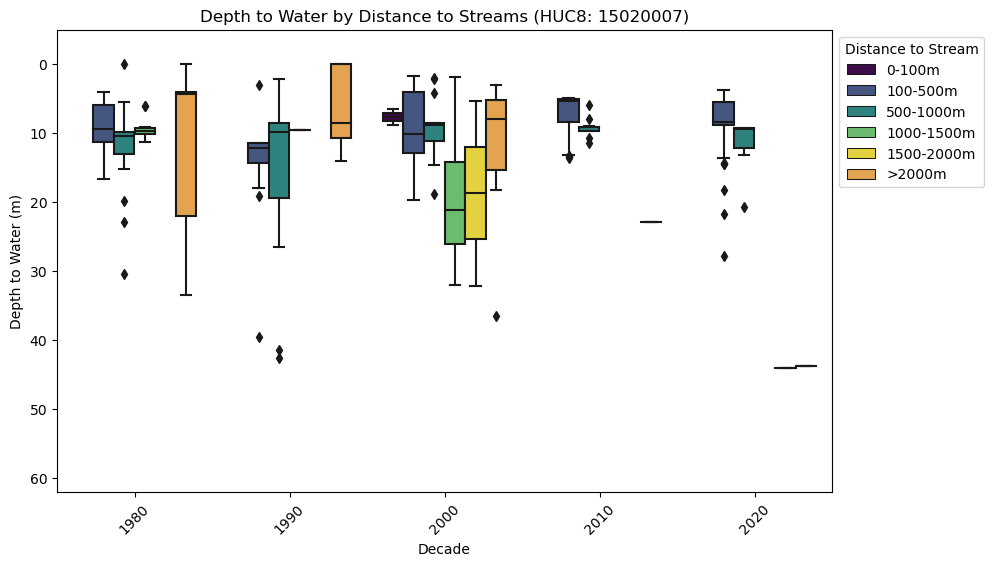

<Figure size 640x480 with 0 Axes>

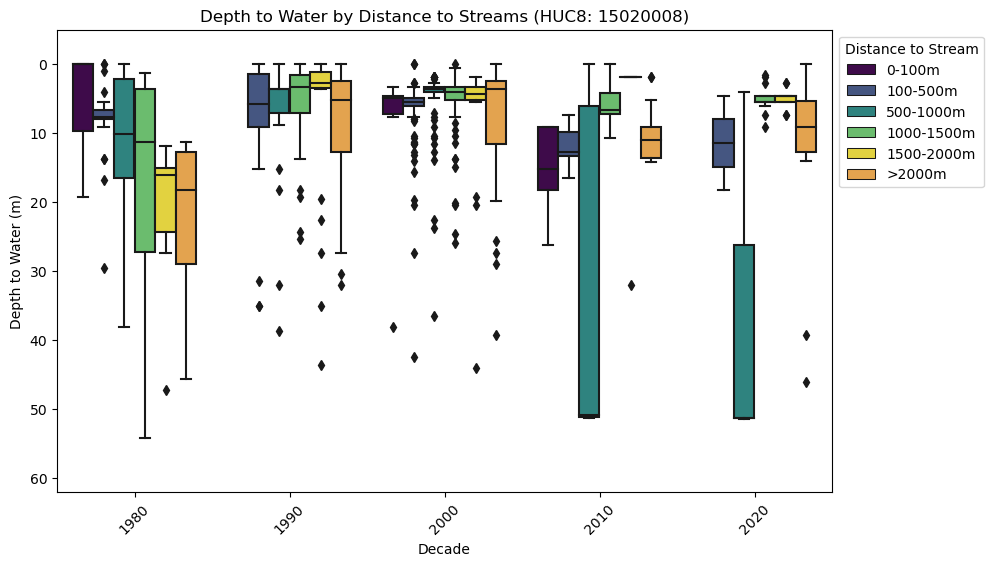

<Figure size 640x480 with 0 Axes>

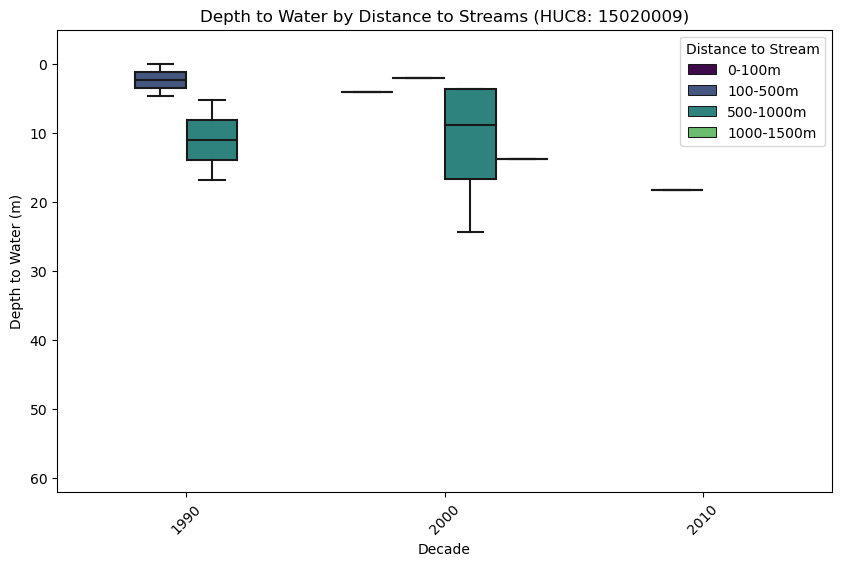

<Figure size 640x480 with 0 Axes>

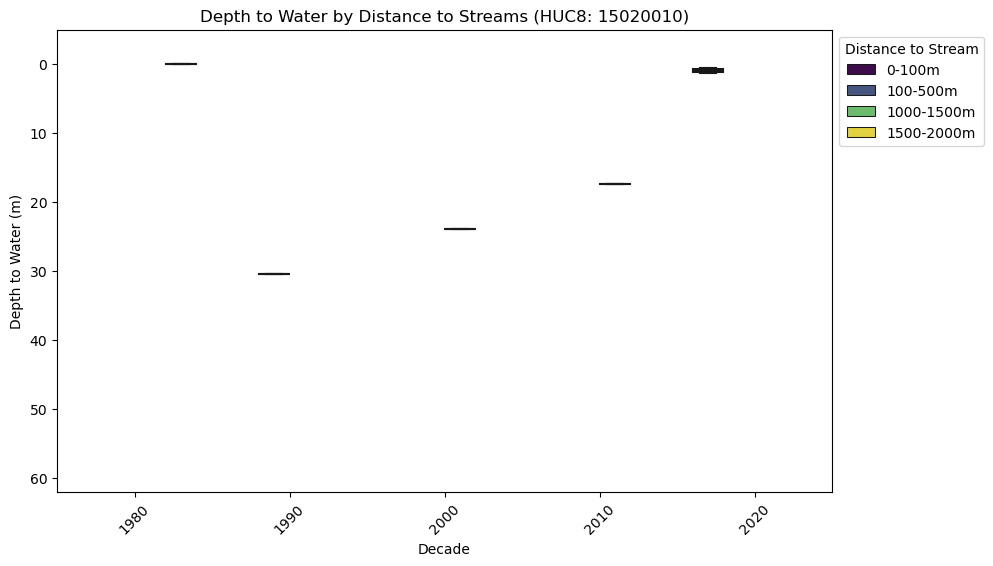

<Figure size 640x480 with 0 Axes>

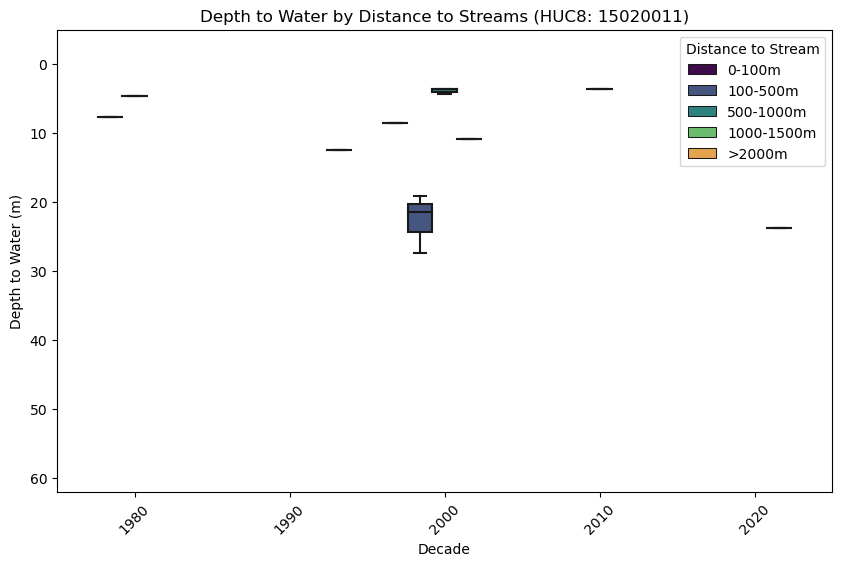

<Figure size 640x480 with 0 Axes>

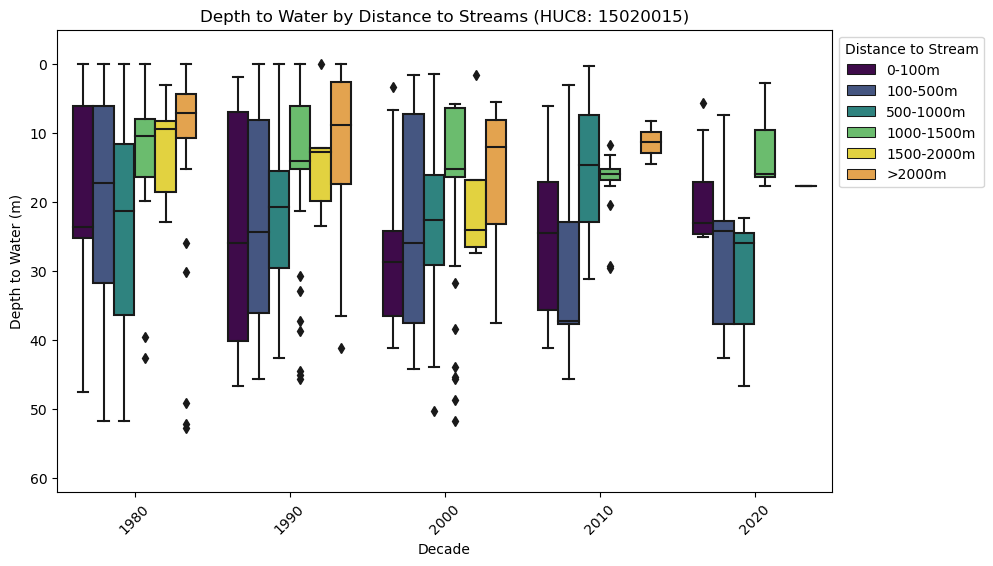

<Figure size 640x480 with 0 Axes>

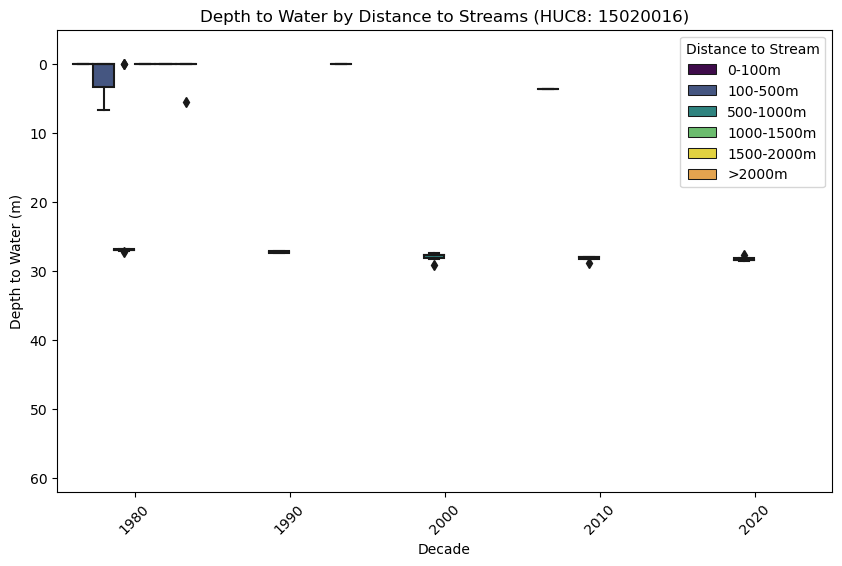

<Figure size 640x480 with 0 Axes>

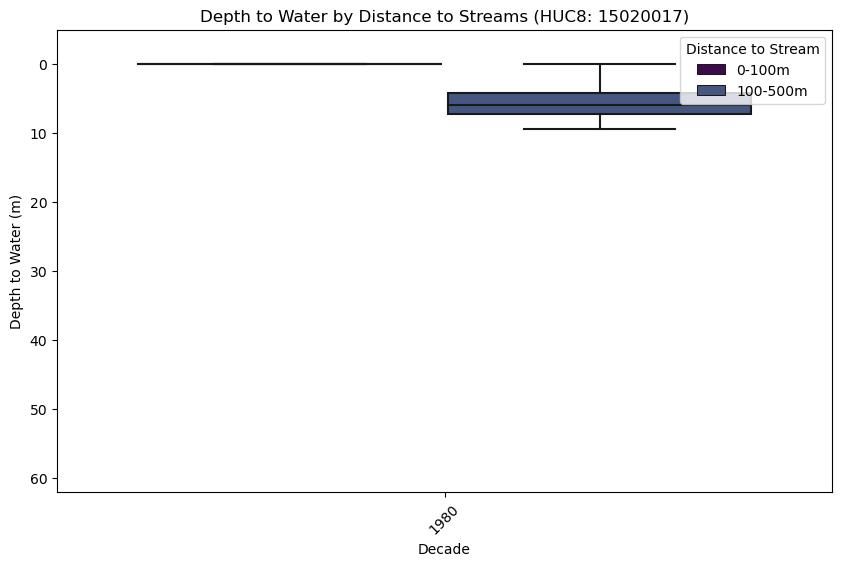

<Figure size 640x480 with 0 Axes>

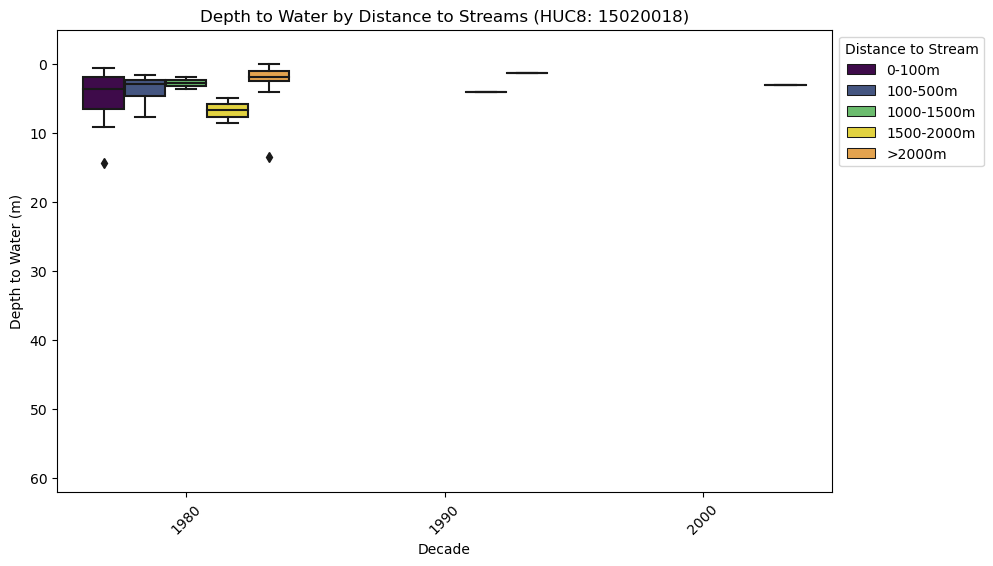

<Figure size 640x480 with 0 Axes>

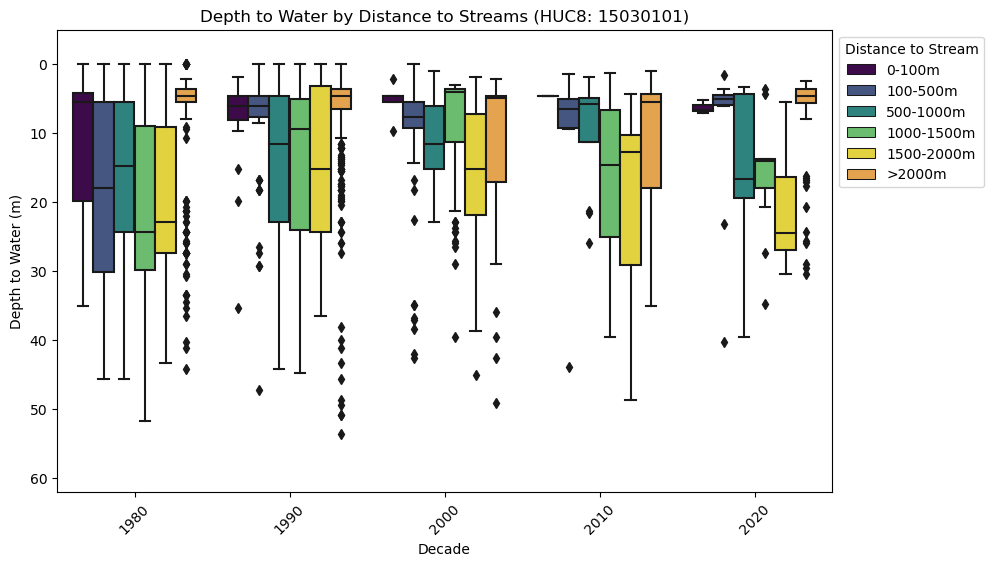

<Figure size 640x480 with 0 Axes>

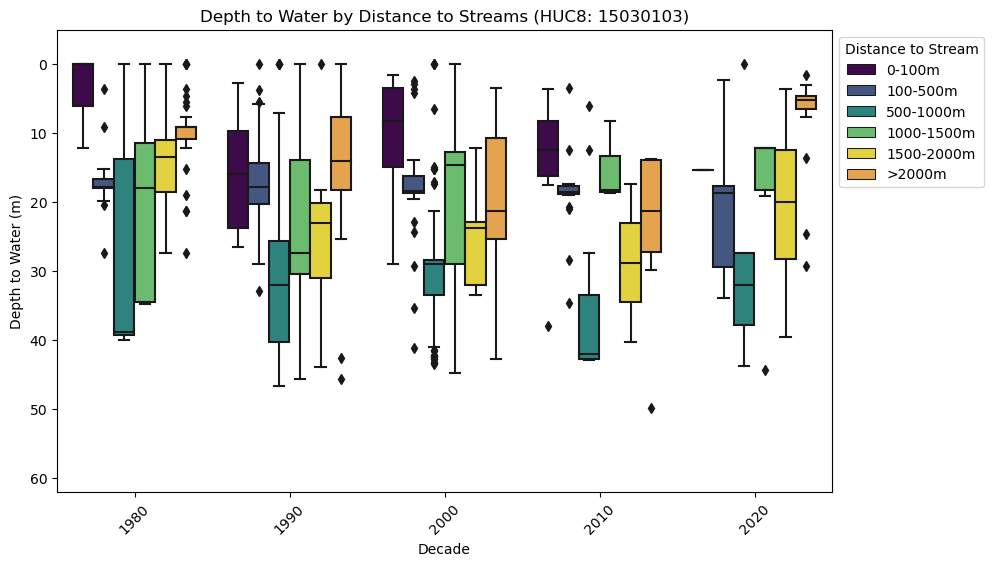

<Figure size 640x480 with 0 Axes>

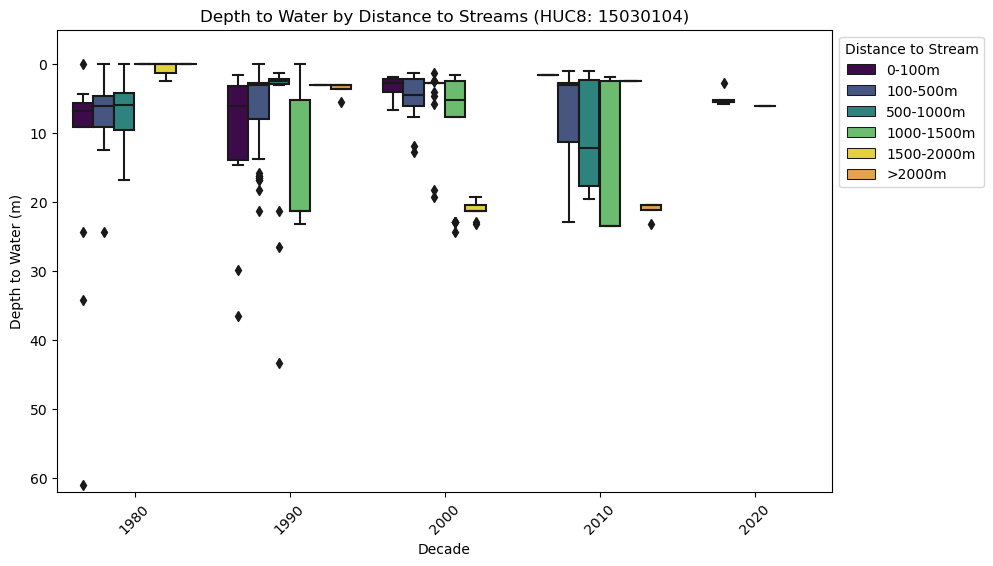

<Figure size 640x480 with 0 Axes>

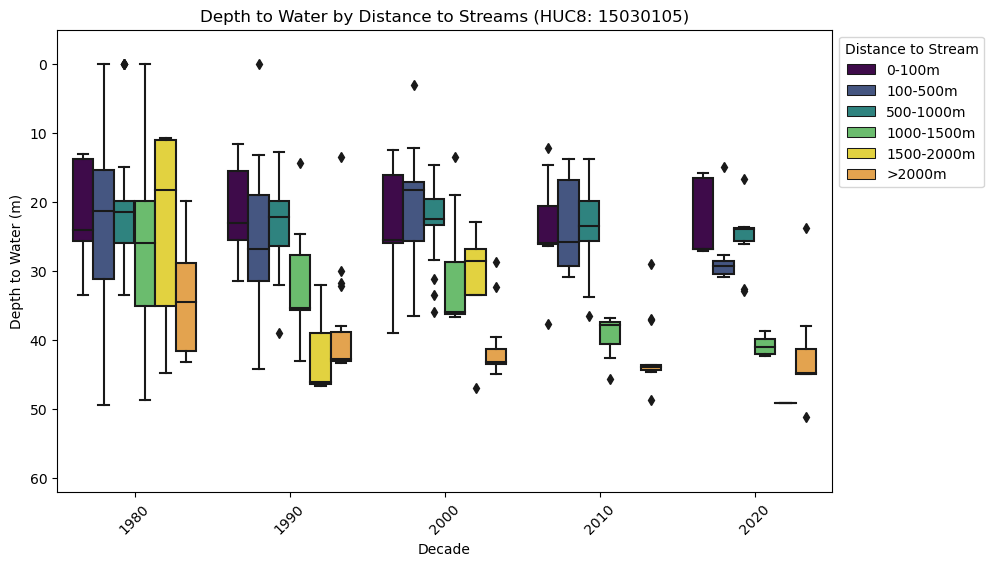

<Figure size 640x480 with 0 Axes>

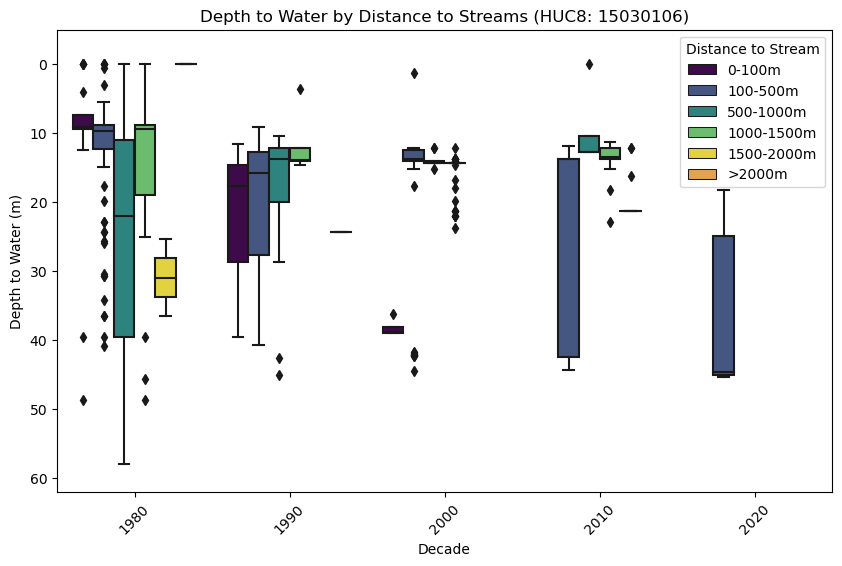

<Figure size 640x480 with 0 Axes>

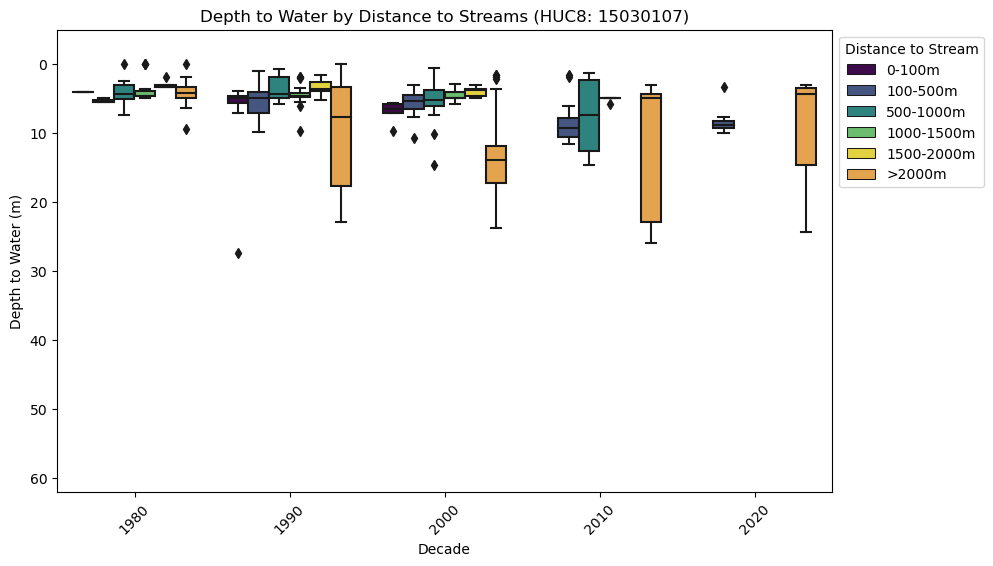

<Figure size 640x480 with 0 Axes>

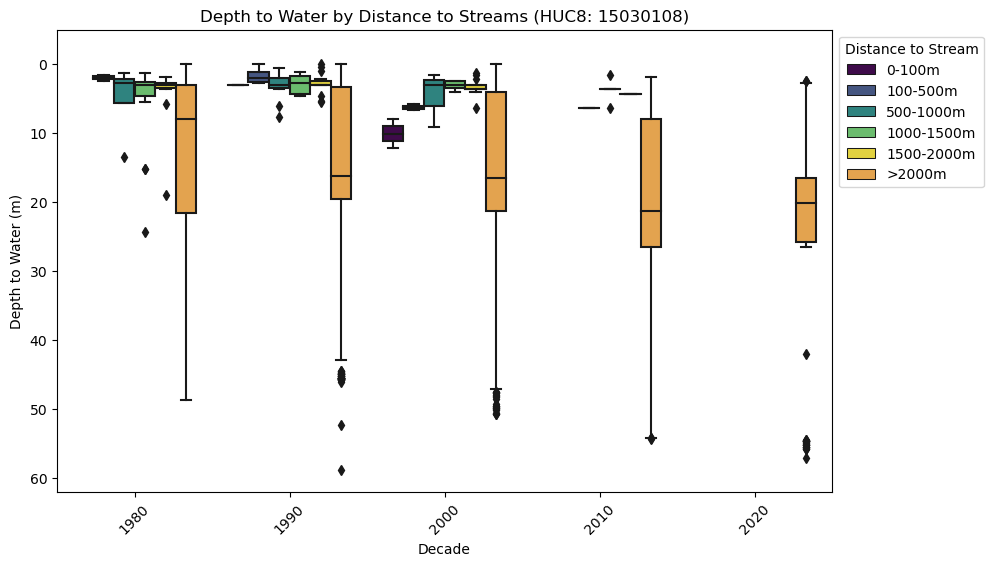

<Figure size 640x480 with 0 Axes>

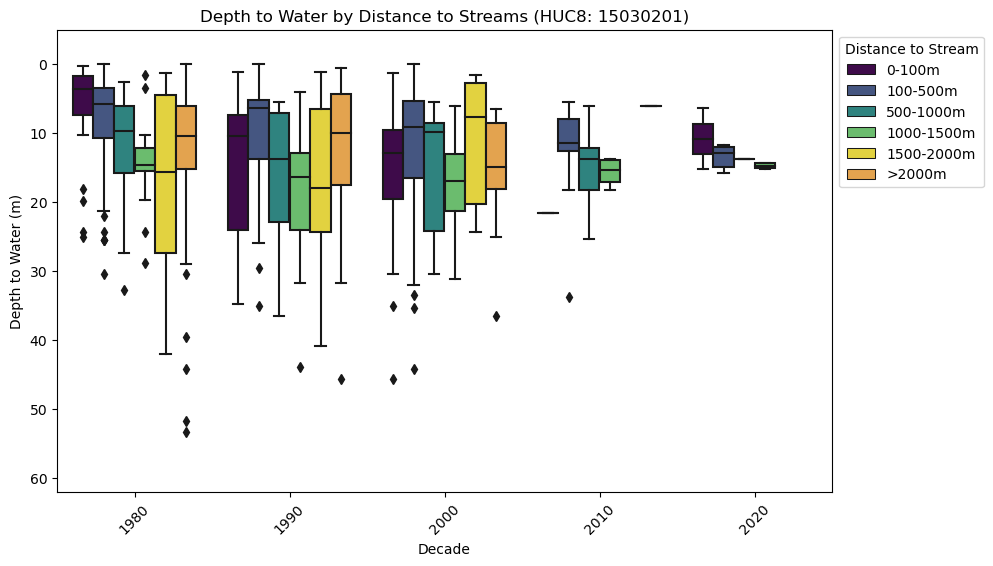

<Figure size 640x480 with 0 Axes>

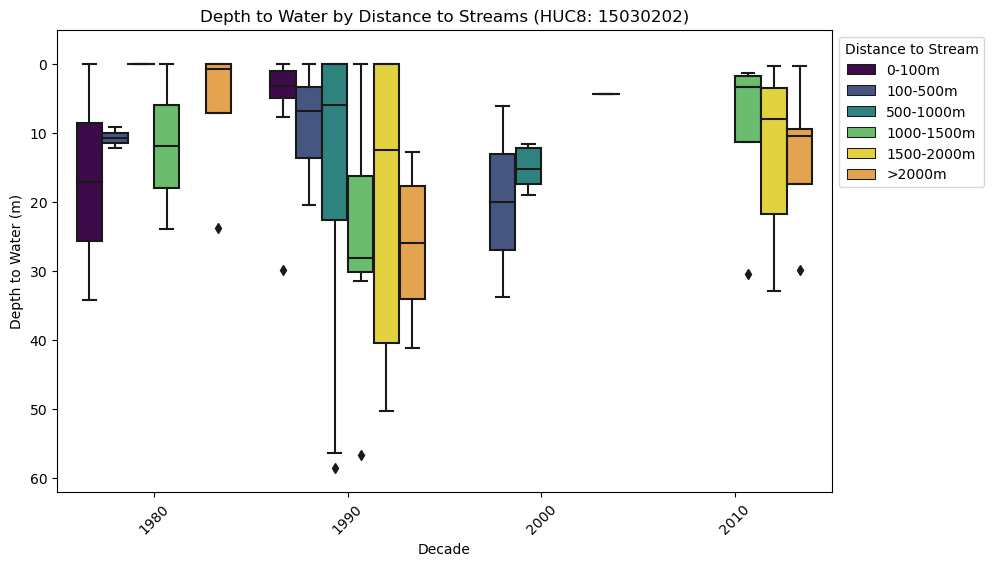

<Figure size 640x480 with 0 Axes>

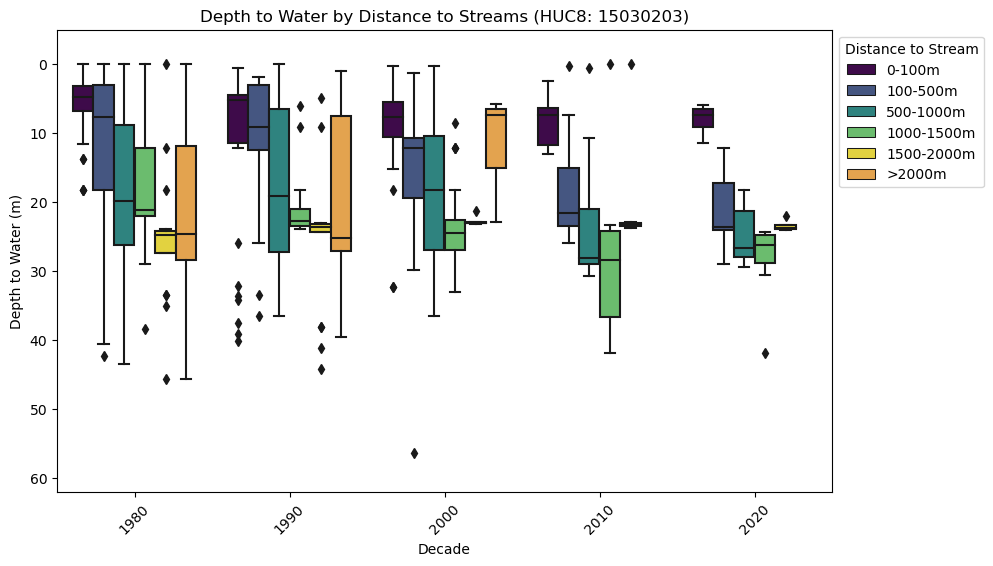

<Figure size 640x480 with 0 Axes>

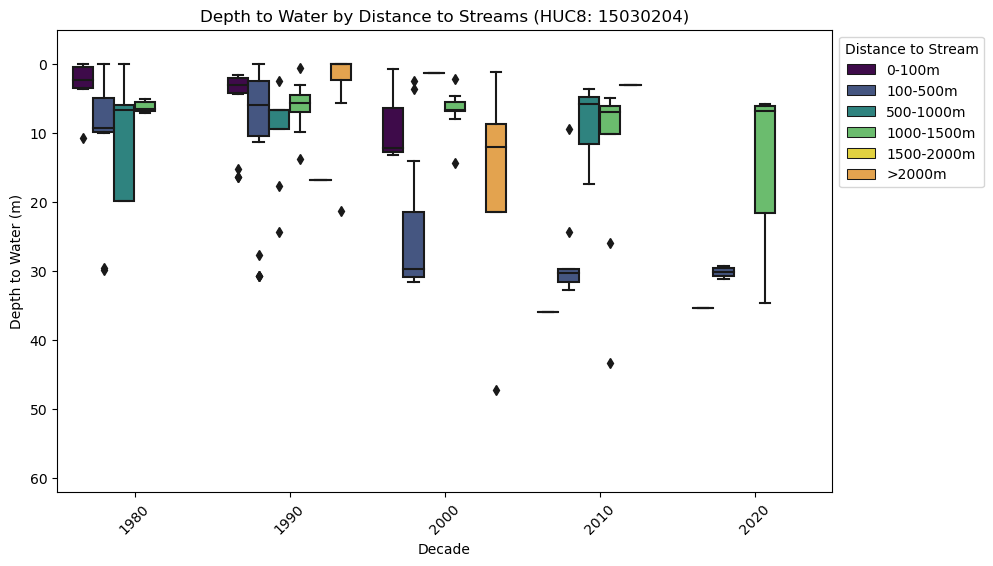

<Figure size 640x480 with 0 Axes>

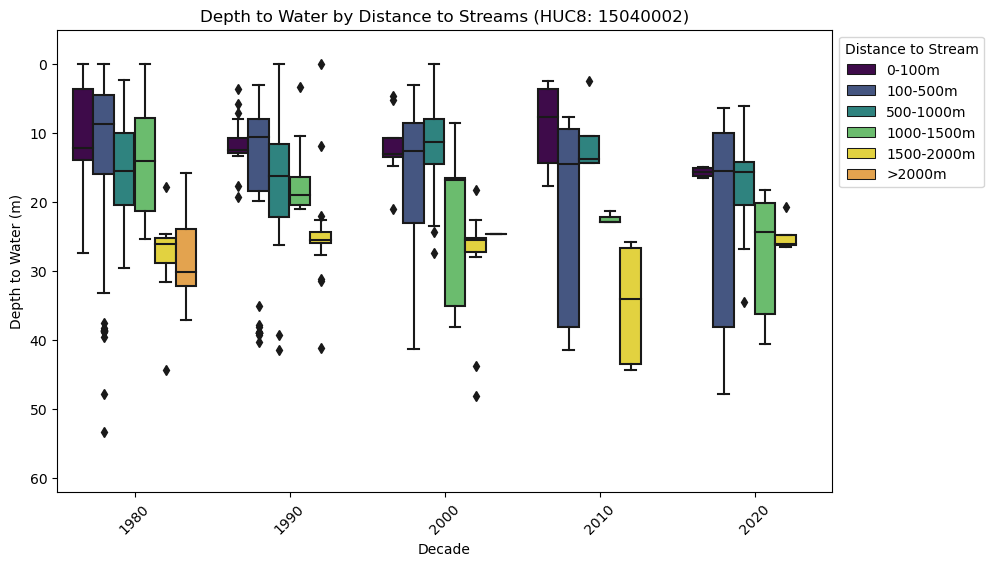

<Figure size 640x480 with 0 Axes>

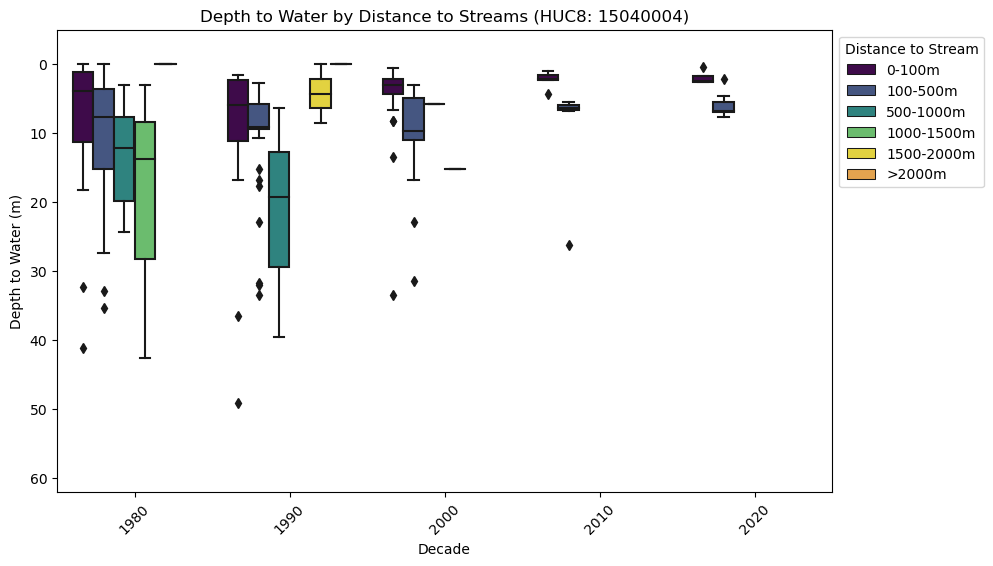

<Figure size 640x480 with 0 Axes>

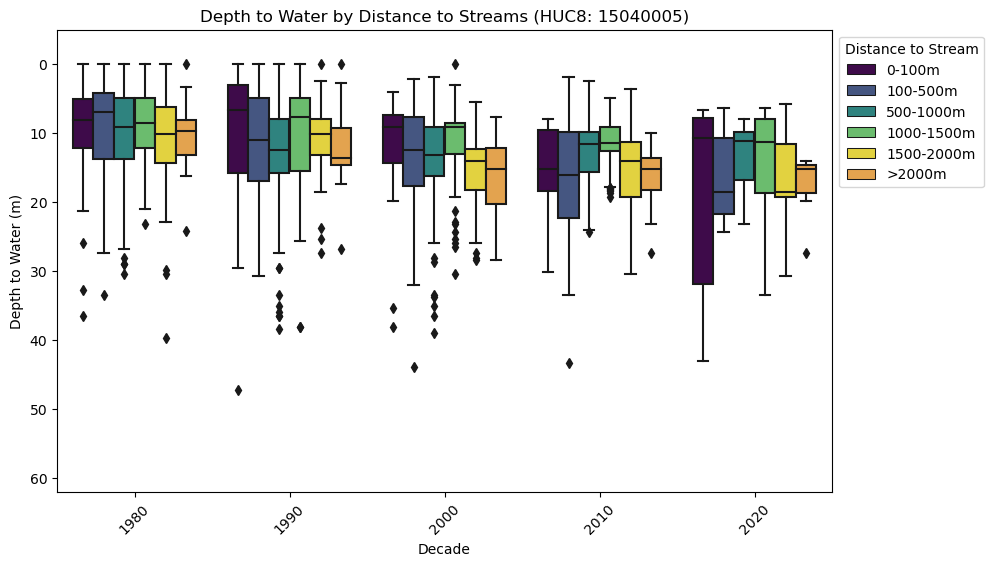

<Figure size 640x480 with 0 Axes>

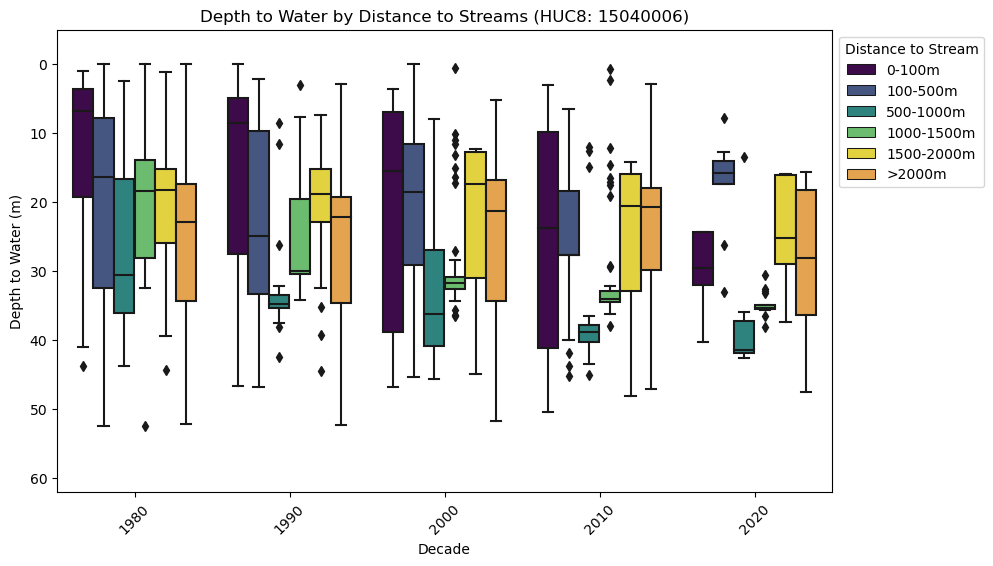

<Figure size 640x480 with 0 Axes>

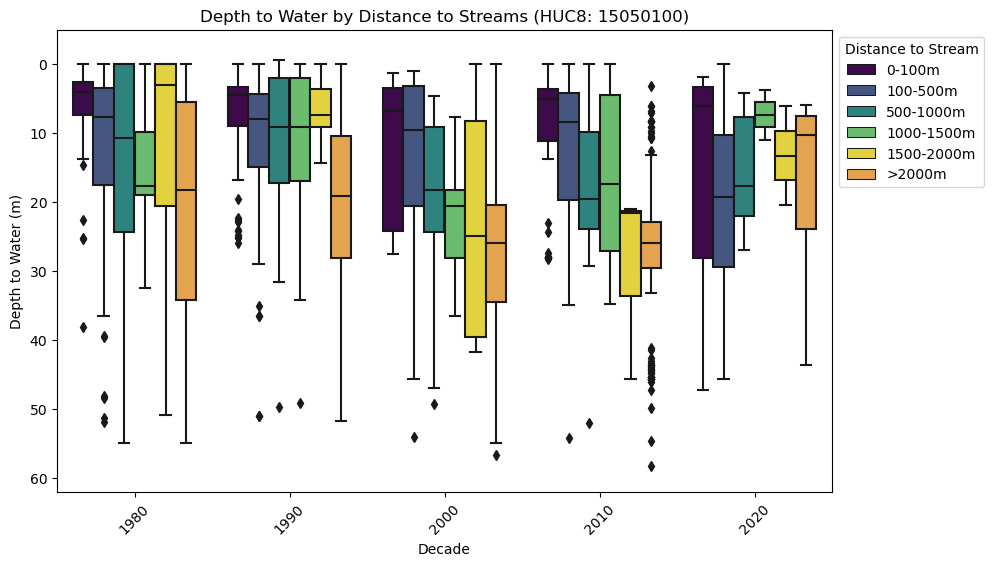

<Figure size 640x480 with 0 Axes>

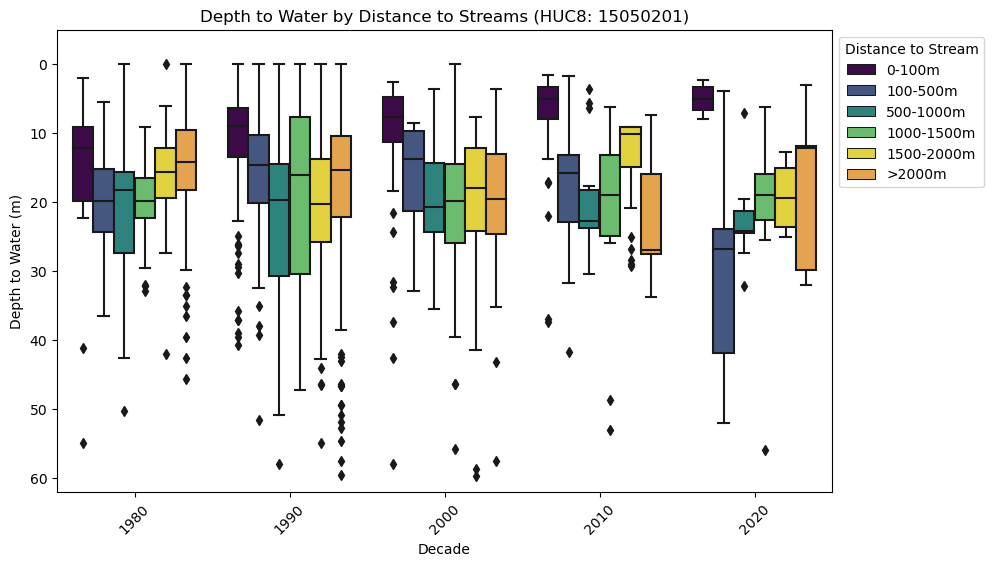

<Figure size 640x480 with 0 Axes>

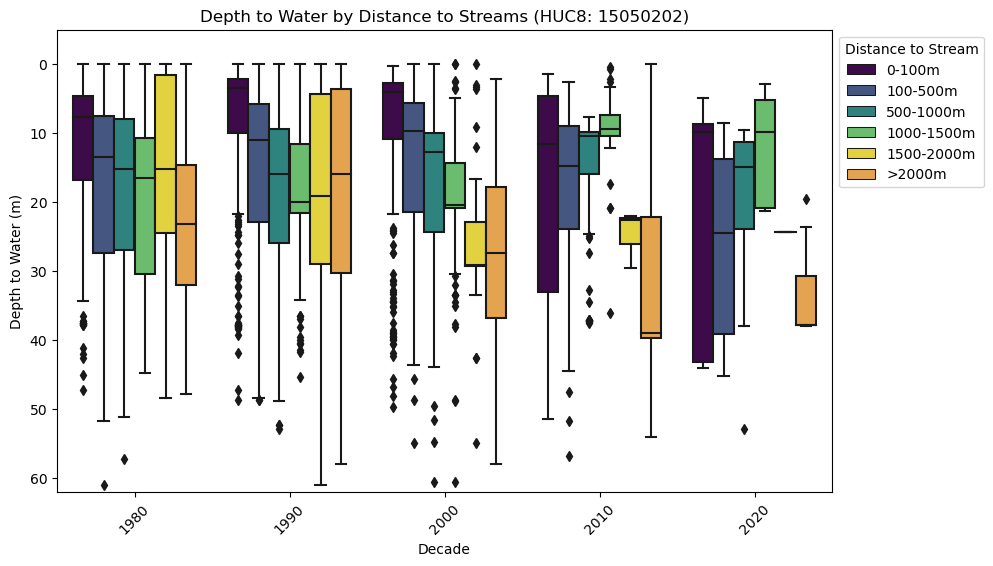

<Figure size 640x480 with 0 Axes>

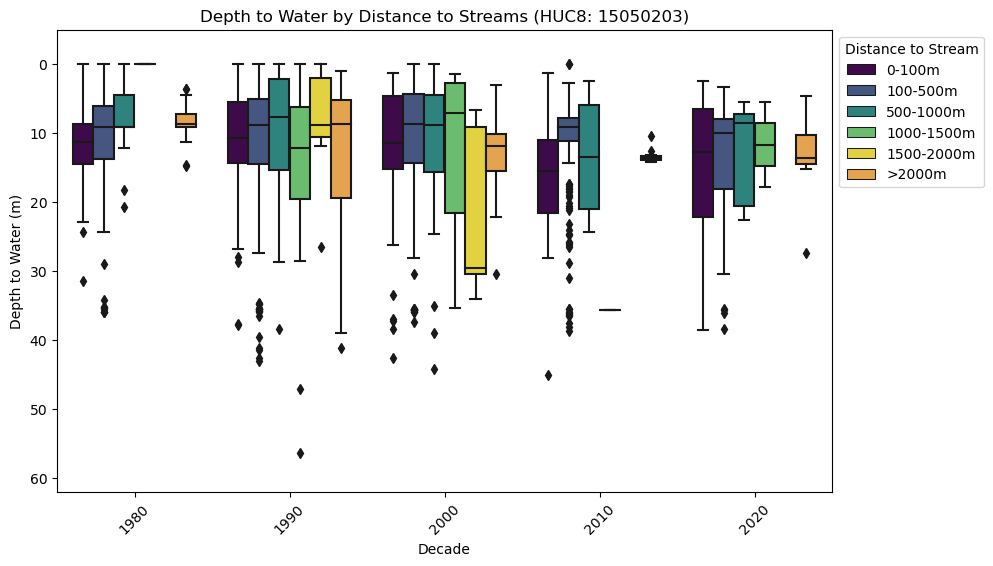

<Figure size 640x480 with 0 Axes>

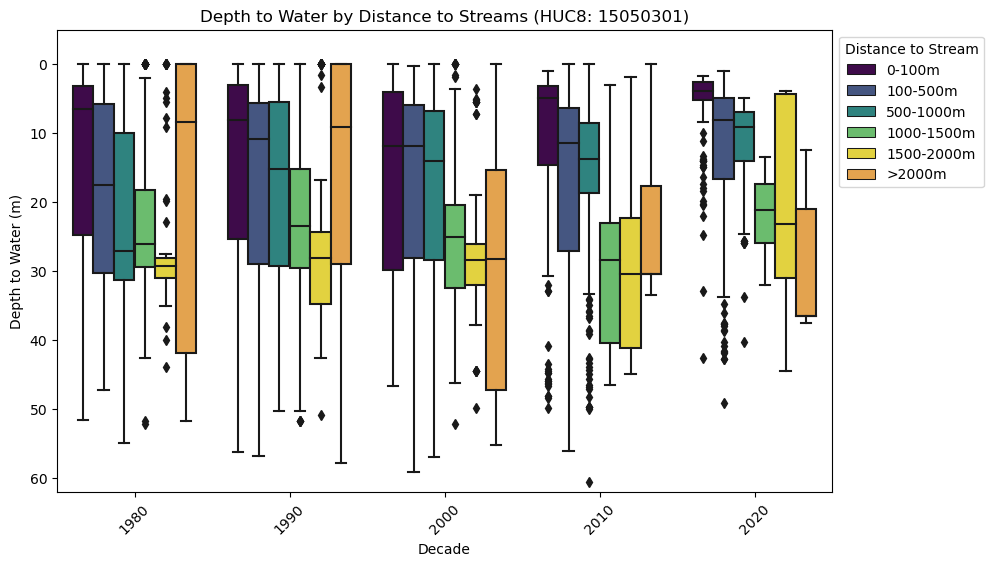

<Figure size 640x480 with 0 Axes>

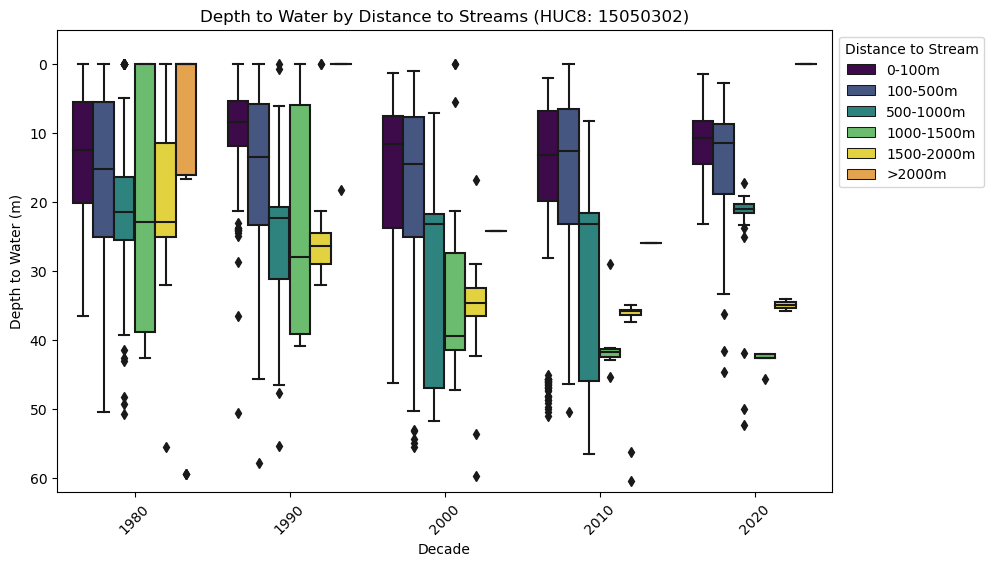

<Figure size 640x480 with 0 Axes>

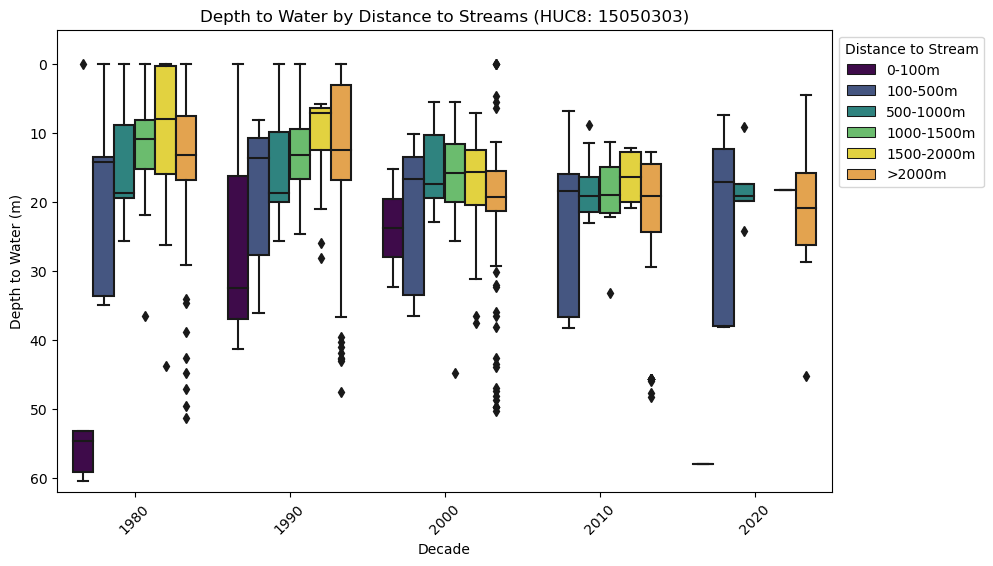

<Figure size 640x480 with 0 Axes>

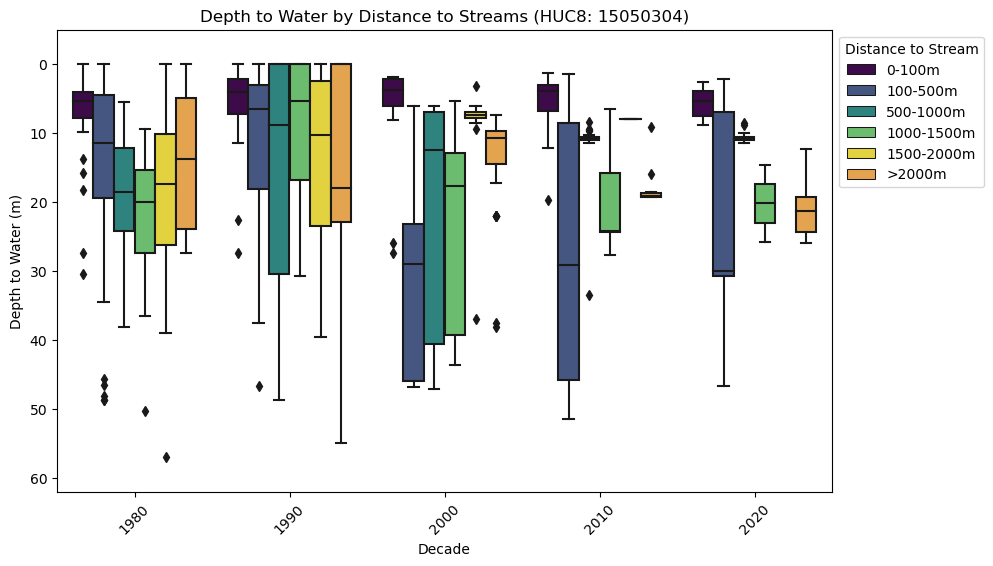

<Figure size 640x480 with 0 Axes>

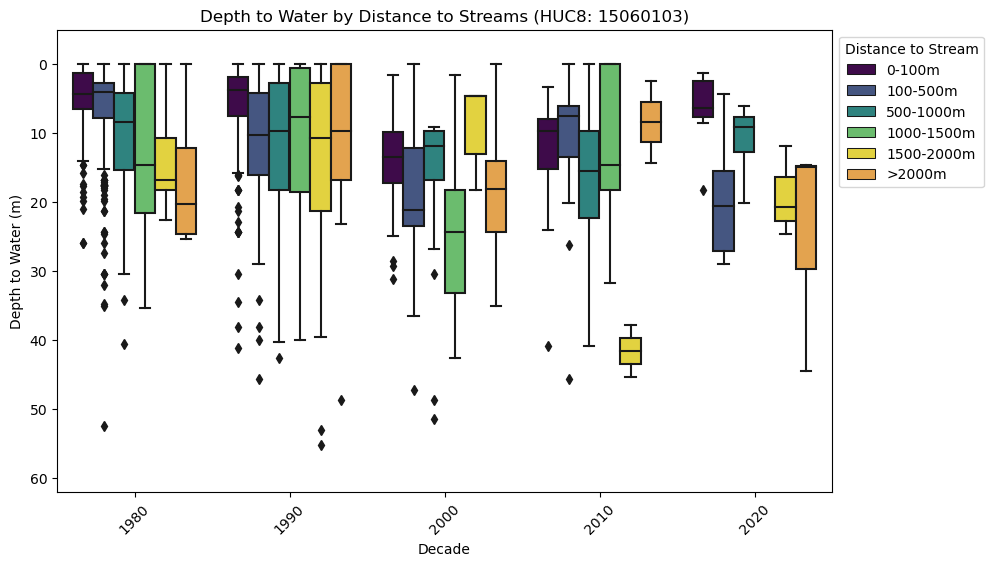

<Figure size 640x480 with 0 Axes>

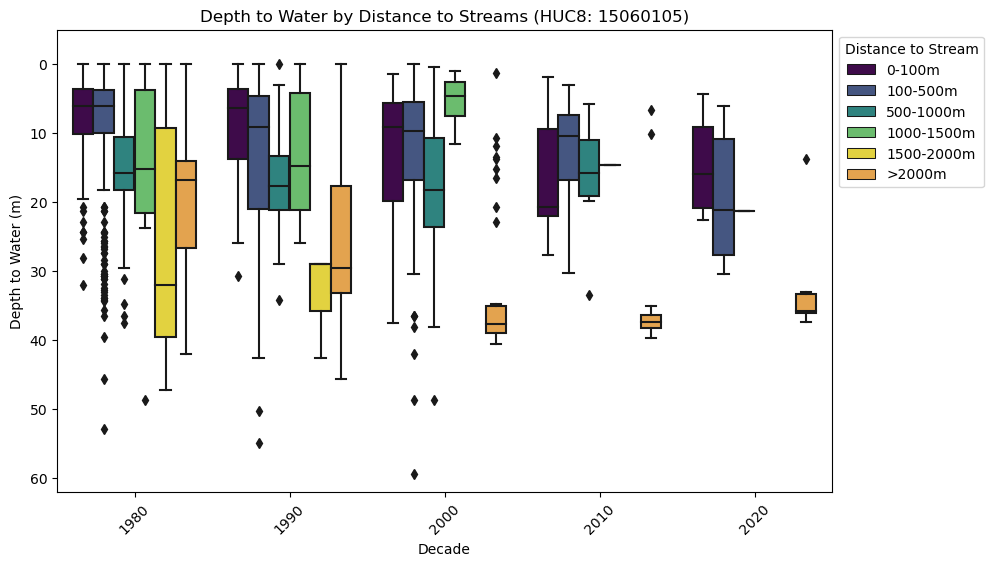

<Figure size 640x480 with 0 Axes>

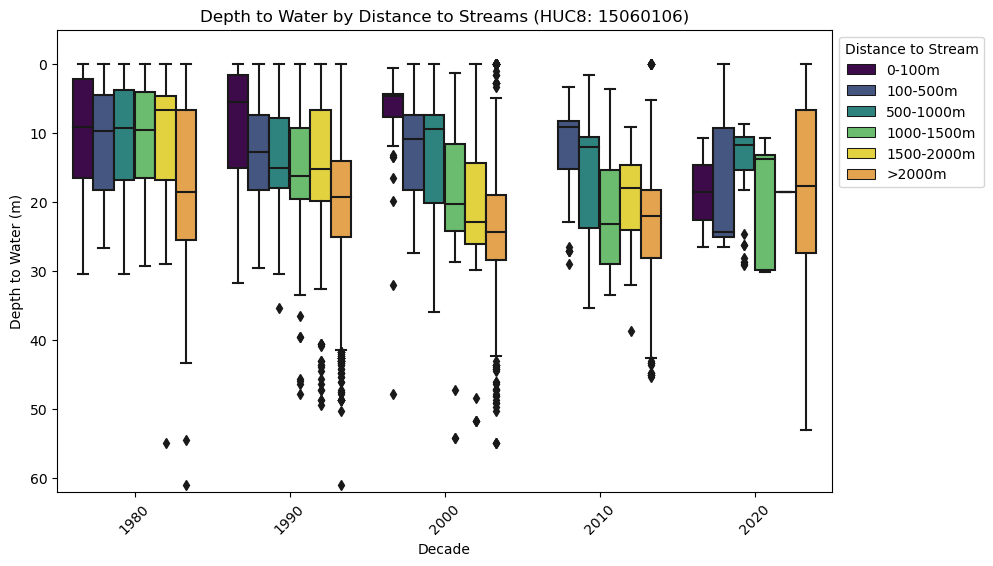

<Figure size 640x480 with 0 Axes>

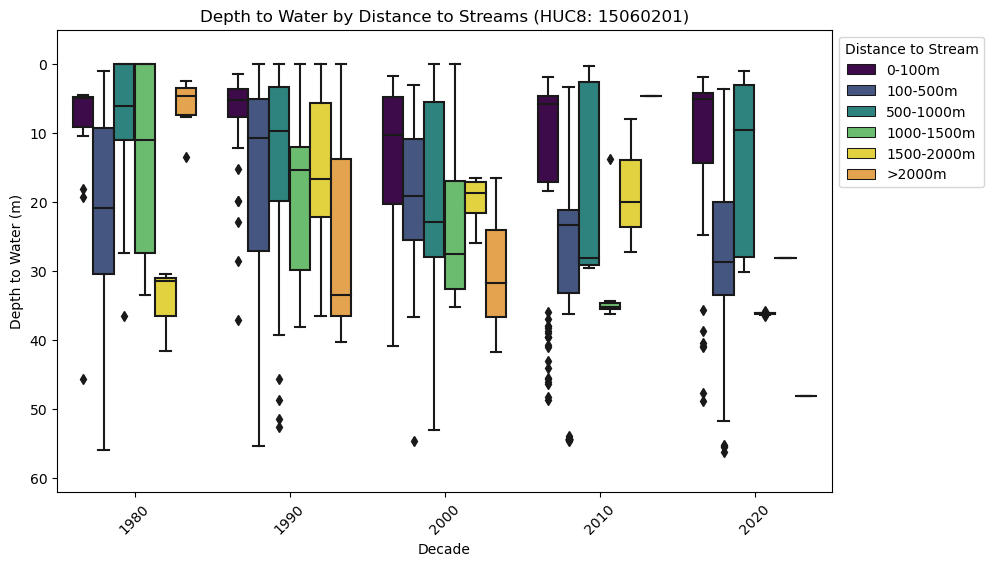

<Figure size 640x480 with 0 Axes>

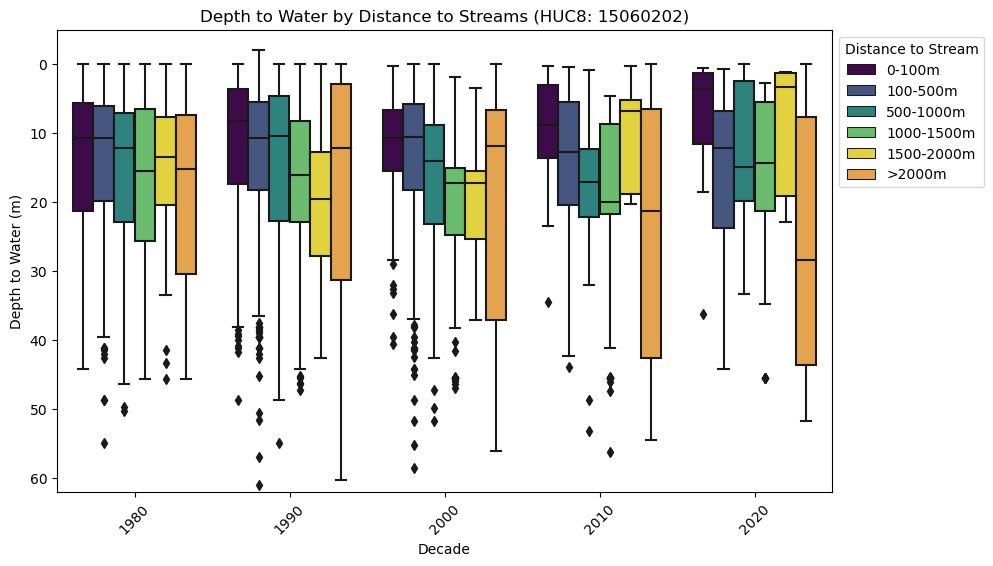

<Figure size 640x480 with 0 Axes>

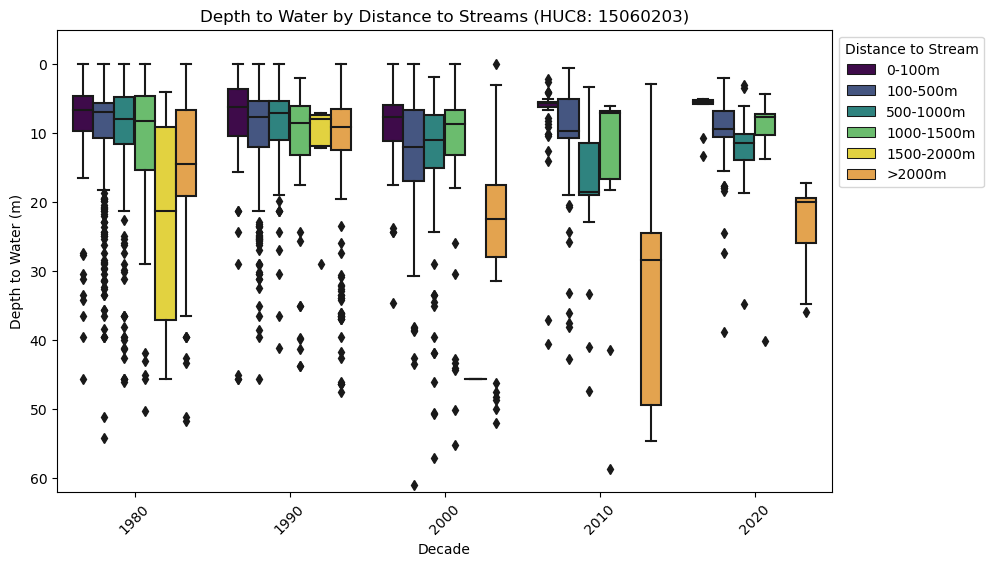

<Figure size 640x480 with 0 Axes>

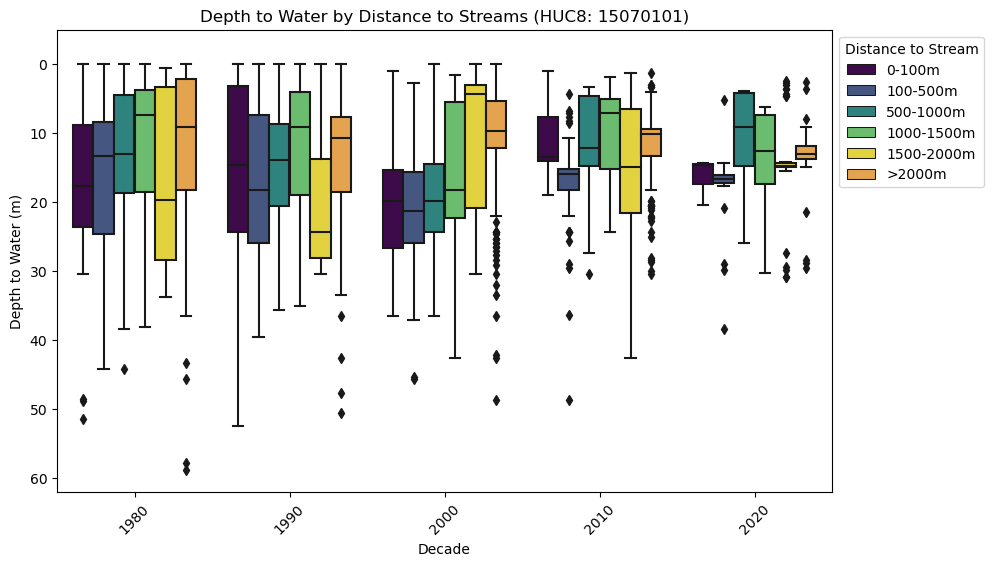

<Figure size 640x480 with 0 Axes>

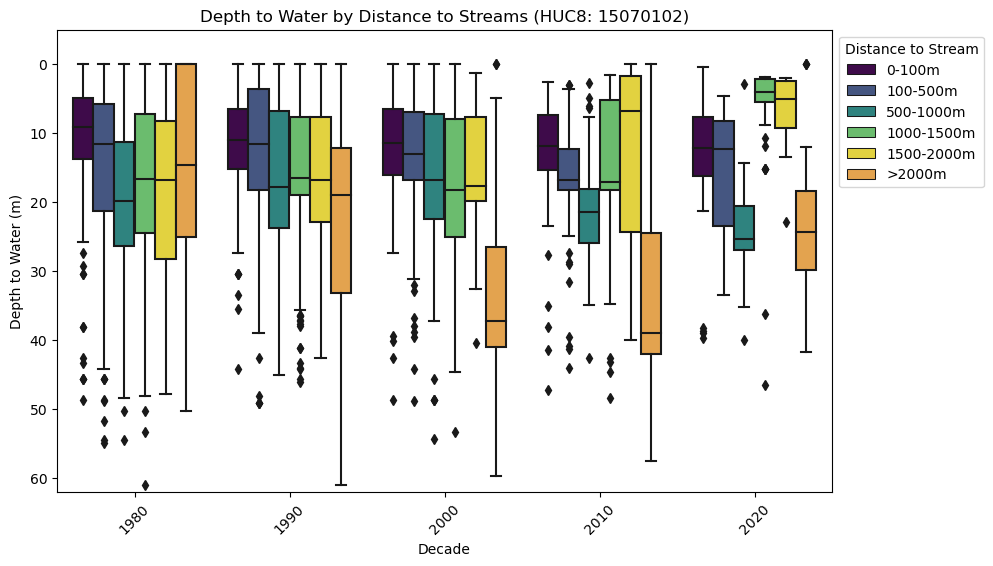

<Figure size 640x480 with 0 Axes>

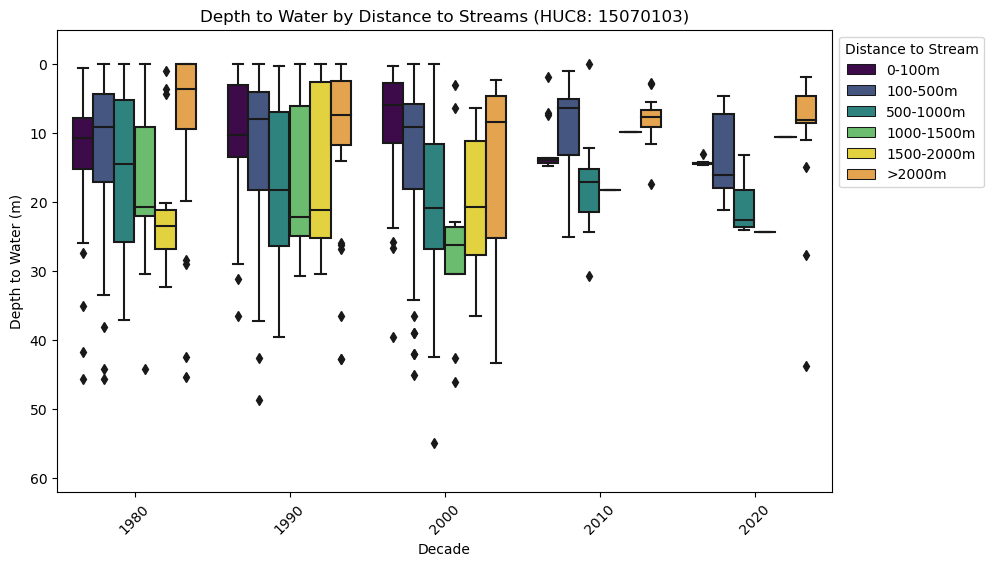

<Figure size 640x480 with 0 Axes>

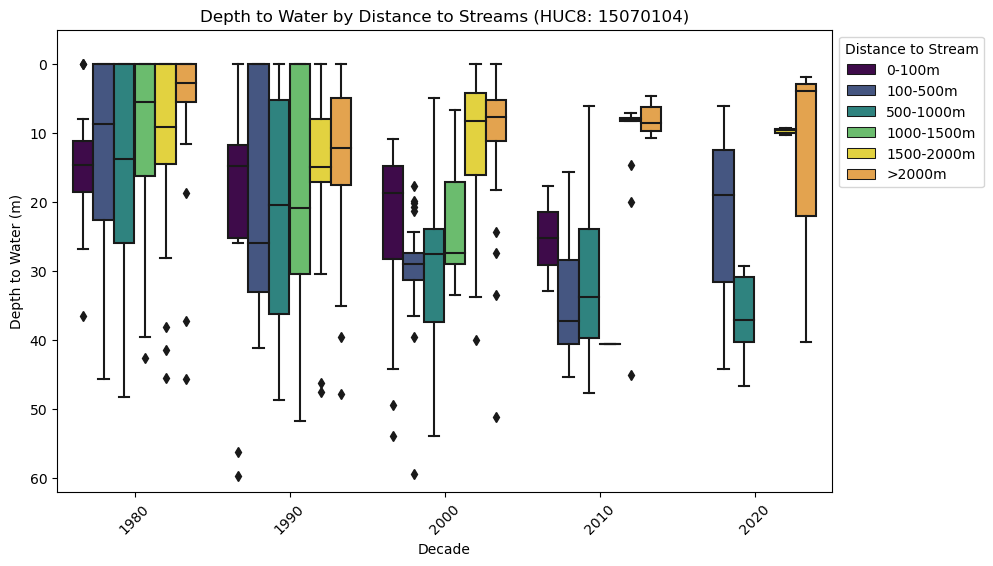

<Figure size 640x480 with 0 Axes>

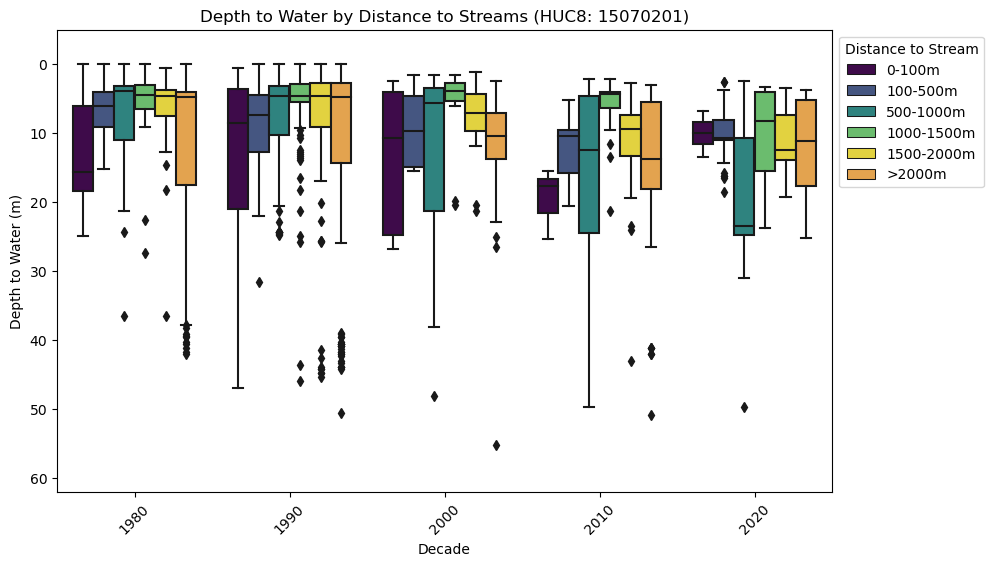

<Figure size 640x480 with 0 Axes>

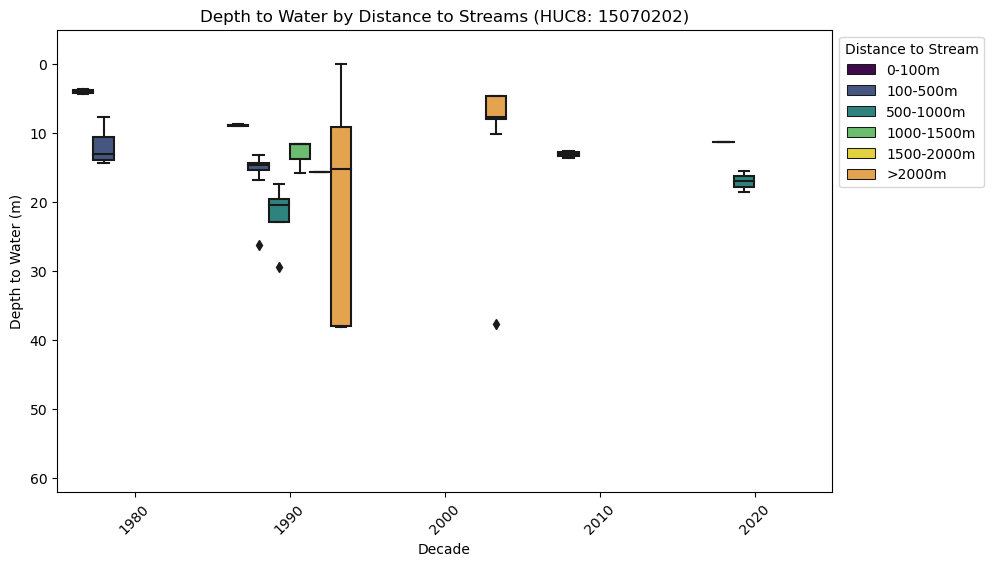

<Figure size 640x480 with 0 Axes>

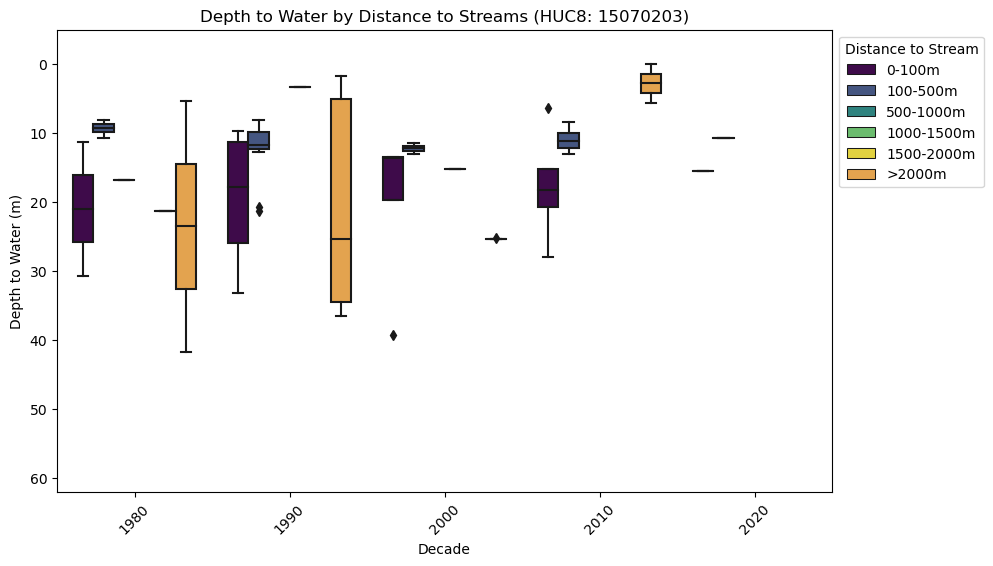

<Figure size 640x480 with 0 Axes>

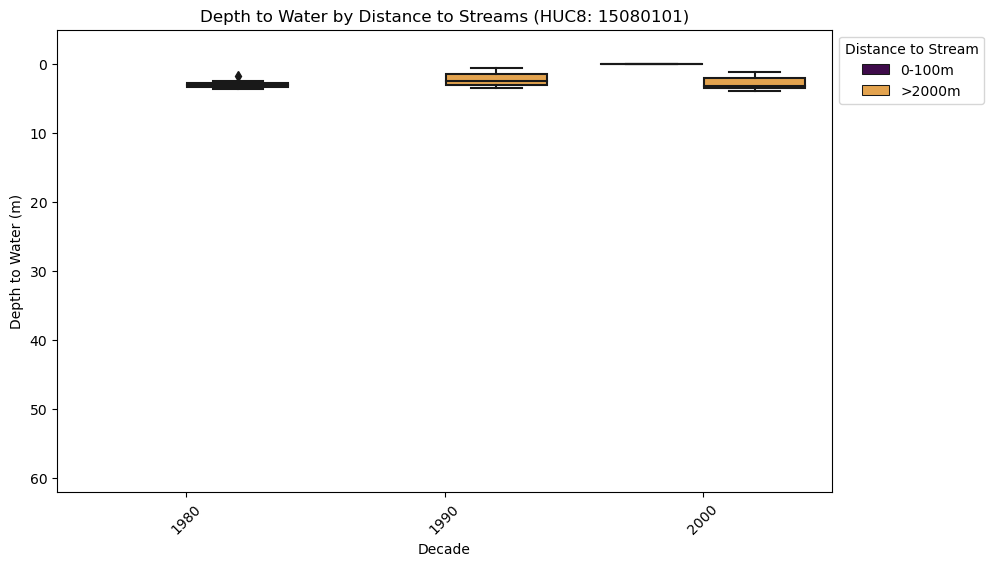

<Figure size 640x480 with 0 Axes>

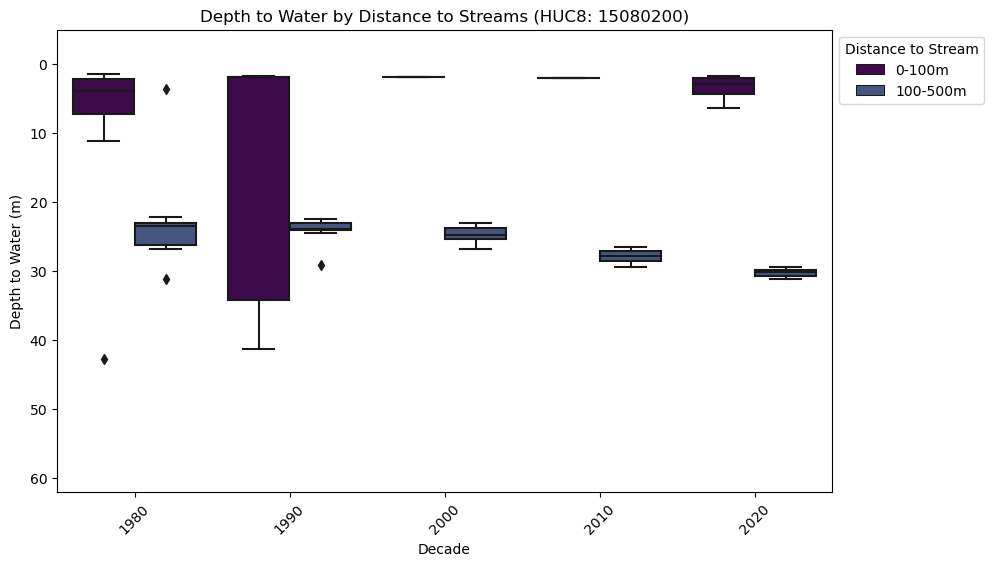

<Figure size 640x480 with 0 Axes>

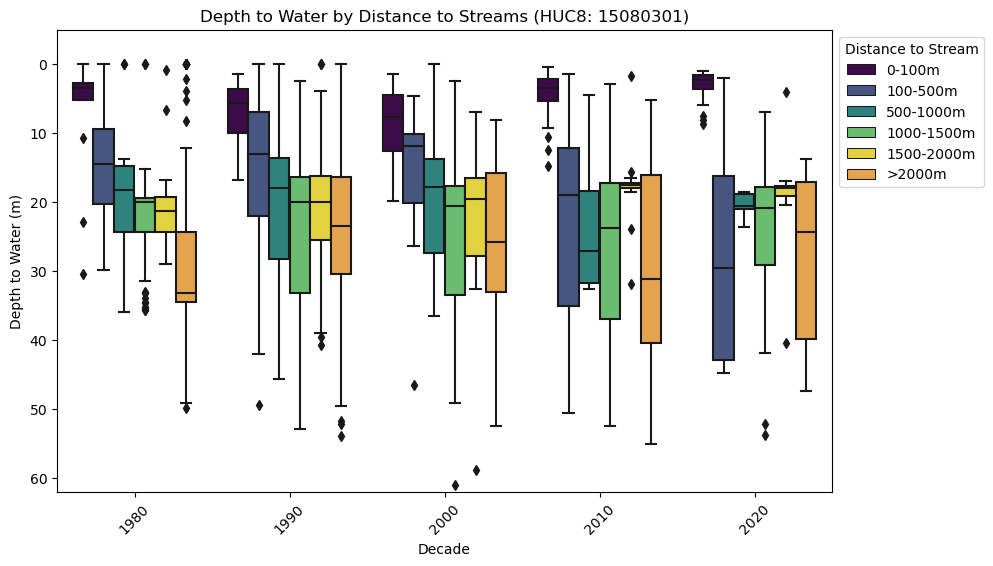

<Figure size 640x480 with 0 Axes>

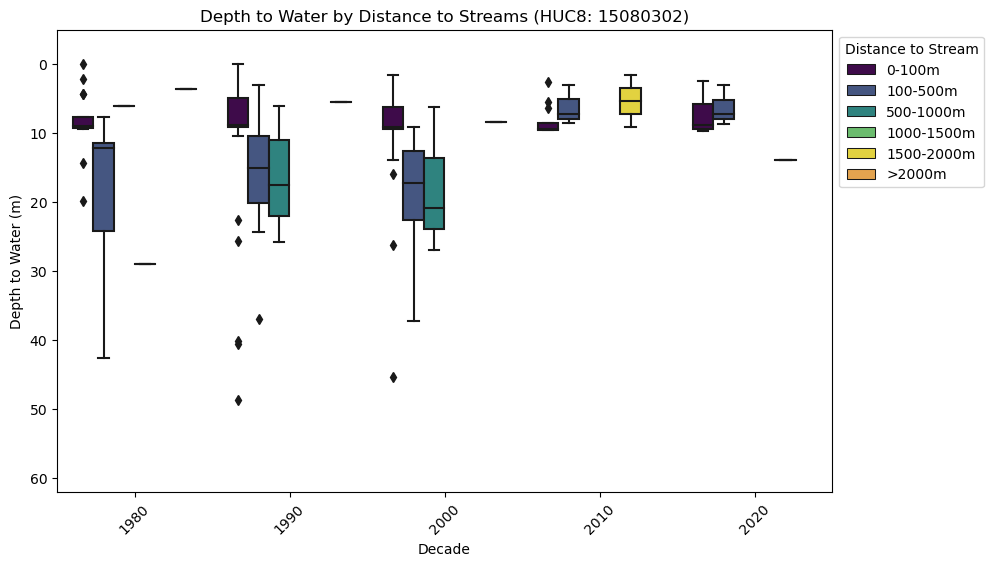

<Figure size 640x480 with 0 Axes>

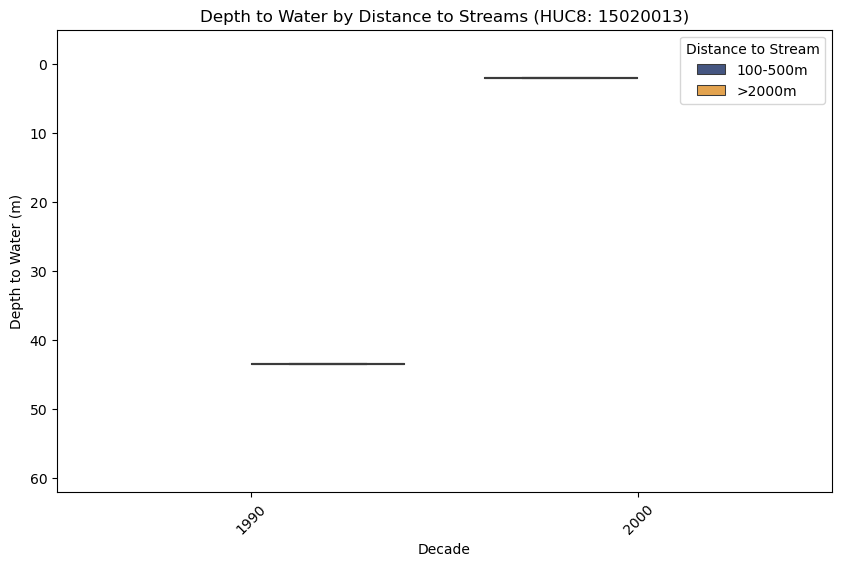

<Figure size 640x480 with 0 Axes>

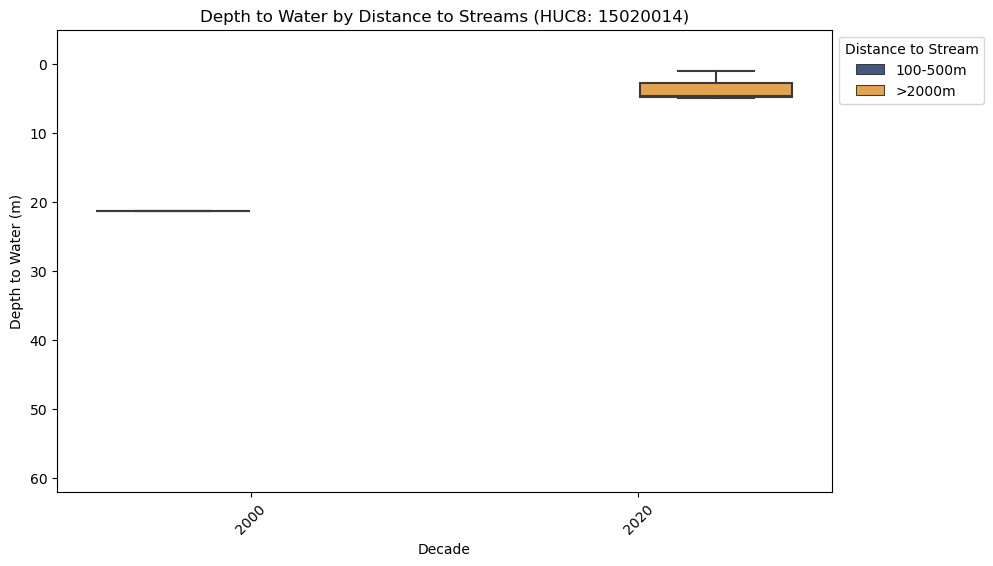

<Figure size 640x480 with 0 Axes>

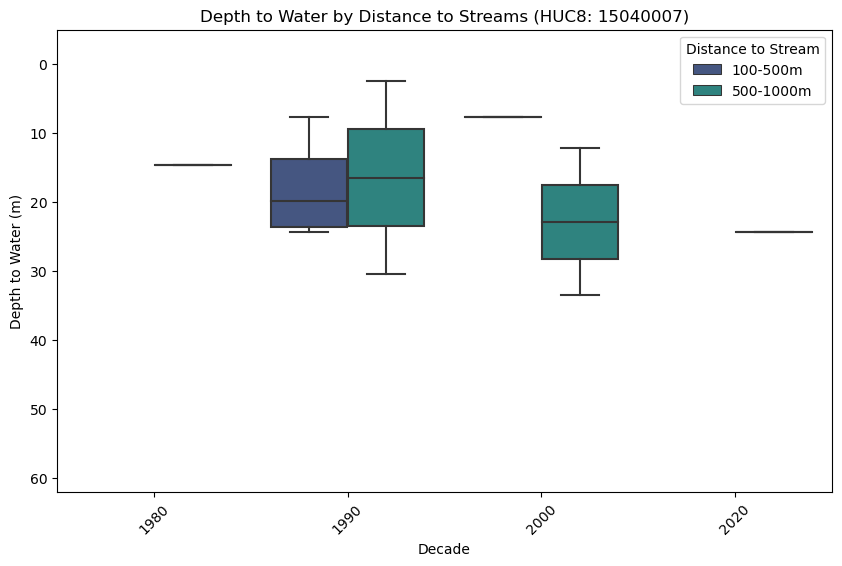

<Figure size 640x480 with 0 Axes>

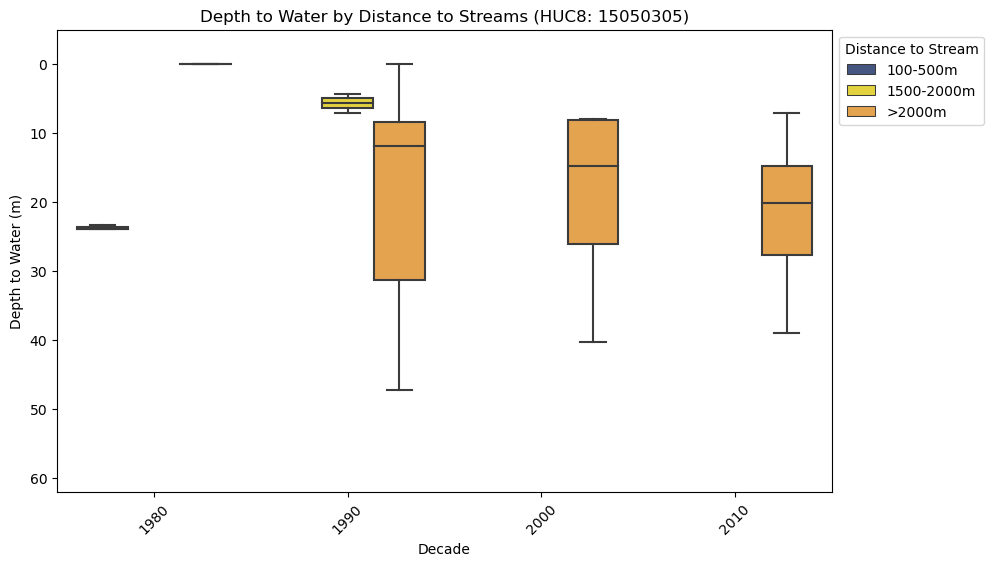

<Figure size 640x480 with 0 Axes>

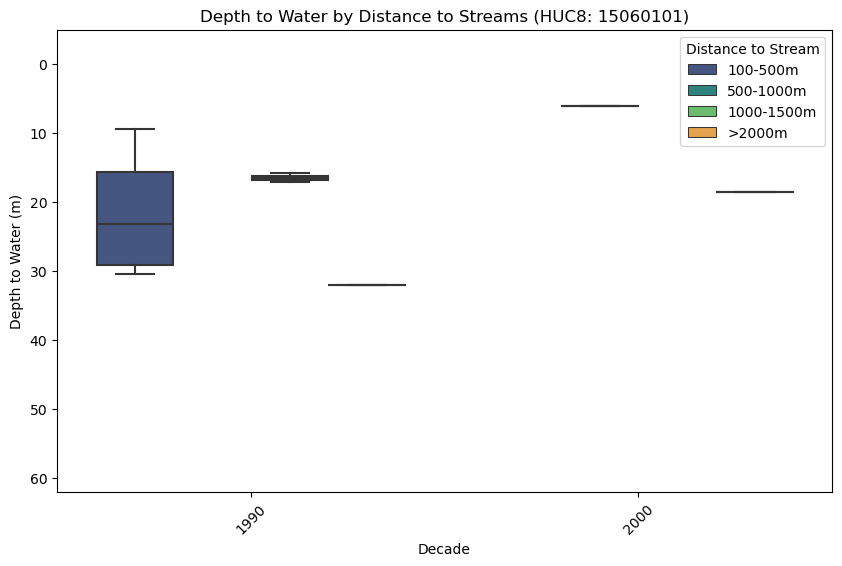

<Figure size 640x480 with 0 Axes>

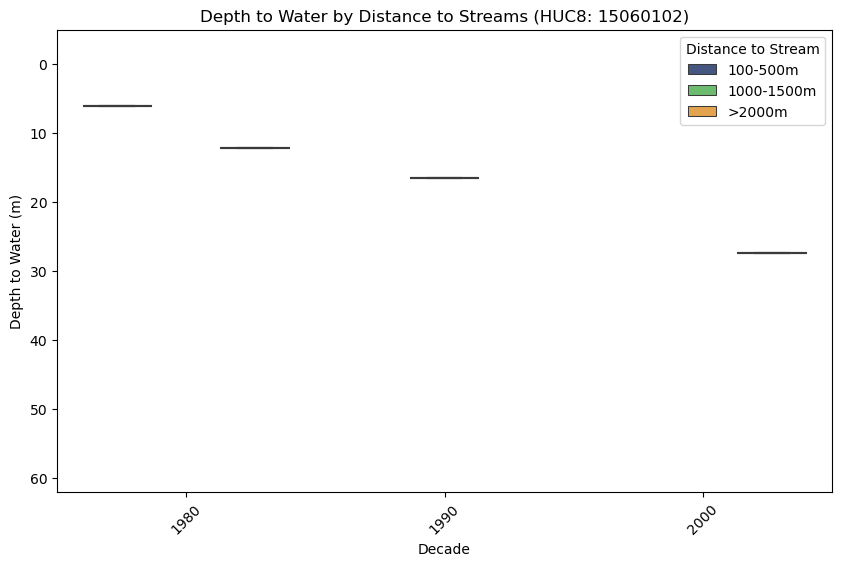

<Figure size 640x480 with 0 Axes>

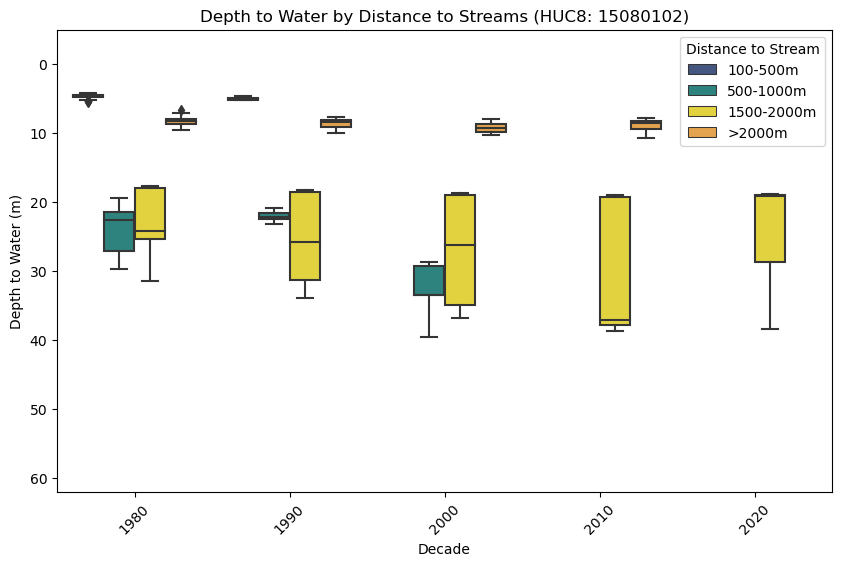

<Figure size 640x480 with 0 Axes>

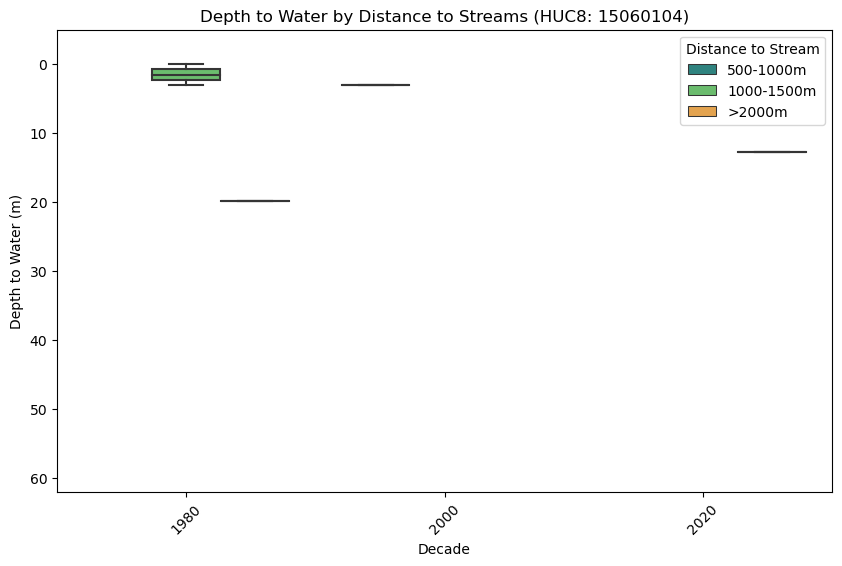

<Figure size 640x480 with 0 Axes>

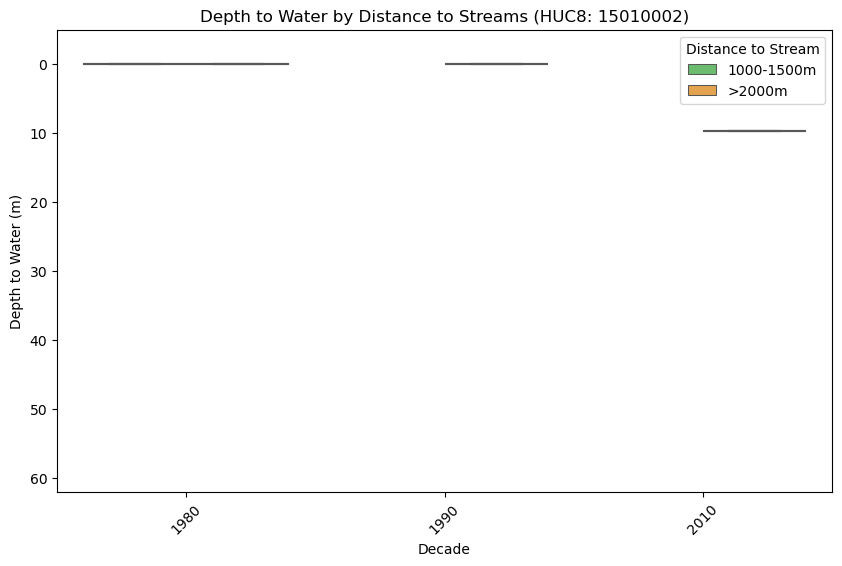

<Figure size 640x480 with 0 Axes>

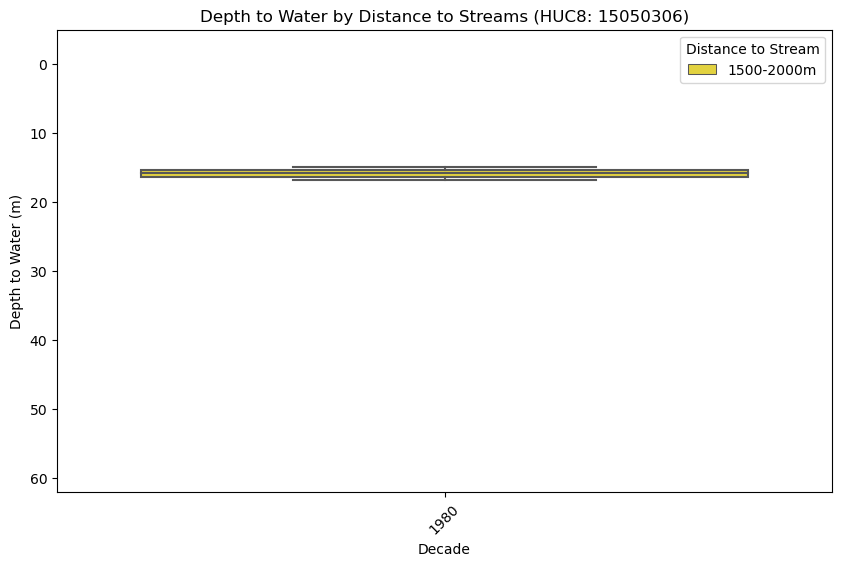

<Figure size 640x480 with 0 Axes>

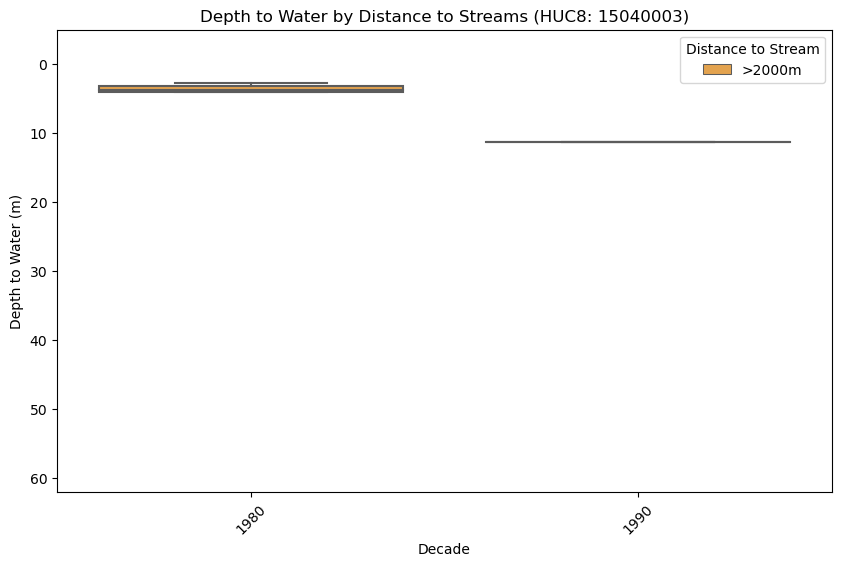

<Figure size 640x480 with 0 Axes>

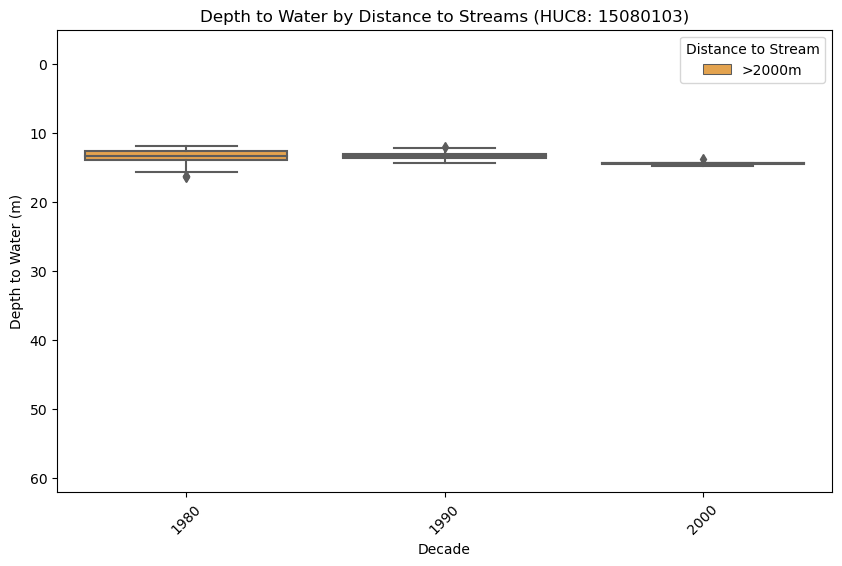

<Figure size 640x480 with 0 Axes>

In [67]:
# Get unique HUC8s
huc_list = final_df[Naming_col].unique()

# Loop through each HUC8 and create a plot
for huc in huc_list:
    subset_df = final_df[final_df[Naming_col] == huc]  # Filter by HUC8

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=subset_df, 
        x="Decade", 
        y="DTW_meters", 
        hue="Distance_to_Stream", 
        palette=custom_palette
    )
    plt.ylim(62,-5)
    plt.title(f"Depth to Water by Distance to Streams (HUC8: {huc})")
    plt.xlabel("Decade")
    plt.ylabel("Depth to Water (m)")
    plt.legend(title="Distance to Stream", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)

    # Show or save the figure
    plt.show()
    plt.savefig(figurepath+f"huc8_{huc}_depth_to_water.png", dpi=300, bbox_inches="tight")  # Uncomment to save


This section looks at distribution of wells and their locations

In [74]:
stats_distances["100m"]

Decade      huc8         DTW_Category  Well Count
0      1980  15010003   Near Surface (<2m)           1
1      1980  15010005        Deep (10-61m)           1
2      1980  15010005  Very Shallow (2-5m)           1
3      1980  15010006   Near Surface (<2m)           1
4      1980  15010006  Very Shallow (2-5m)           1
..      ...       ...                  ...         ...
672    2020  15080301   Near Surface (<2m)           2
673    2020  15080301      Shallow (5-10m)           4
674    2020  15080301  Very Shallow (2-5m)           2
675    2020  15080302      Shallow (5-10m)           3
676    2020  15080302  Very Shallow (2-5m)           1

[677 rows x 4 columns]

In [79]:
# Merge all distance dataframes into boundaries_stats
for key, df in stats_distances.items():
    boundaries_stats = boundaries_stats.merge(df, on=["Decade", Naming_col, "DTW_Category"], how="left", suffixes=("", f"_{key}"))

# Display the final merged dataframe
boundaries_stats.head()

Decade      huc8        DTW_Category  Well Count  Well Count_100m  \
0    1980  15010001  Near Surface (<2m)           2              NaN   
1    1980  15010002  Near Surface (<2m)           3              NaN   
2    1980  15010003       Deep (10-61m)           4              NaN   
3    1980  15010003  Near Surface (<2m)          17              1.0   
4    1980  15010003     Shallow (5-10m)           2              NaN   

   Well Count_500m  Well Count_1000m  Well Count_1500m  Well Count_2000m  
0              1.0               2.0               2.0               2.0  
1              NaN               NaN               1.0               1.0  
2              1.0               1.0               1.0               2.0  
3              4.0               5.0               8.0              10.0  
4              1.0               1.0               1.0               2.0

In [82]:
boundaries_stats['>2000m'] = boundaries_stats['Well Count'] - boundaries_stats['Well Count_2000m']
boundaries_stats

Decade      huc8         DTW_Category  Well Count  Well Count_100m  \
0       1980  15010001   Near Surface (<2m)           2              NaN   
1       1980  15010002   Near Surface (<2m)           3              NaN   
2       1980  15010003        Deep (10-61m)           4              NaN   
3       1980  15010003   Near Surface (<2m)          17              1.0   
4       1980  15010003      Shallow (5-10m)           2              NaN   
...      ...       ...                  ...         ...              ...   
1046    2020  15080301      Shallow (5-10m)           7              4.0   
1047    2020  15080301  Very Shallow (2-5m)           3              2.0   
1048    2020  15080302        Deep (10-61m)           1              NaN   
1049    2020  15080302      Shallow (5-10m)           5              3.0   
1050    2020  15080302  Very Shallow (2-5m)           2              1.0   

      Well Count_500m  Well Count_1000m  Well Count_1500m  Well Count_2000m  \
0                 1.0               2.0               2.0               2.0   
1                 NaN               NaN               1.0               1.0   
2                 1.0               1.0               1.0               2.0   
3                 4.0               5.0               8.0              10.0   
4                 1.0               1.0               1.0               2.0   
...               ...               ...               ...               ...   
1046              5.0               5.0               7.0               7.0   
1047              2.0               2.0               2.0               3.0   
1048              NaN               NaN               NaN               1.0   
1049              5.0               5.0               5.0               5.0   
1050              2.0               2.0               2.0               2.0   

      >2000m  
0        0.0  
1        2.0  
2        2.0  
3        7.0  
4        0.0  
...      ...  
1046     0.0  
1047     0.0  
1048     0.0  
1049     0.0  
1050     0.0  

[1051 rows x 10 columns]

In [83]:
# Identify which huc's have negatives
subset = boundaries_stats[boundaries_stats[">2000m"]<0]
subset['huc8'].unique()
# subset

array([], dtype=int64)

In [84]:
away_pivot = boundaries_stats.copy()
away_pivot = away_pivot[away_pivot["DTW_Category"] != "Deep (10-61m)"]
away_pivot = pd.pivot_table(away_pivot, index=[Naming_col], columns=["Decade"], values=[">2000m"], dropna=False, aggfunc=np.sum)
away_pivot

>2000m                     
Decade     1980  1990 2000 2010 2020
huc8                                
15010001    0.0   0.0  NaN  0.0  NaN
15010002    2.0   0.0  NaN  0.0  NaN
15010003    7.0   0.0  2.0  0.0  NaN
15010004   17.0   0.0  0.0  0.0  2.0
15010005    1.0   1.0  NaN  NaN  NaN
...         ...   ...  ...  ...  ...
15080101    0.0   0.0  1.0  NaN  NaN
15080102    1.0   1.0  0.0  0.0  NaN
15080200    0.0   0.0  0.0  0.0  0.0
15080301   13.0  30.0  2.0  7.0  0.0
15080302    1.0   1.0  1.0  0.0  0.0

[74 rows x 5 columns]

In [85]:
twokm_pivot = boundaries_stats.copy()
twokm_pivot = twokm_pivot[twokm_pivot["DTW_Category"] != "Deep (10-61m)"]
twokm_pivot = pd.pivot_table(twokm_pivot, index=[Naming_col], columns=["Decade"], values=["Well Count_2000m"], dropna=False, aggfunc=np.sum)
# twokm_pivot = twokm_pivot.reset_index()
twokm_pivot

Well Count_2000m                        
Decade               1980  1990  2000  2010  2020
huc8                                             
15010001              2.0   2.0   NaN   2.0   NaN
15010002              1.0   0.0   NaN   0.0   NaN
15010003             12.0  12.0  12.0   1.0   NaN
15010004             44.0  26.0  17.0   1.0   3.0
15010005              3.0   2.0   NaN   NaN   NaN
...                   ...   ...   ...   ...   ...
15080101              0.0   0.0   1.0   NaN   NaN
15080102              2.0   2.0   0.0   0.0   NaN
15080200             11.0   3.0   1.0   1.0   4.0
15080301             19.0  72.0  28.0  31.0  13.0
15080302              7.0  18.0  12.0   9.0   7.0

[74 rows x 5 columns]

In [86]:
boundaries_stats.describe()

Decade          huc8   Well Count  Well Count_100m  \
count  1051.000000  1.051000e+03  1051.000000       677.000000   
mean   1997.963844  1.504160e+07    47.485252         7.980798   
std      13.671055  2.163708e+04   114.812520        11.644687   
min    1980.000000  1.501000e+07     1.000000         1.000000   
25%    1990.000000  1.502001e+07     3.000000         1.000000   
50%    2000.000000  1.504000e+07    12.000000         4.000000   
75%    2010.000000  1.506011e+07    46.500000         9.000000   
max    2020.000000  1.508030e+07  2129.000000       109.000000   

       Well Count_500m  Well Count_1000m  Well Count_1500m  Well Count_2000m  \
count       871.000000        933.000000        962.000000        978.000000   
mean         21.491389         28.275456         32.643451         35.522495   
std          38.635605         53.464322         63.242219         69.594380   
min           1.000000          1.000000          1.000000          1.000000   
25%           2.000000          2.000000          3.000000          3.000000   
50%           8.000000          9.000000         10.000000         11.000000   
75%          22.000000         29.000000         32.000000         34.750000   
max         352.000000        513.000000        644.000000        734.000000   

            >2000m  
count   978.000000  
mean     14.355828  
std      69.458987  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       7.000000  
max    1543.000000

In [87]:
away_table = away_pivot.xs('>2000m', axis=1)
near_table = twokm_pivot.xs('Well Count_2000m', axis=1)


In [89]:
away_table = away_table.fillna(0)
near_table = near_table.fillna(0)
away_table

Decade    1980  1990  2000  2010  2020
huc8                                  
15010001   0.0   0.0   0.0   0.0   0.0
15010002   2.0   0.0   0.0   0.0   0.0
15010003   7.0   0.0   2.0   0.0   0.0
15010004  17.0   0.0   0.0   0.0   2.0
15010005   1.0   1.0   0.0   0.0   0.0
...        ...   ...   ...   ...   ...
15080101   0.0   0.0   1.0   0.0   0.0
15080102   1.0   1.0   0.0   0.0   0.0
15080200   0.0   0.0   0.0   0.0   0.0
15080301  13.0  30.0   2.0   7.0   0.0
15080302   1.0   1.0   1.0   0.0   0.0

[74 rows x 5 columns]

In [90]:
percent_away = away_table / (away_table + near_table)
percent_away = percent_away * 100
percent_away = percent_away.round(2)
percent_away

Decade     1980   1990   2000   2010  2020
huc8                                      
15010001   0.00   0.00    NaN   0.00   NaN
15010002  66.67    NaN    NaN    NaN   NaN
15010003  36.84   0.00  14.29   0.00   NaN
15010004  27.87   0.00   0.00   0.00  40.0
15010005  25.00  33.33    NaN    NaN   NaN
...         ...    ...    ...    ...   ...
15080101    NaN    NaN  50.00    NaN   NaN
15080102  33.33  33.33    NaN    NaN   NaN
15080200   0.00   0.00   0.00   0.00   0.0
15080301  40.62  29.41   6.67  18.42   0.0
15080302  12.50   5.26   7.69   0.00   0.0

[74 rows x 5 columns]

In [32]:
percent_away.to_csv(outputpath+f'/Percentlessthan10m_AwayFromStreams_Decades_{StudyArea}.csv')

In [91]:
# Identify the reference column (first distance)
reference_column = "Well Count"  # Change this if your first column is different

boundaries_percents = boundaries_stats.copy()

# Create new columns with normalized values
for dist in distances:
    column_name = f"Well Count_{dist}m"
    if column_name in boundaries_stats.columns and reference_column in boundaries_stats.columns:
        boundaries_percents[f"Ratio_{dist}m"] = boundaries_stats[column_name] / boundaries_stats[reference_column]

# Display the first few rows to verify
boundaries_percents.head()


Decade      huc8        DTW_Category  Well Count  Well Count_100m  \
0    1980  15010001  Near Surface (<2m)           2              NaN   
1    1980  15010002  Near Surface (<2m)           3              NaN   
2    1980  15010003       Deep (10-61m)           4              NaN   
3    1980  15010003  Near Surface (<2m)          17              1.0   
4    1980  15010003     Shallow (5-10m)           2              NaN   

   Well Count_500m  Well Count_1000m  Well Count_1500m  Well Count_2000m  \
0              1.0               2.0               2.0               2.0   
1              NaN               NaN               1.0               1.0   
2              1.0               1.0               1.0               2.0   
3              4.0               5.0               8.0              10.0   
4              1.0               1.0               1.0               2.0   

   >2000m  Ratio_100m  Ratio_500m  Ratio_1000m  Ratio_1500m  Ratio_2000m  
0     0.0         NaN    0.500000     1.000000     1.000000     1.000000  
1     2.0         NaN         NaN          NaN     0.333333     0.333333  
2     2.0         NaN    0.250000     0.250000     0.250000     0.500000  
3     7.0    0.058824    0.235294     0.294118     0.470588     0.588235  
4     0.0         NaN    0.500000     0.500000     0.500000     1.000000

In [92]:
boundaries_percents.columns

Index(['Decade', 'huc8', 'DTW_Category', 'Well Count', 'Well Count_100m',
       'Well Count_500m', 'Well Count_1000m', 'Well Count_1500m',
       'Well Count_2000m', '>2000m', 'Ratio_100m', 'Ratio_500m', 'Ratio_1000m',
       'Ratio_1500m', 'Ratio_2000m'],
      dtype='object')

In [93]:
boundaries_percents = boundaries_percents.drop(columns = [
       # 'Well Count', 
       'Well Count_100m',
       'Well Count_500m', 'Well Count_1000m', 'Well Count_1500m',
       'Well Count_2000m'])
boundaries_percents

Decade      huc8         DTW_Category  Well Count  >2000m  Ratio_100m  \
0       1980  15010001   Near Surface (<2m)           2     0.0         NaN   
1       1980  15010002   Near Surface (<2m)           3     2.0         NaN   
2       1980  15010003        Deep (10-61m)           4     2.0         NaN   
3       1980  15010003   Near Surface (<2m)          17     7.0    0.058824   
4       1980  15010003      Shallow (5-10m)           2     0.0         NaN   
...      ...       ...                  ...         ...     ...         ...   
1046    2020  15080301      Shallow (5-10m)           7     0.0    0.571429   
1047    2020  15080301  Very Shallow (2-5m)           3     0.0    0.666667   
1048    2020  15080302        Deep (10-61m)           1     0.0         NaN   
1049    2020  15080302      Shallow (5-10m)           5     0.0    0.600000   
1050    2020  15080302  Very Shallow (2-5m)           2     0.0    0.500000   

      Ratio_500m  Ratio_1000m  Ratio_1500m  Ratio_2000m  
0       0.500000     1.000000     1.000000     1.000000  
1            NaN          NaN     0.333333     0.333333  
2       0.250000     0.250000     0.250000     0.500000  
3       0.235294     0.294118     0.470588     0.588235  
4       0.500000     0.500000     0.500000     1.000000  
...          ...          ...          ...          ...  
1046    0.714286     0.714286     1.000000     1.000000  
1047    0.666667     0.666667     0.666667     1.000000  
1048         NaN          NaN          NaN     1.000000  
1049    1.000000     1.000000     1.000000     1.000000  
1050    1.000000     1.000000     1.000000     1.000000  

[1051 rows x 10 columns]

In [94]:
boundaries_percents.to_csv(outputpath+"wellcounts_stats_distancetostreams.csv")

In [95]:
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']


In [96]:
# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

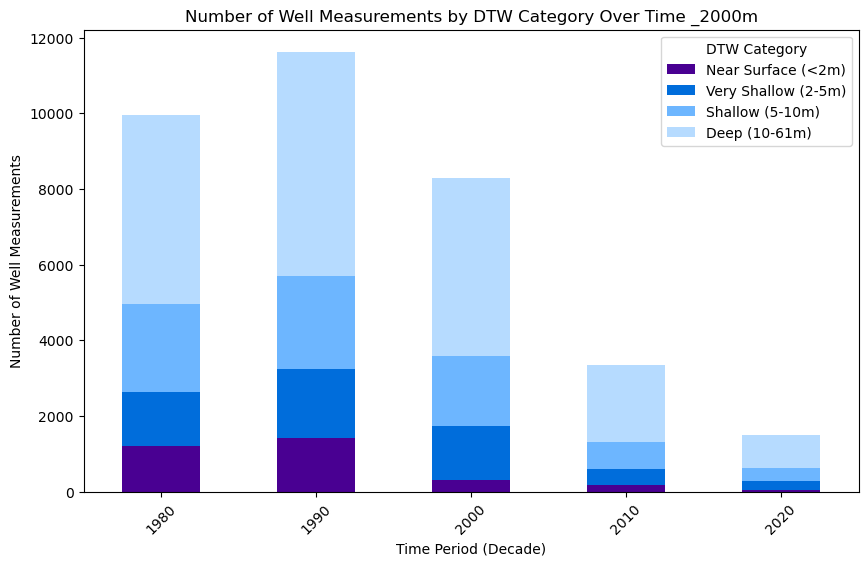

In [97]:
dist_plotting = "_2000m"

# Summing all HUCs together by Decade and DTW_Category
# summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()
summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()

# Pivot the data to get each DTW category as a separate column for stacking
summary_pivot = summary_table.pivot(index='Decade', columns='DTW_Category', values=f'Well Count{dist_plotting}').fillna(0)
# summary_pivot = boundaries_stats.pivot(index='Decade', columns='DTW_Category', values=f'Ratio{dist_plotting}').fillna(0)

# Define the desired order for DTW categories
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']

# Reorder the columns in summary_pivot
summary_pivot = summary_pivot[category_order]

# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)

# Labels and title
plt.xlabel('Time Period (Decade)')
plt.ylabel('Number of Well Measurements')
plt.title(f'Number of Well Measurements by DTW Category Over Time {dist_plotting}')
plt.legend(title='DTW Category')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


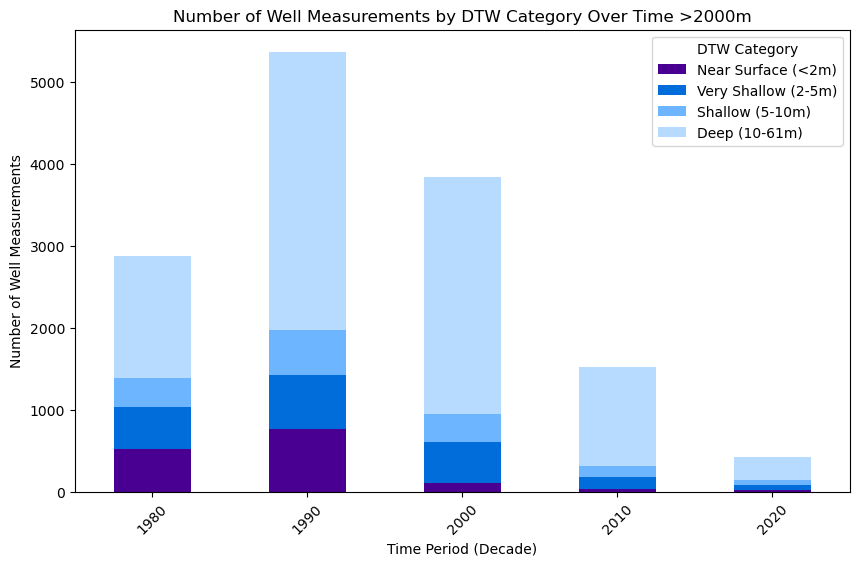

In [98]:
dist_plotting = ">2000m"

# Summing all HUCs together by Decade and DTW_Category
# summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()
summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()

# Pivot the data to get each DTW category as a separate column for stacking
summary_pivot = summary_table.pivot(index='Decade', columns='DTW_Category', values=f'{dist_plotting}').fillna(0)
# summary_pivot = boundaries_stats.pivot(index='Decade', columns='DTW_Category', values=f'Ratio{dist_plotting}').fillna(0)

# Define the desired order for DTW categories
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']

# Reorder the columns in summary_pivot
summary_pivot = summary_pivot[category_order]

# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)

# Labels and title
plt.xlabel('Time Period (Decade)')
plt.ylabel('Number of Well Measurements')
plt.title(f'Number of Well Measurements by DTW Category Over Time {dist_plotting}')
plt.legend(title='DTW Category')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


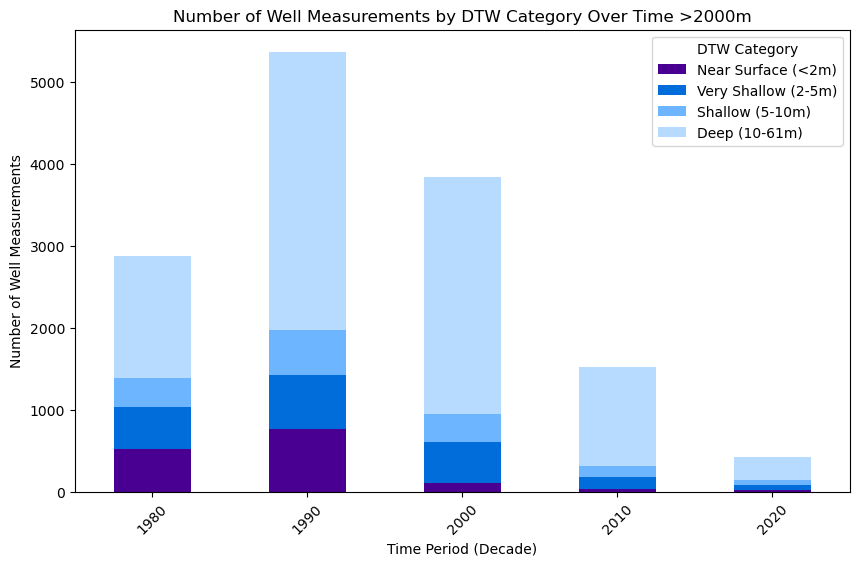

In [ ]:
dist_plotting = ">2000m"

# Summing all HUCs together by Decade and DTW_Category
# summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()
summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()

# Pivot the data to get each DTW category as a separate column for stacking
summary_pivot = summary_table.pivot(index='Decade', columns='DTW_Category', values=f'{dist_plotting}').fillna(0)
# summary_pivot = boundaries_stats.pivot(index='Decade', columns='DTW_Category', values=f'Ratio{dist_plotting}').fillna(0)

# Define the desired order for DTW categories
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']

# Reorder the columns in summary_pivot
summary_pivot = summary_pivot[category_order]

# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)

# Labels and title
plt.xlabel('Time Period (Decade)')
plt.ylabel('Number of Well Measurements')
plt.title(f'Number of Well Measurements by DTW Category Over Time {dist_plotting}')
plt.legend(title='DTW Category')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Now to compare changes across decades

In [145]:
avg_dtw = final_df.groupby(['huc8', 'Decade'])['DTW_meters'].median().reset_index()
avg_dtw

huc8  Decade  DTW_meters
0    15010001    1980     0.00000
1    15010001    1990     0.00000
2    15010001    2010     8.53440
3    15010002    1980     0.00000
4    15010002    1990     0.00000
..        ...     ...         ...
335  15080302    1980     9.09828
336  15080302    1990     8.97636
337  15080302    2000     9.23544
338  15080302    2010     9.17448
339  15080302    2020     8.62584

[340 rows x 3 columns]

In [ ]:
# Pivot the average DTW table to get decades as columns
pivot_dtw = avg_dtw.pivot(index='huc8', columns='Decade', values='DTW_meters')

# Rename the columns for clarity (optional)
pivot_dtw.columns = [f"{decade}s" for decade in pivot_dtw.columns]

# Calculate change between decades
dtw_change = pd.DataFrame(index=pivot_dtw.index)
dtw_change["80s vs 90s"] = pivot_dtw["1990s"] - pivot_dtw["1980s"]
dtw_change["90s vs 00s"] = pivot_dtw["2000s"] - pivot_dtw["1990s"]
dtw_change["00s vs 10s"] = pivot_dtw["2010s"] - pivot_dtw["2000s"]
dtw_change["10s vs 20s"] = pivot_dtw["2020s"] - pivot_dtw["2010s"]

dtw_change


80s vs 90s  90s vs 00s  00s vs 10s  10s vs 20s
huc8                                                    
15010001    0.000000         NaN         NaN         NaN
15010002         NaN         NaN         NaN         NaN
15010003    4.572000    3.657600    2.133600         NaN
15010004    2.743200    1.219200   11.277600  -13.380720
15010005    8.930640   27.035760   -0.335280   -0.822960
...              ...         ...         ...         ...
15080101         NaN         NaN         NaN         NaN
15080102    0.512064   11.137392    3.755136  -17.995392
15080200    1.444752    0.441960    3.489960  -21.396960
15080301   -2.895600    0.091440    0.944880    0.243840
15080302   -0.091440    0.243840   -0.091440   -0.548640

[74 rows x 4 columns]

In [ ]:
# dtw_change = dtw_change.reset_index()
# dtw_change.to_csv(outputpath+f'{StudyArea}_medianDTWChange.csv')

In [ ]:
# And now for 2000m close to streams
avg_dtw = melted_distances['2000m'].groupby(['huc8', 'Decade'])['DTW_meters'].median().reset_index()

# Pivot the average DTW table to get decades as columns
pivot_dtw = avg_dtw.pivot(index='huc8', columns='Decade', values='DTW_meters')

# Rename the columns for clarity (optional)
pivot_dtw.columns = [f"{decade}s" for decade in pivot_dtw.columns]

# Calculate change between decades
dtw_change = pd.DataFrame(index=pivot_dtw.index)
dtw_change["80s vs 90s"] = pivot_dtw["1990s"] - pivot_dtw["1980s"]
dtw_change["90s vs 00s"] = pivot_dtw["2000s"] - pivot_dtw["1990s"]
dtw_change["00s vs 10s"] = pivot_dtw["2010s"] - pivot_dtw["2000s"]
dtw_change["10s vs 20s"] = pivot_dtw["2020s"] - pivot_dtw["2010s"]
# dtw_change = dtw_change.reset_index()
dtw_change

huc8  80s vs 90s  90s vs 00s  00s vs 10s  10s vs 20s
0   15010001    0.000000         NaN         NaN         NaN
1   15010002         NaN         NaN         NaN         NaN
2   15010003    4.572000    3.657600    2.133600         NaN
3   15010004    2.743200    1.219200   11.277600  -13.380720
4   15010005    8.930640   27.035760   -0.335280   -0.822960
..       ...         ...         ...         ...         ...
69  15080101         NaN         NaN         NaN         NaN
70  15080102    0.512064   11.137392    3.755136  -17.995392
71  15080200    1.444752    0.441960    3.489960  -21.396960
72  15080301   -2.895600    0.091440    0.944880    0.243840
73  15080302   -0.091440    0.243840   -0.091440   -0.548640

[74 rows x 5 columns]

In [ ]:
# dtw_change = dtw_change.reset_index()
# dtw_change.to_csv(outputpath+f'{StudyArea}_medianDTWChange_2000mfromStreams.csv')

In [154]:
# Define a function to label changes
def categorize_change(change, tolerance=0.1):
    if pd.isna(change):
        return "no data"
    elif change > tolerance:
        return "increased"
    elif change < -tolerance:
        return "decreased"
    else:
        return "no change"

# Apply to each column
qualitative_change = dtw_change.applymap(categorize_change)


In [155]:
qualitative_change

80s vs 90s 90s vs 00s 00s vs 10s 10s vs 20s
huc8                                                
15010001  no change    no data    no data    no data
15010002    no data    no data    no data    no data
15010003  increased  increased  increased    no data
15010004  increased  increased  increased  decreased
15010005  increased  increased  decreased  decreased
...             ...        ...        ...        ...
15080101    no data    no data    no data    no data
15080102  increased  increased  increased  decreased
15080200  increased  increased  increased  decreased
15080301  decreased  no change  increased  increased
15080302  no change  increased  no change  decreased

[74 rows x 4 columns]

In [156]:
qualitative_change = qualitative_change.reset_index()
qualitative_change.to_csv(outputpath+f'{StudyArea}_QualitativeChange_2000mfromStreams.csv')

Creating pie charts

In [124]:
# Count measurements by decade and distance category
counts = final_df.groupby(['Decade', 'Distance_to_Stream']).size().unstack(fill_value=0)

# Normalize to get percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
percentages

Distance_to_Stream     0-100m   100-500m  1000-1500m  1500-2000m  500-1000m  \
Decade                                                                        
1980                13.581295  32.648324    8.837183    6.929348  16.779891   
1990                13.557607  28.856288    9.042620    6.108511  13.405843   
2000                13.156356  30.592913    9.484271    6.028535  14.992399   
2010                16.779432  31.289685    8.910170    6.453628  13.146664   
2020                16.751269  34.731499    9.537804    5.557040  14.961261   

Distance_to_Stream     >2000m  
Decade                         
1980                21.223958  
1990                29.029130  
2000                25.745527  
2010                23.420423  
2020                18.461127

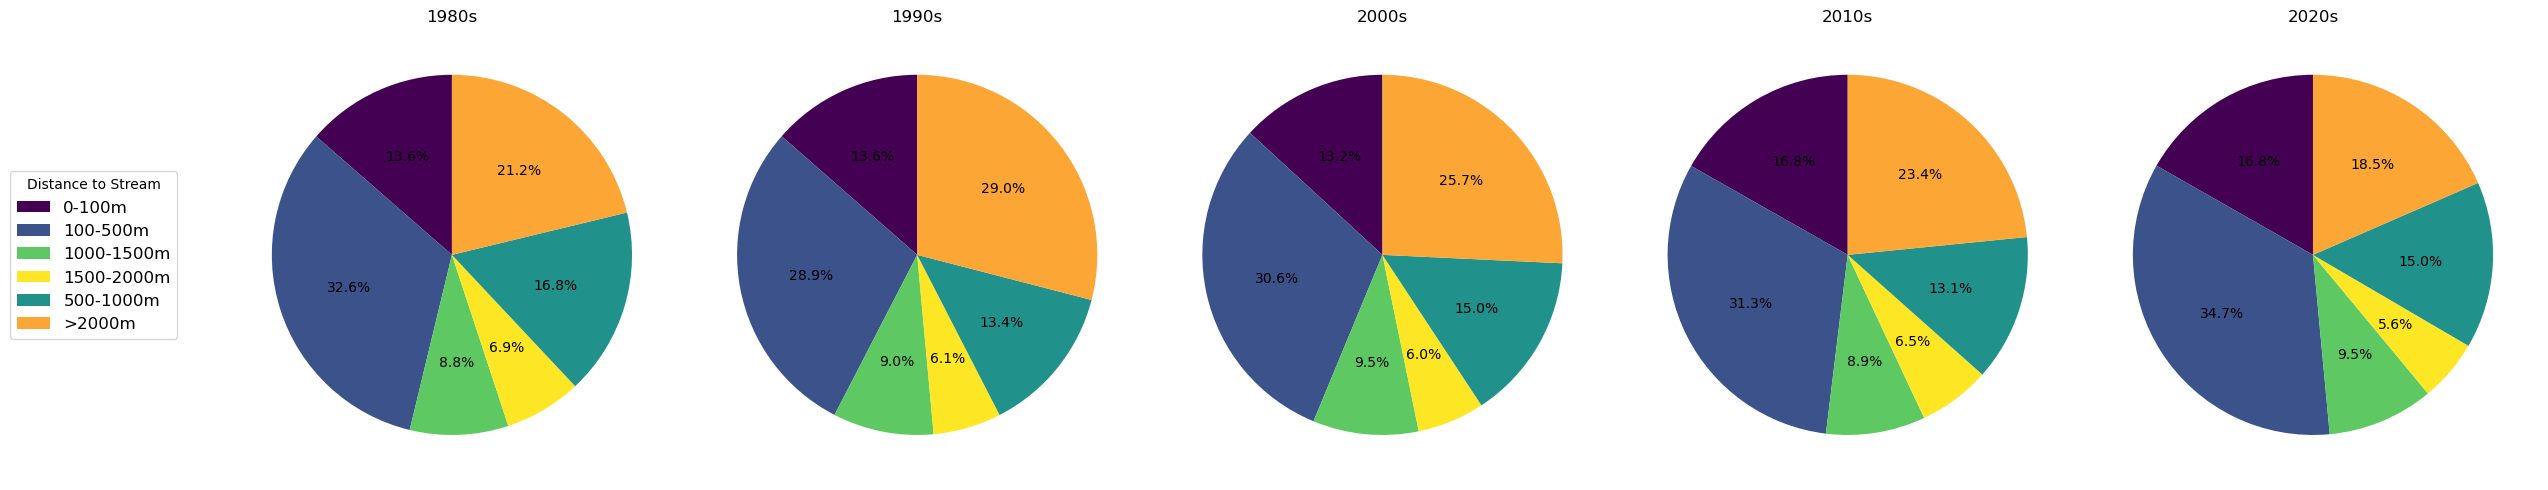

In [143]:
reorder_percentages = pd.DataFrame()
reorder_percentages['0-100m']=percentages['0-100m']
reorder_percentages['100-500m']=percentages['100-500m']
reorder_percentages['500-1000m']=percentages['500-1000m']
reorder_percentages['1000-1500m']=percentages['1000-1500m']
reorder_percentages['1500-2000m']=percentages['1500-2000m']
reorder_percentages['>2000m']=percentages['>2000m']
reorder_percentages
# Create subplots: one pie chart per decade
fig, axes = plt.subplots(1, len(percentages), figsize=(5 * len(percentages), 5))

for i, (decade, row) in enumerate(percentages.iterrows()):
    # Get colors in the right order
    colors = [custom_palette[label] for label in row.index]

    # Make pie without labels
    wedges, texts, autotexts = axes[i].pie(
        row,
        labels=None,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )
    
    axes[i].set_title(f"{decade}s")

    # Add legend once (or to each chart if you prefer)
    if i == 0:
        axes[i].legend(wedges, row.index, title="Distance to Stream", loc="center left",
                       fontsize = 12, bbox_to_anchor=(-0.5, 0.5))

plt.tight_layout()
plt.show()


This is old code, ignoring/archiving for now

In [39]:

df = boundaries_percents
listofhucs = df[Naming_col].unique().tolist()
num_hucs = len(listofhucs)

# Determine grid size
cols = math.ceil(math.sqrt(num_hucs))  # Try to make a roughly square grid
rows = math.ceil(num_hucs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), constrained_layout=True)

# Flatten axes if there's more than one row
if rows > 1 or cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Ensure it's iterable

for i, bitch in enumerate(listofhucs):
    subset = df[df[Naming_col] == bitch]
    summary_df_huc = subset.groupby(['Decade', 'DTW_Category'])
    # summary_df_huc.rename(columns={'Combo_ID': 'Well Count'}, inplace=True)
    summary_pivot = summary_df_huc.pivot(index='Decade', columns='DTW_Category', values='Well Count').fillna(0)
    summary_pivot = summary_pivot[category_order]
    fig, ax = plt.subplots(figsize=(10, 6))
    summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)
    ax.set_title(f'Distribution of Wells Over Time [HUC {bitch}]')
    ax.set_xlabel('Time Period (Decade)')
    ax.set_ylabel('Number of Well Measurements')
    ax.tick_params(axis='x', rotation=0)
    # axes[i].set_ylim(65, -5)

AttributeError: 'DataFrameGroupBy' object has no attribute 'pivot'

Error in callback <function flush_figures at 0x000002A16FB63550> (for post_execute):


KeyboardInterrupt: 

In [40]:
boundaries_melted

Combo_ID      huc8        Date    DTW  DTW_meters         DTW_Category  \
0        521955  15010001  1988-09-01    0.0     0.00000   Near Surface (<2m)   
1        521956  15010001  1988-09-01    0.0     0.00000   Near Surface (<2m)   
2        526708  15010001  1990-01-01    0.0     0.00000   Near Surface (<2m)   
3        526707  15010001  1990-02-01    0.0     0.00000   Near Surface (<2m)   
4        528959  15010001  1991-06-01  105.0    32.00400        Deep (10-61m)   
...         ...       ...         ...    ...         ...                  ...   
71832    552204  15080302  2020-11-01    9.9     3.01752  Very Shallow (2-5m)   
71833    616444  15080302  2020-11-01   31.5     9.60120      Shallow (5-10m)   
71834    616444  15080302  2021-11-01   29.9     9.11352      Shallow (5-10m)   
71835    616444  15080302  2022-11-01   29.0     8.83920      Shallow (5-10m)   
71836    616444  15080302  2023-11-01   31.7     9.66216      Shallow (5-10m)   

       Decade  
0        1980  
1        1980  
2        1990  
3        1990  
4        1990  
...       ...  
71832    2020  
71833    2020  
71834    2020  
71835    2020  
71836    2020  

[71837 rows x 7 columns]

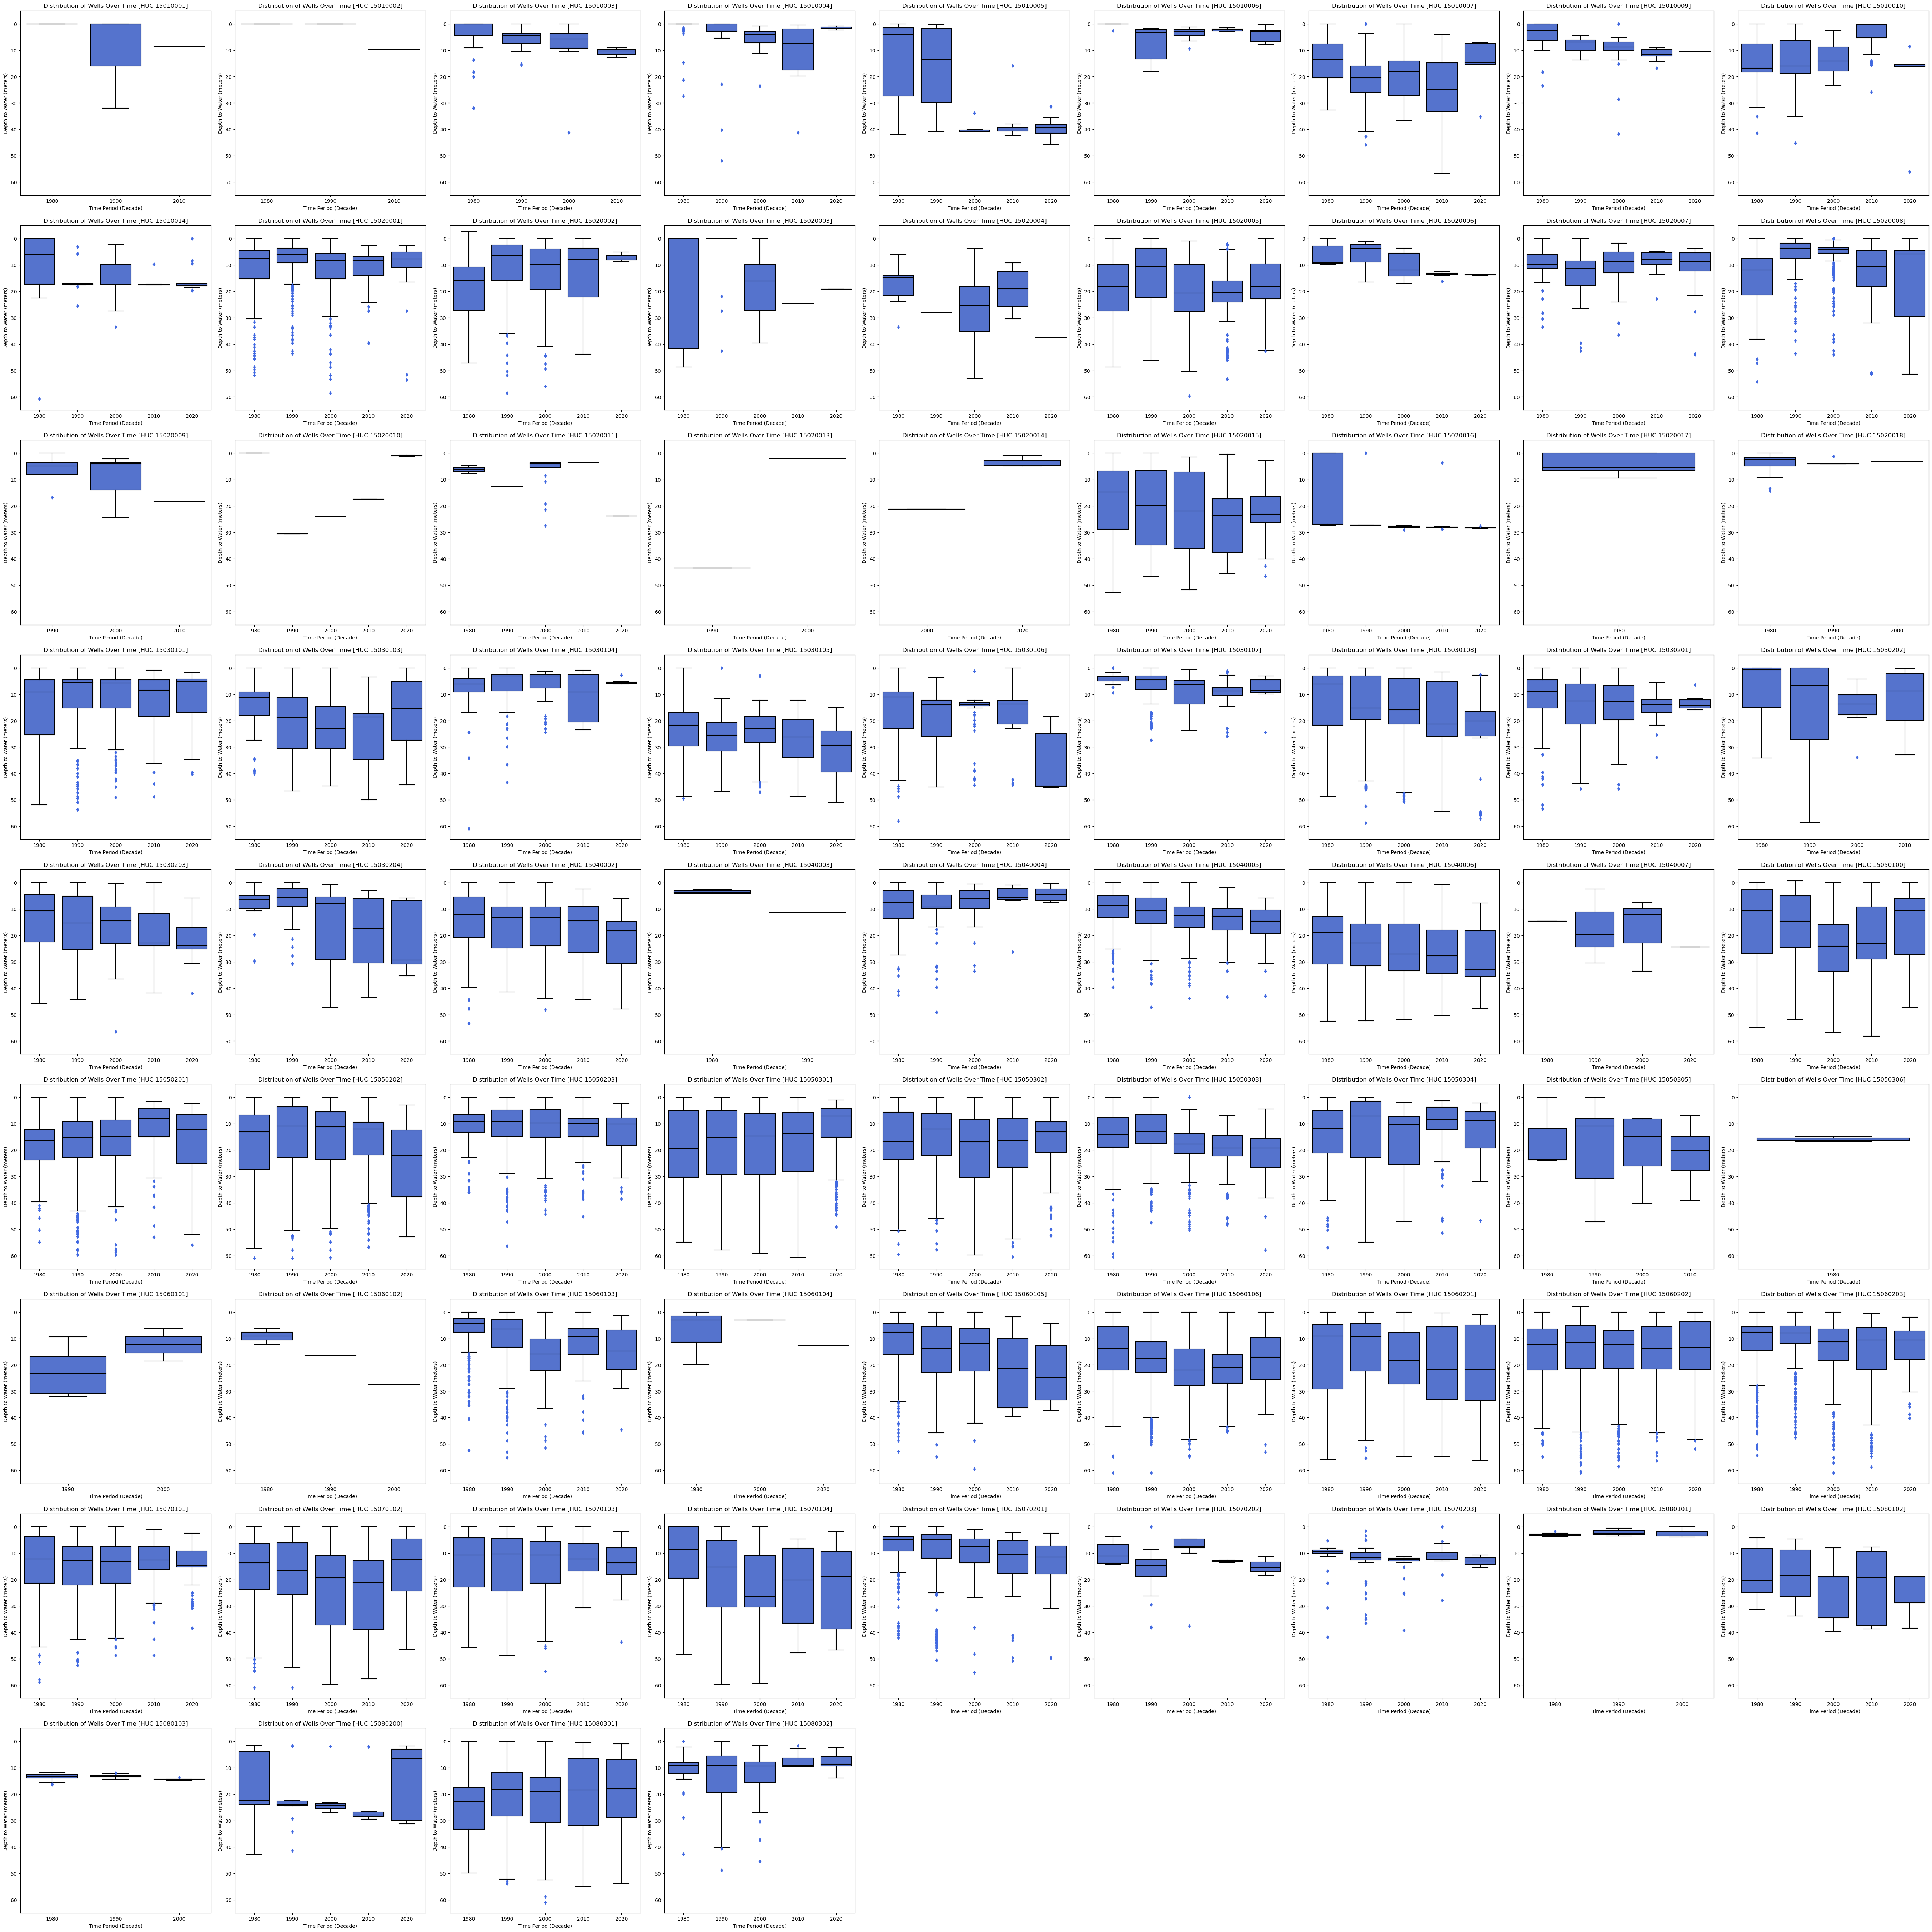

In [ ]:
listofhucs = boundaries_melted[Naming_col].unique().tolist()
num_hucs = len(listofhucs)

# Determine grid size
cols = math.ceil(math.sqrt(num_hucs))  # Try to make a roughly square grid
rows = math.ceil(num_hucs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), constrained_layout=True)

# Flatten axes if there's more than one row
if rows > 1 or cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Ensure it's iterable

# Define a single color for the boxes
box_color = "royalblue"

for i, bitch in enumerate(listofhucs):
    subset = boundaries_melted[boundaries_melted[Naming_col] == bitch]

    sns.boxplot(
        data=subset, 
        x='Decade',
        y='DTW_meters',
        color=box_color,
        ax=axes[i],  # Assign each plot to a subplot
        boxprops=dict(edgecolor="black"),
        medianprops=dict(color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(markerfacecolor=box_color, markeredgecolor=box_color)
    )

    axes[i].set_title(f'Distribution of Wells Over Time [HUC {bitch}]')
    axes[i].set_xlabel('Time Period (Decade)')
    axes[i].set_ylabel('Depth to Water (meters)')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].set_ylim(65, -5)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


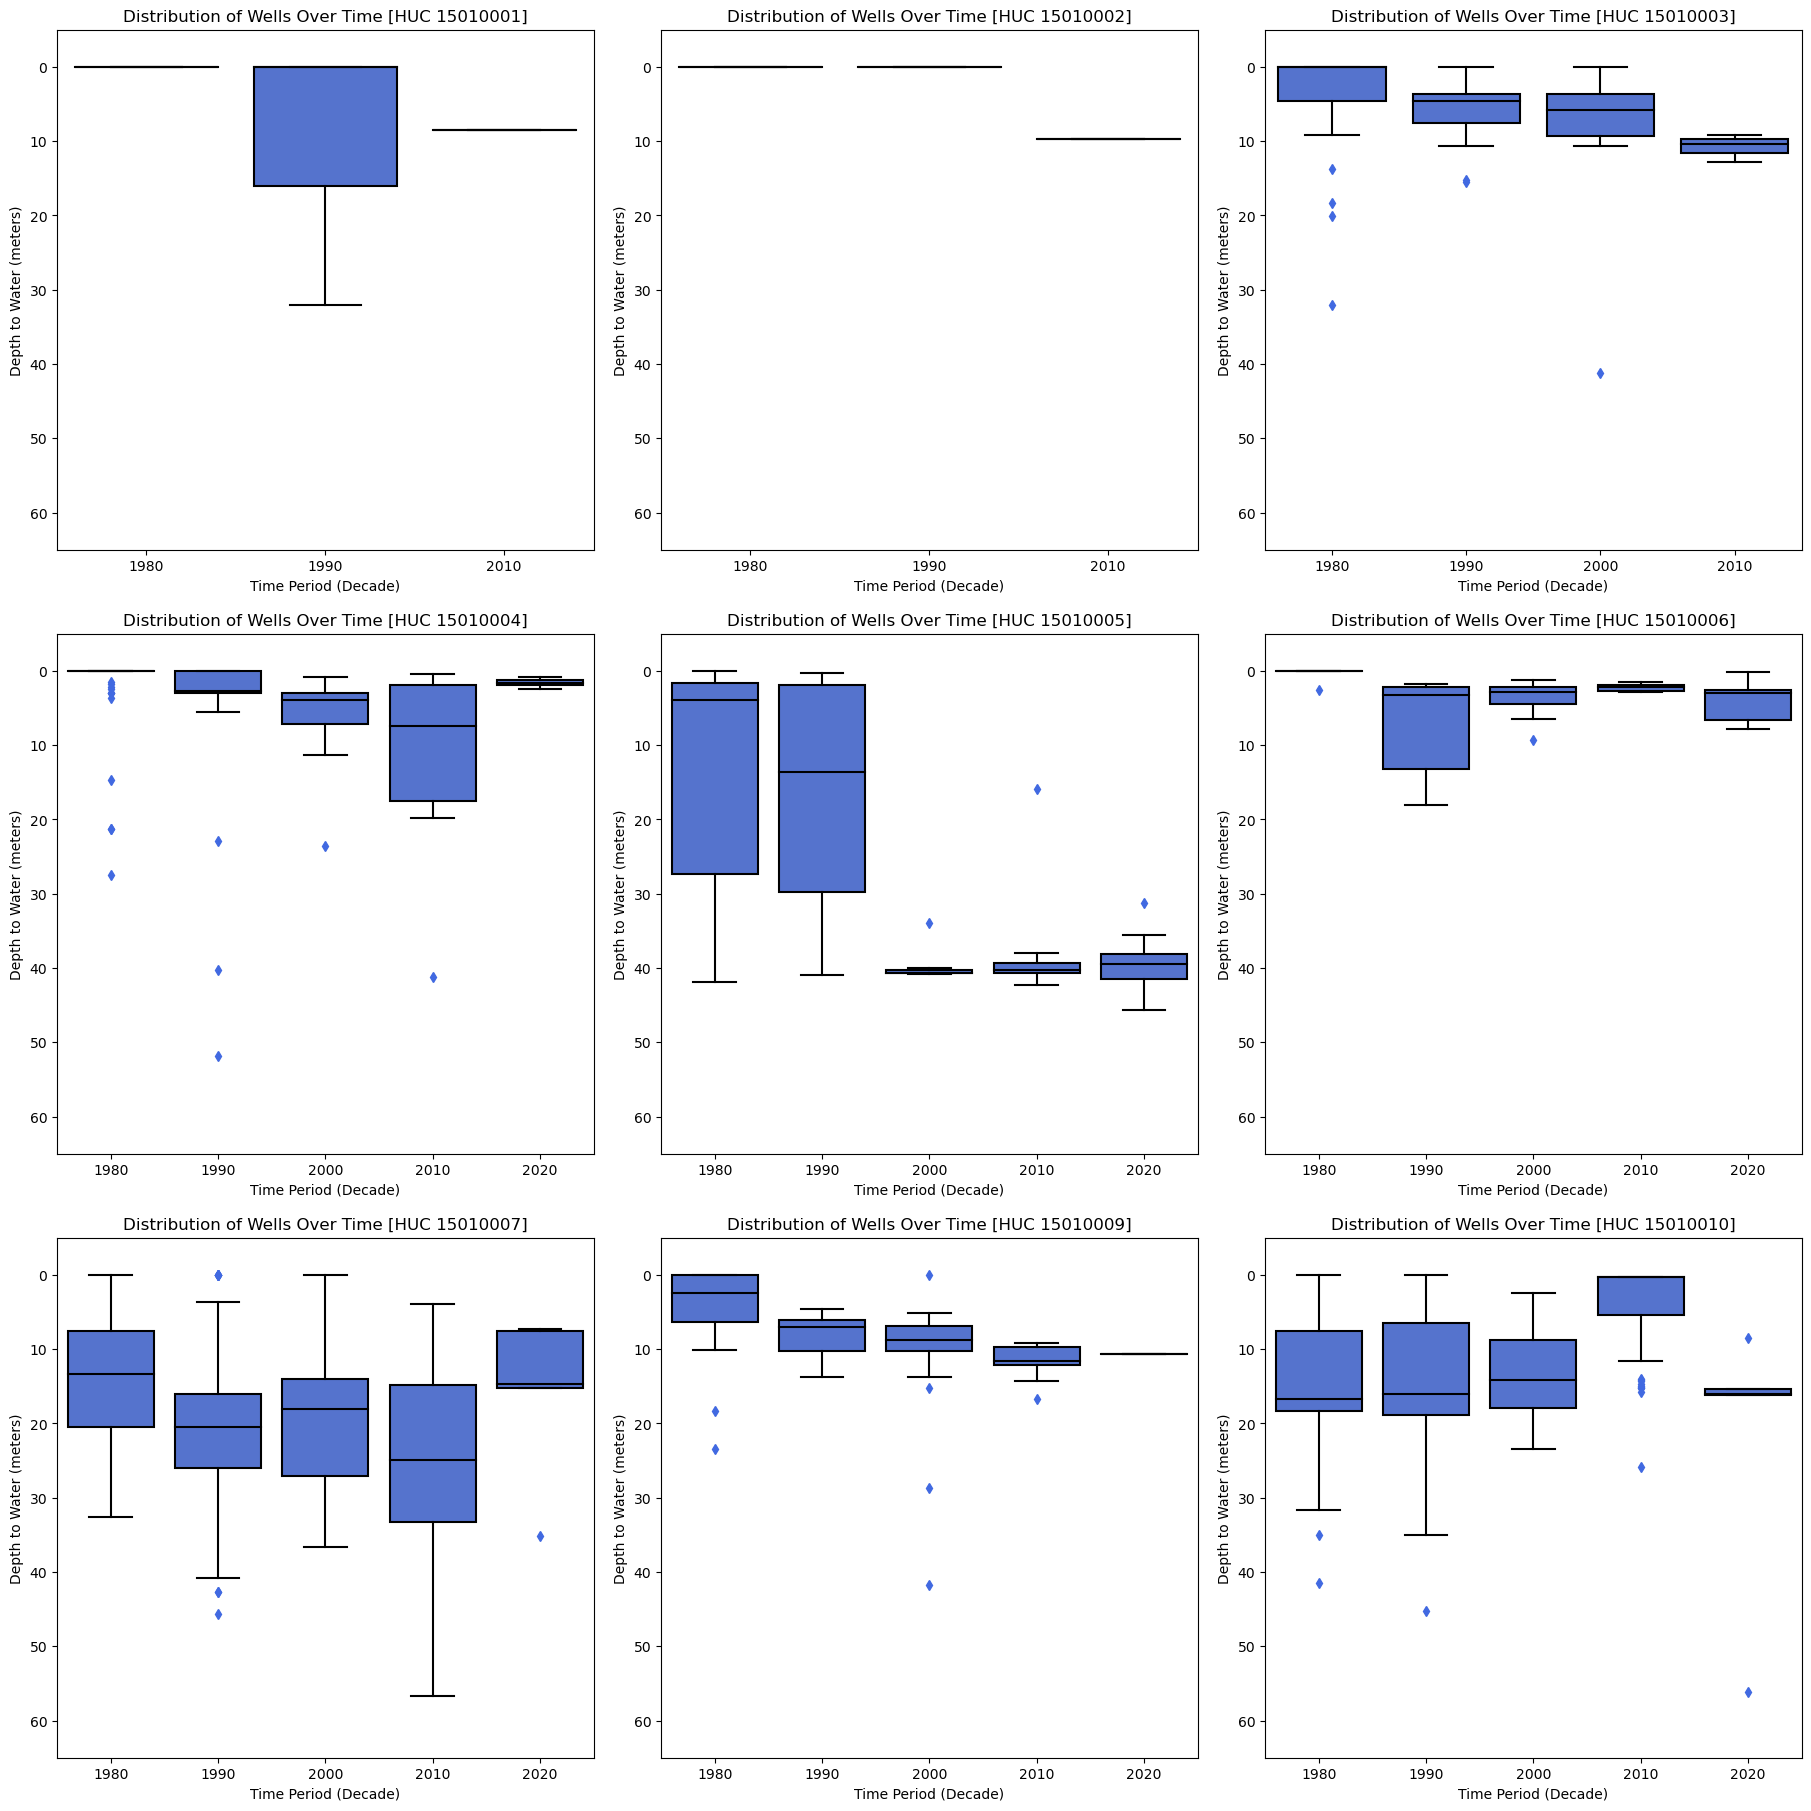

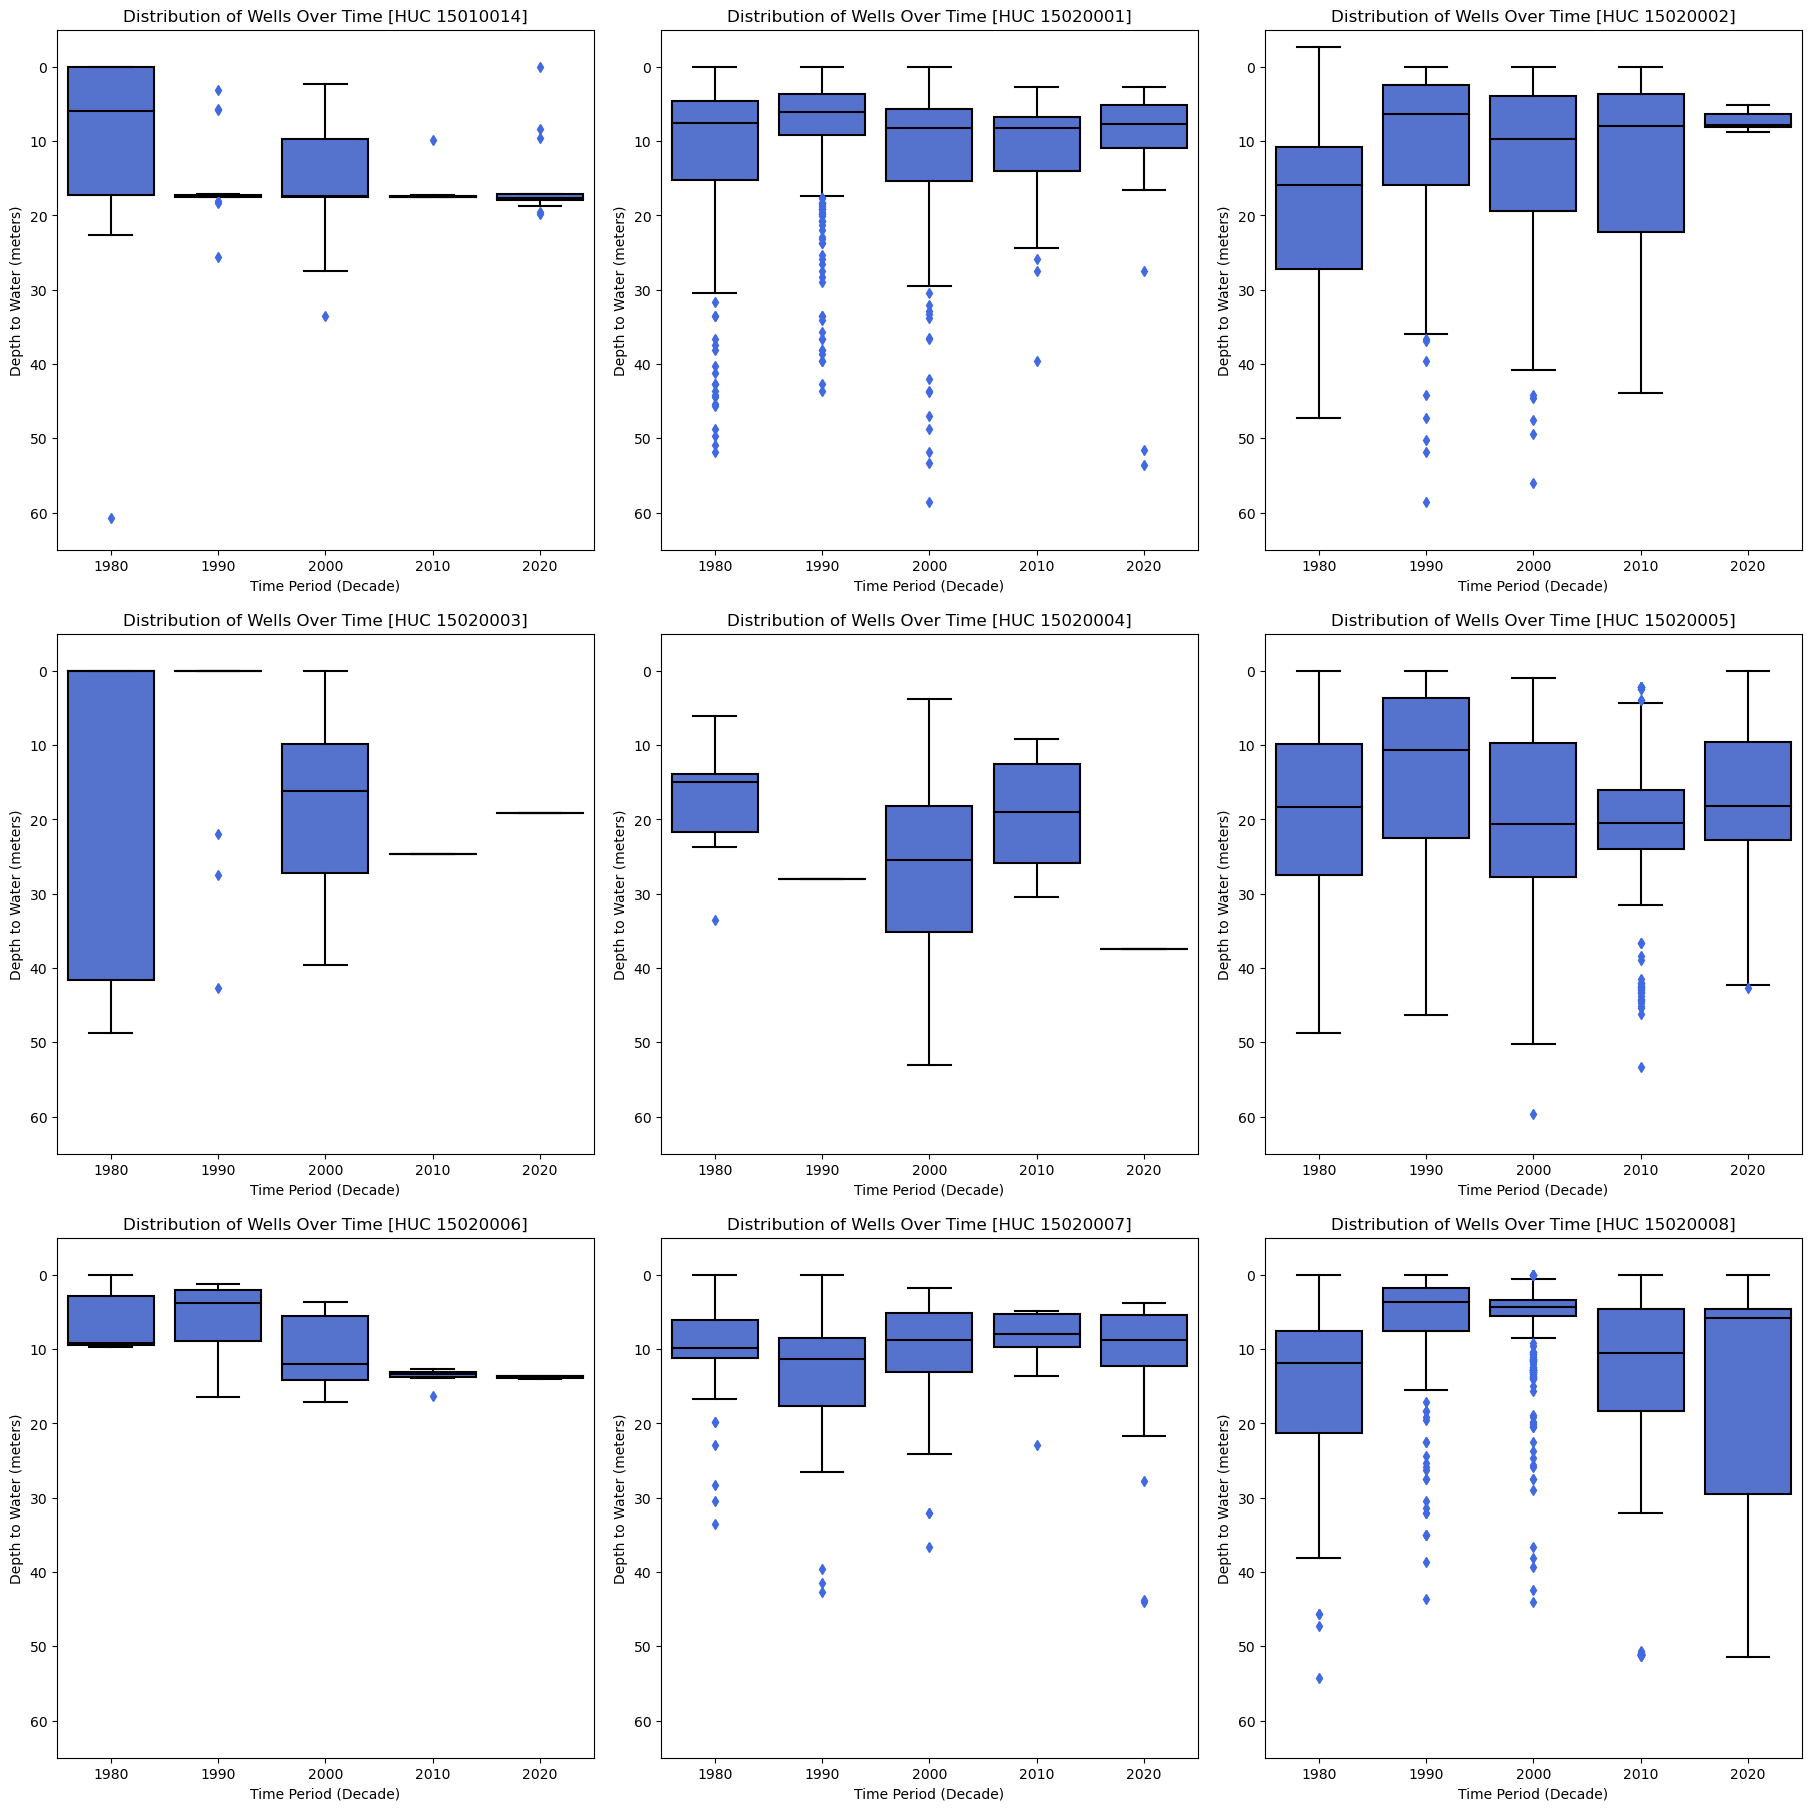

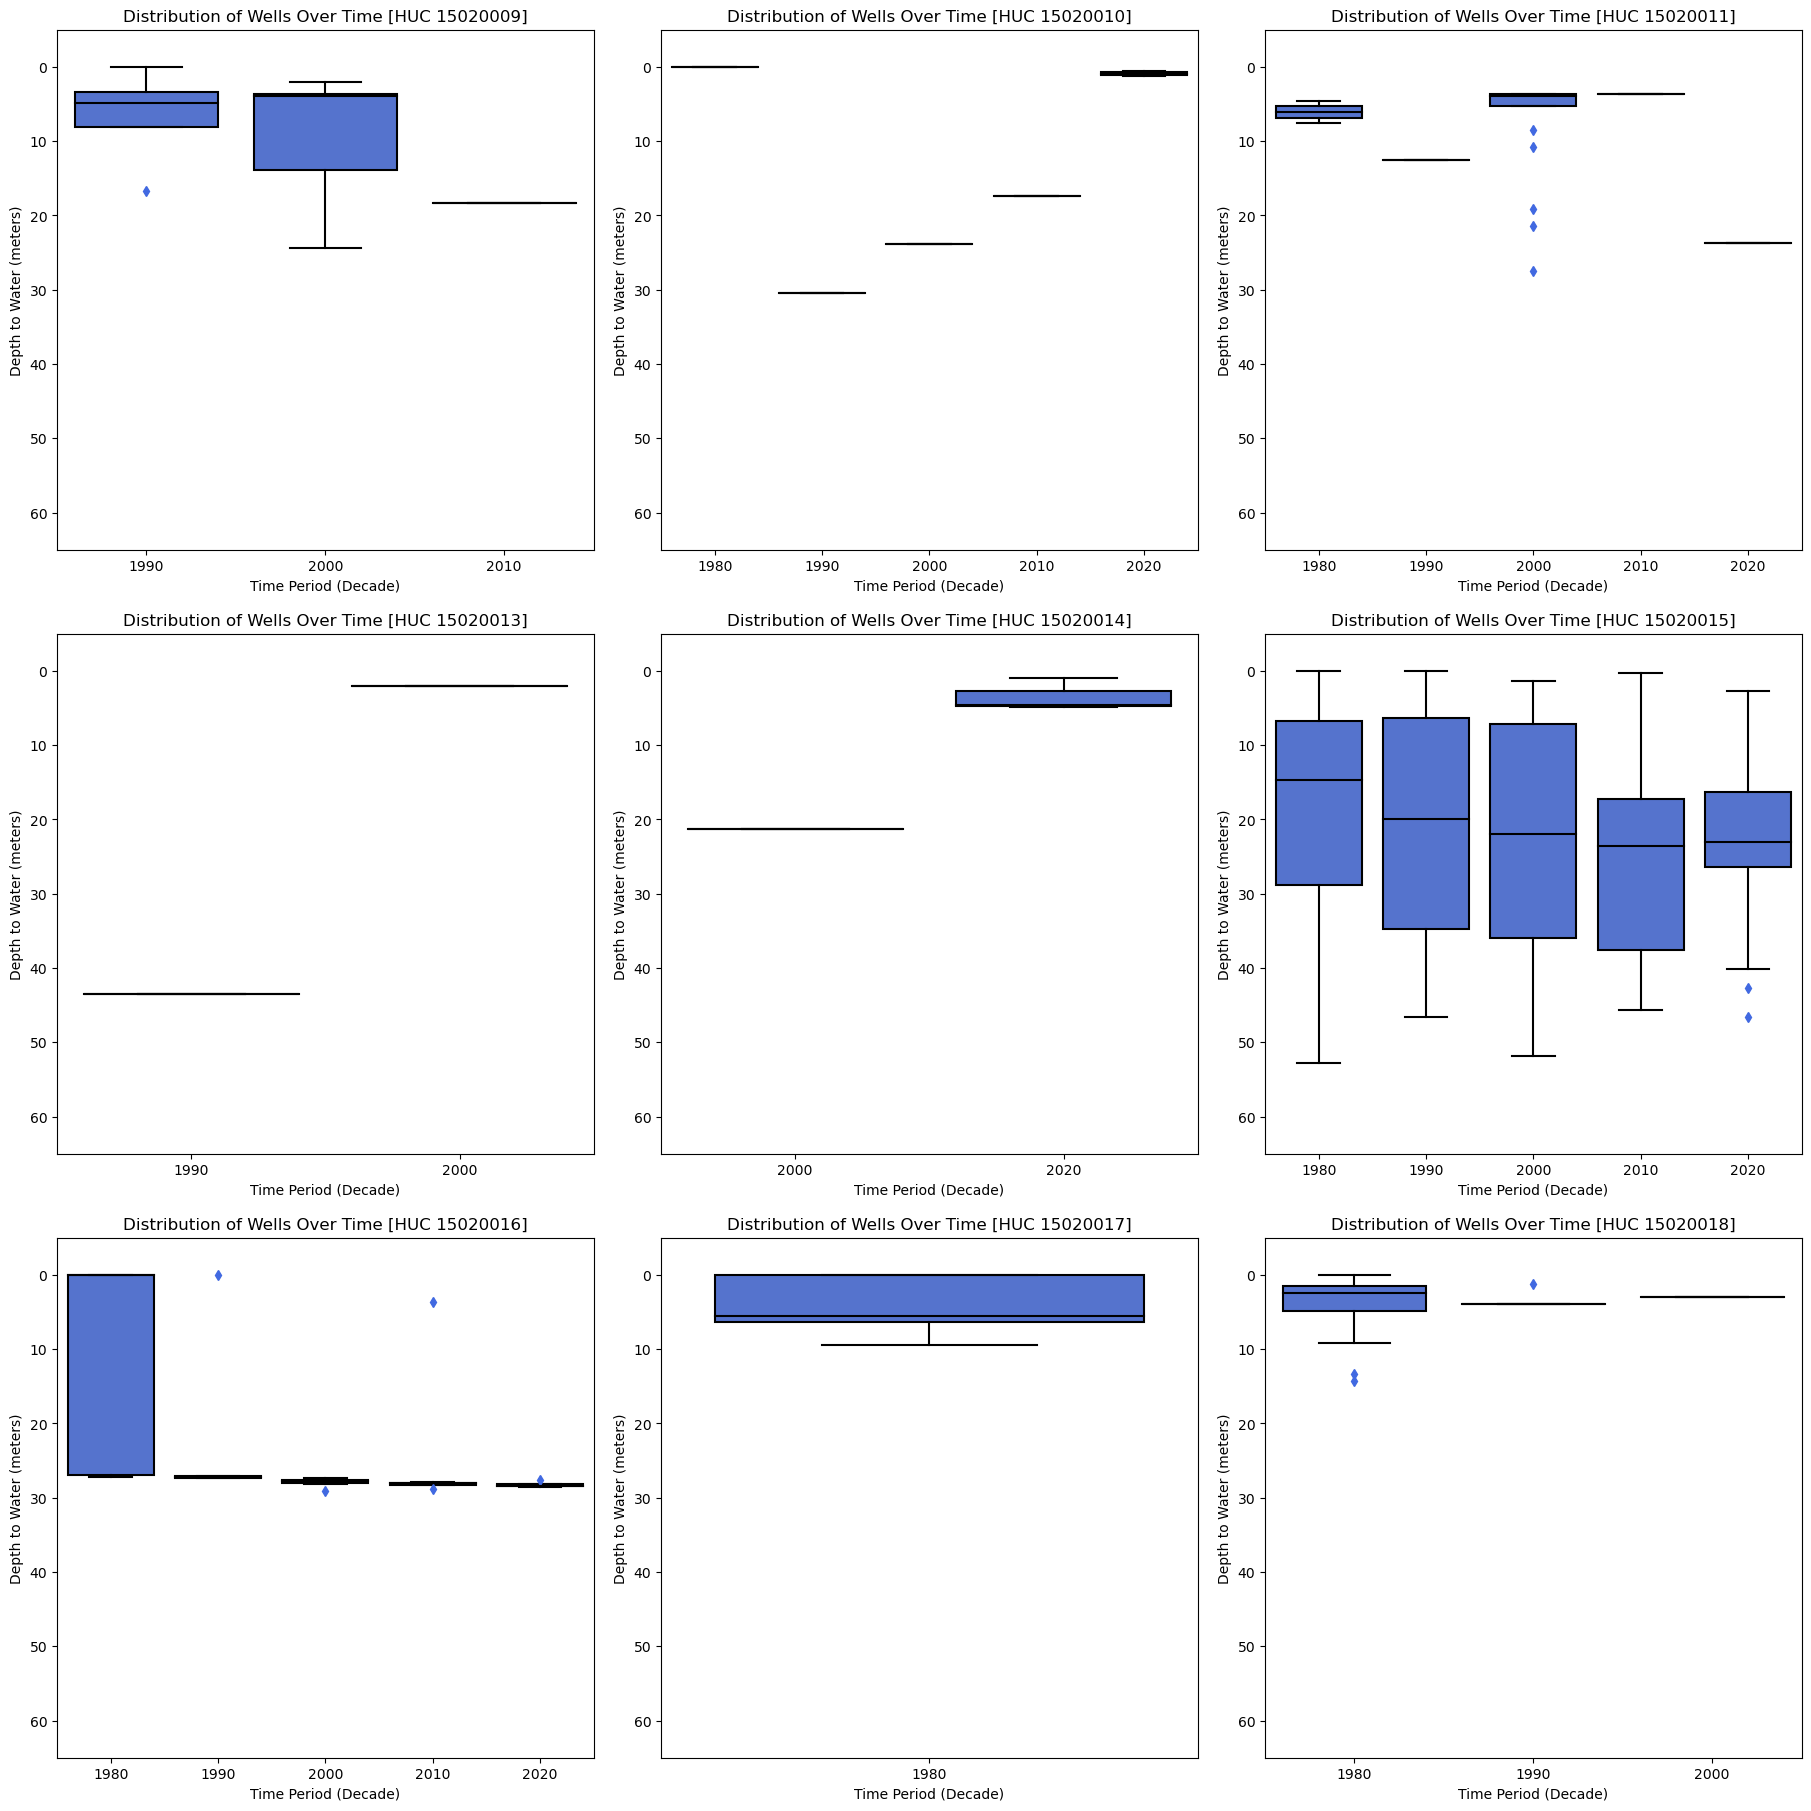

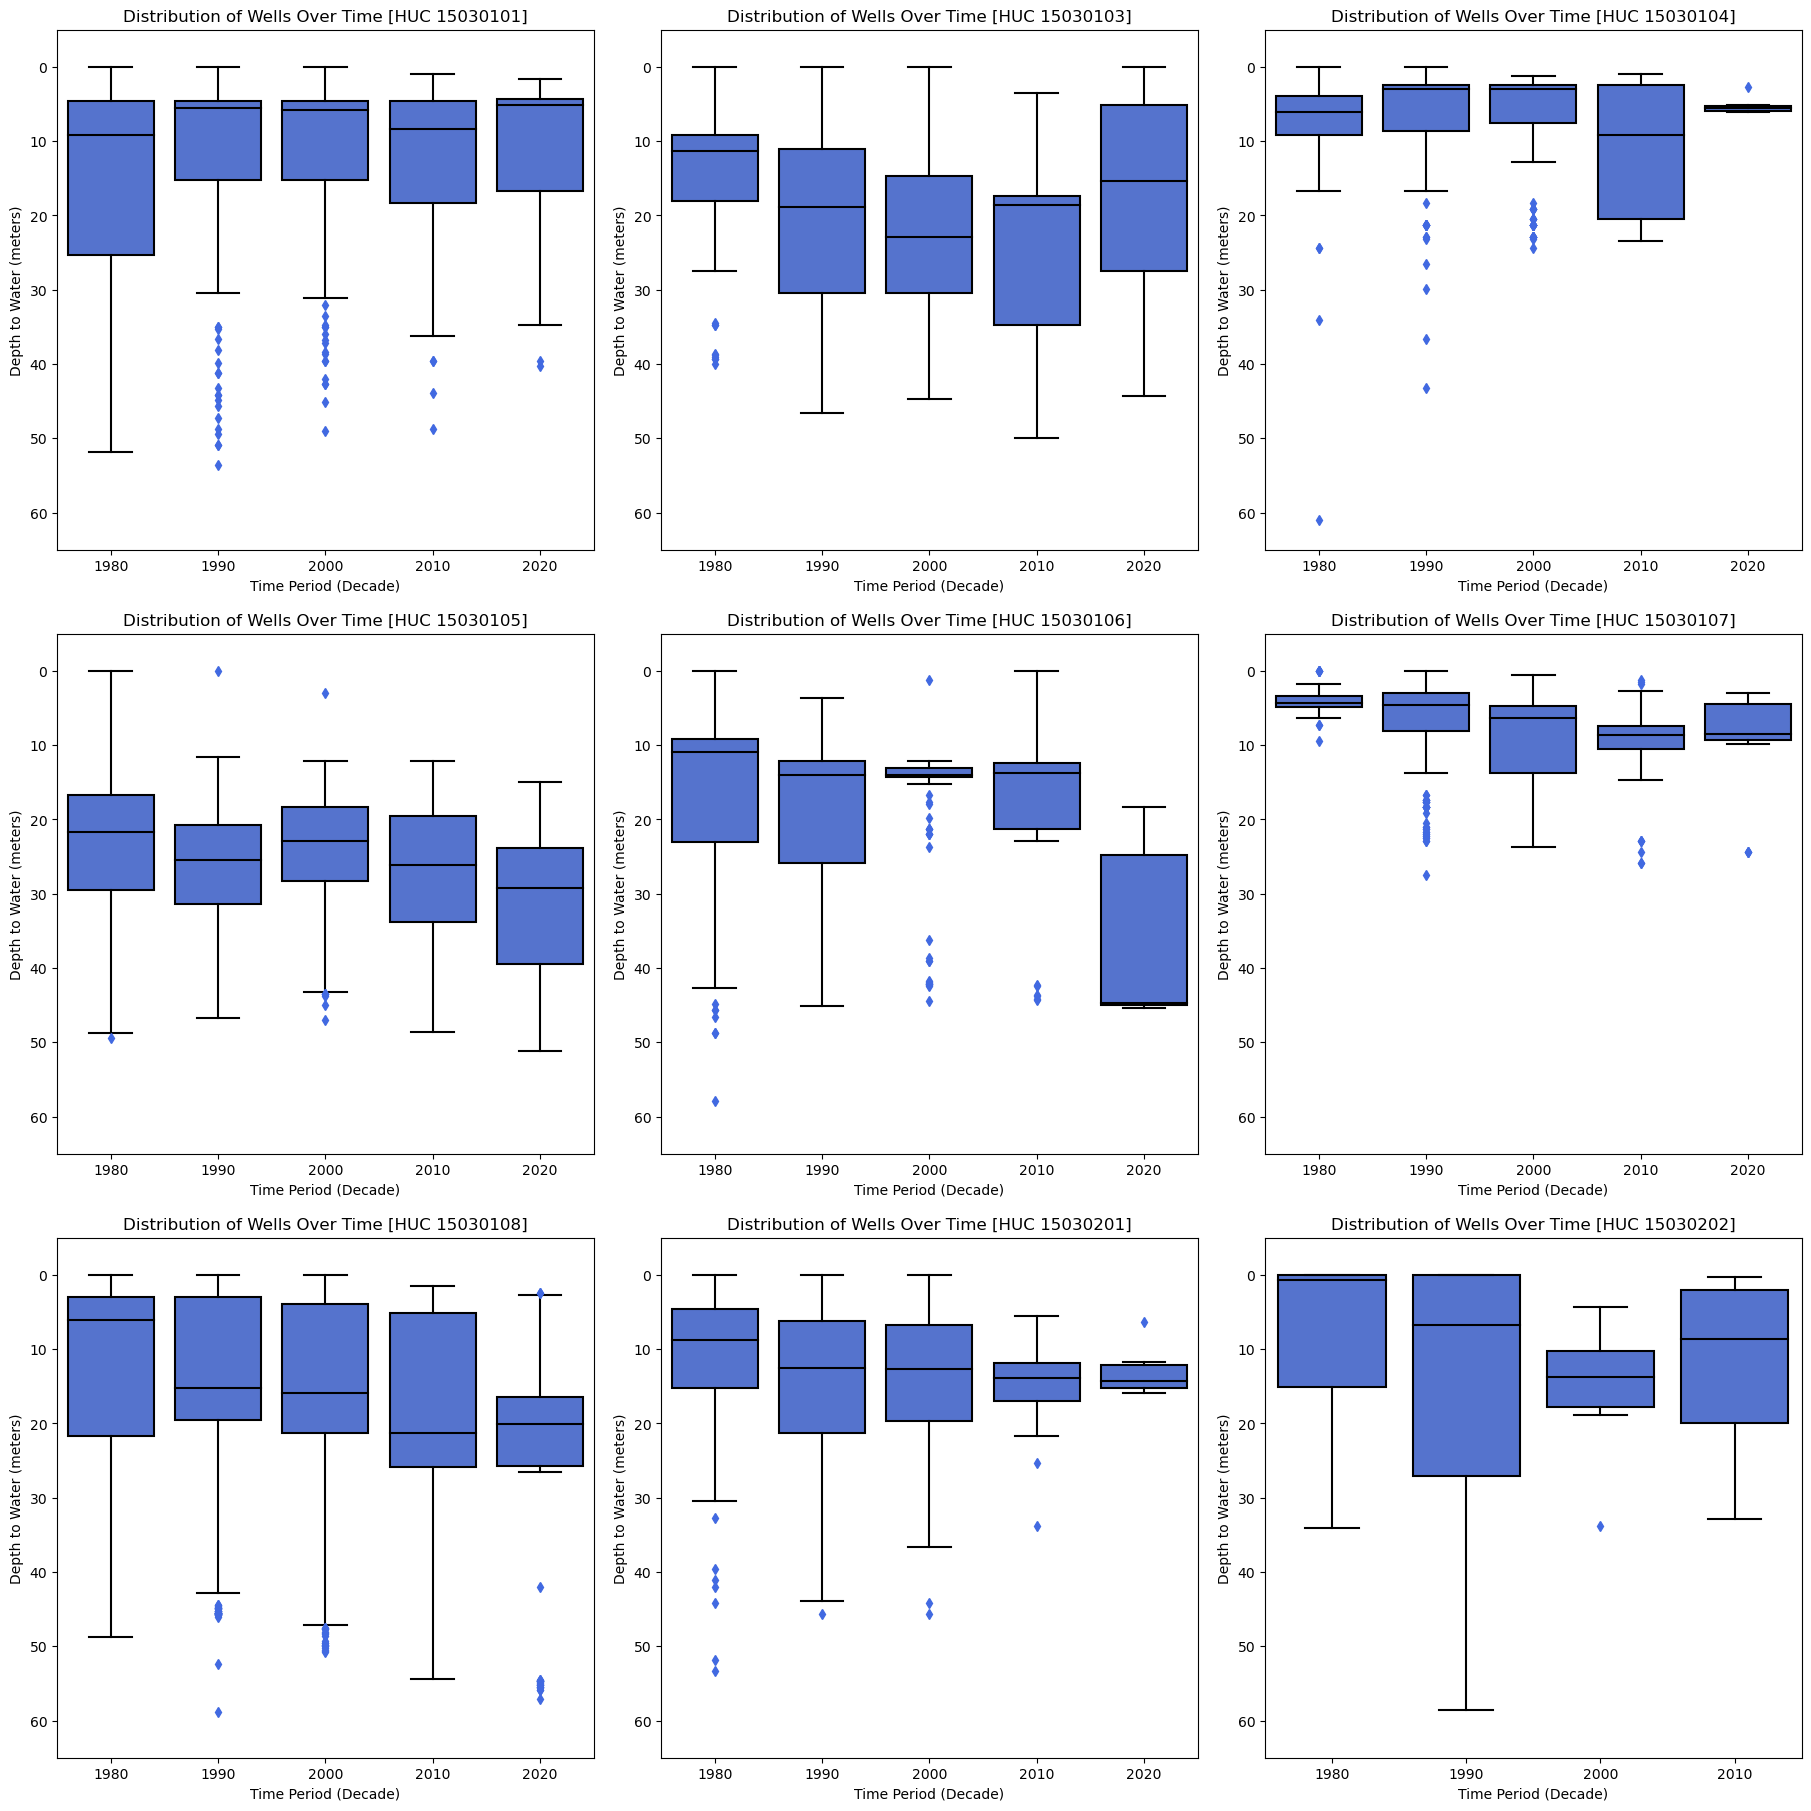

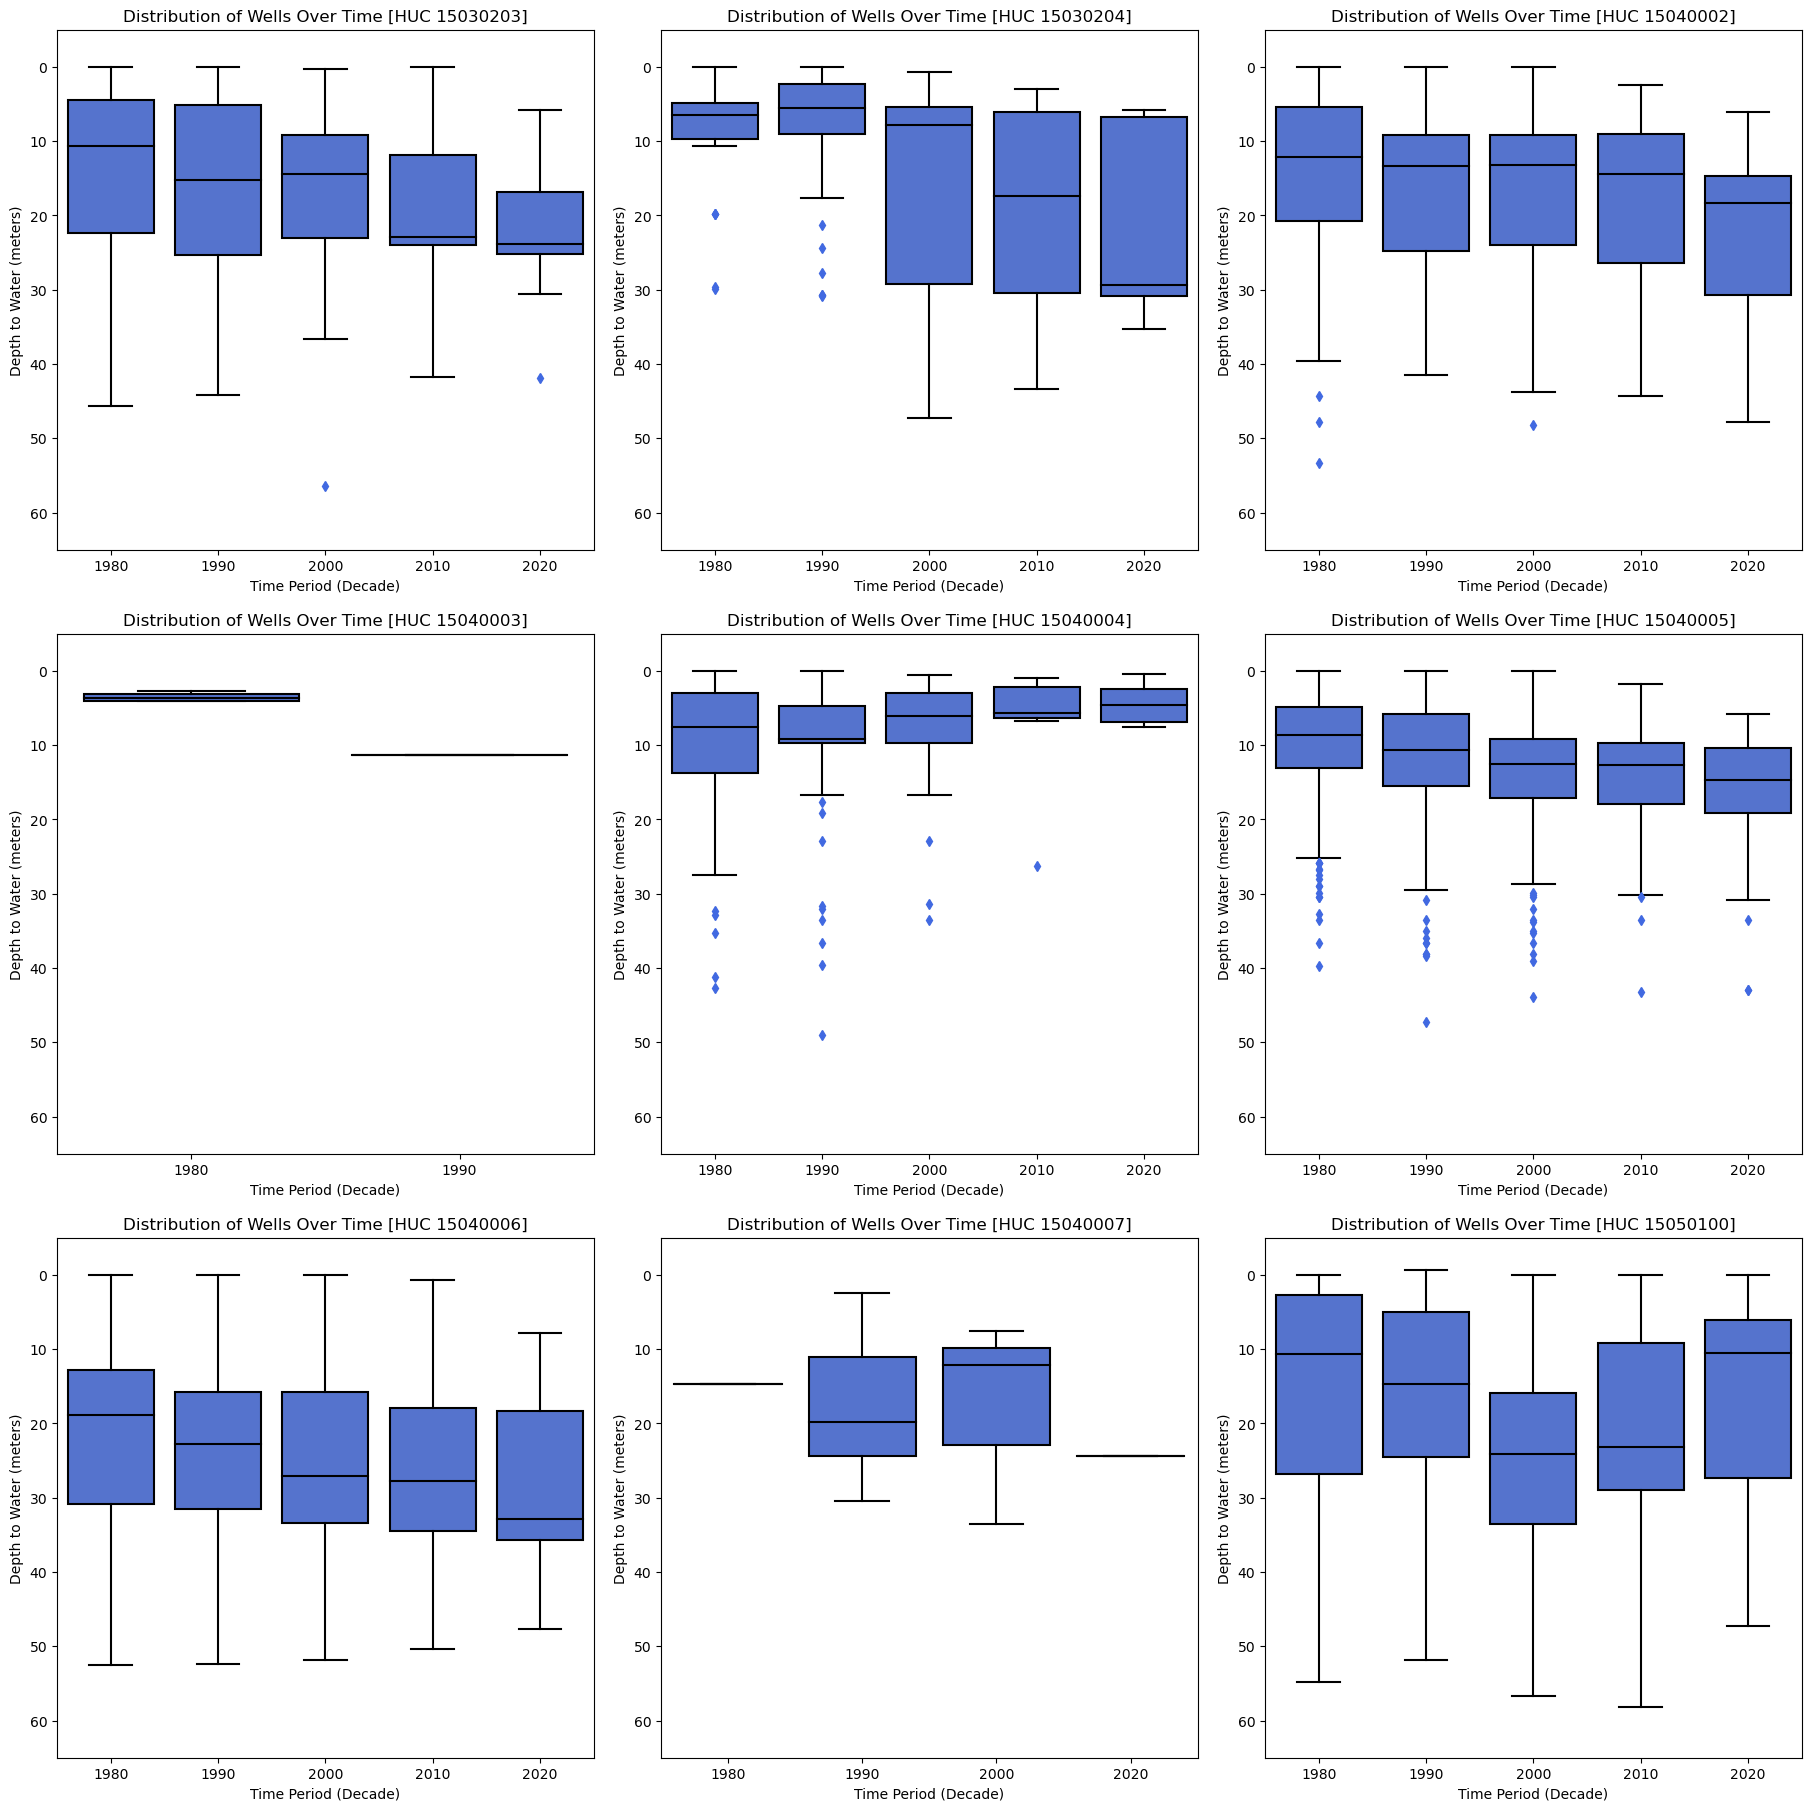

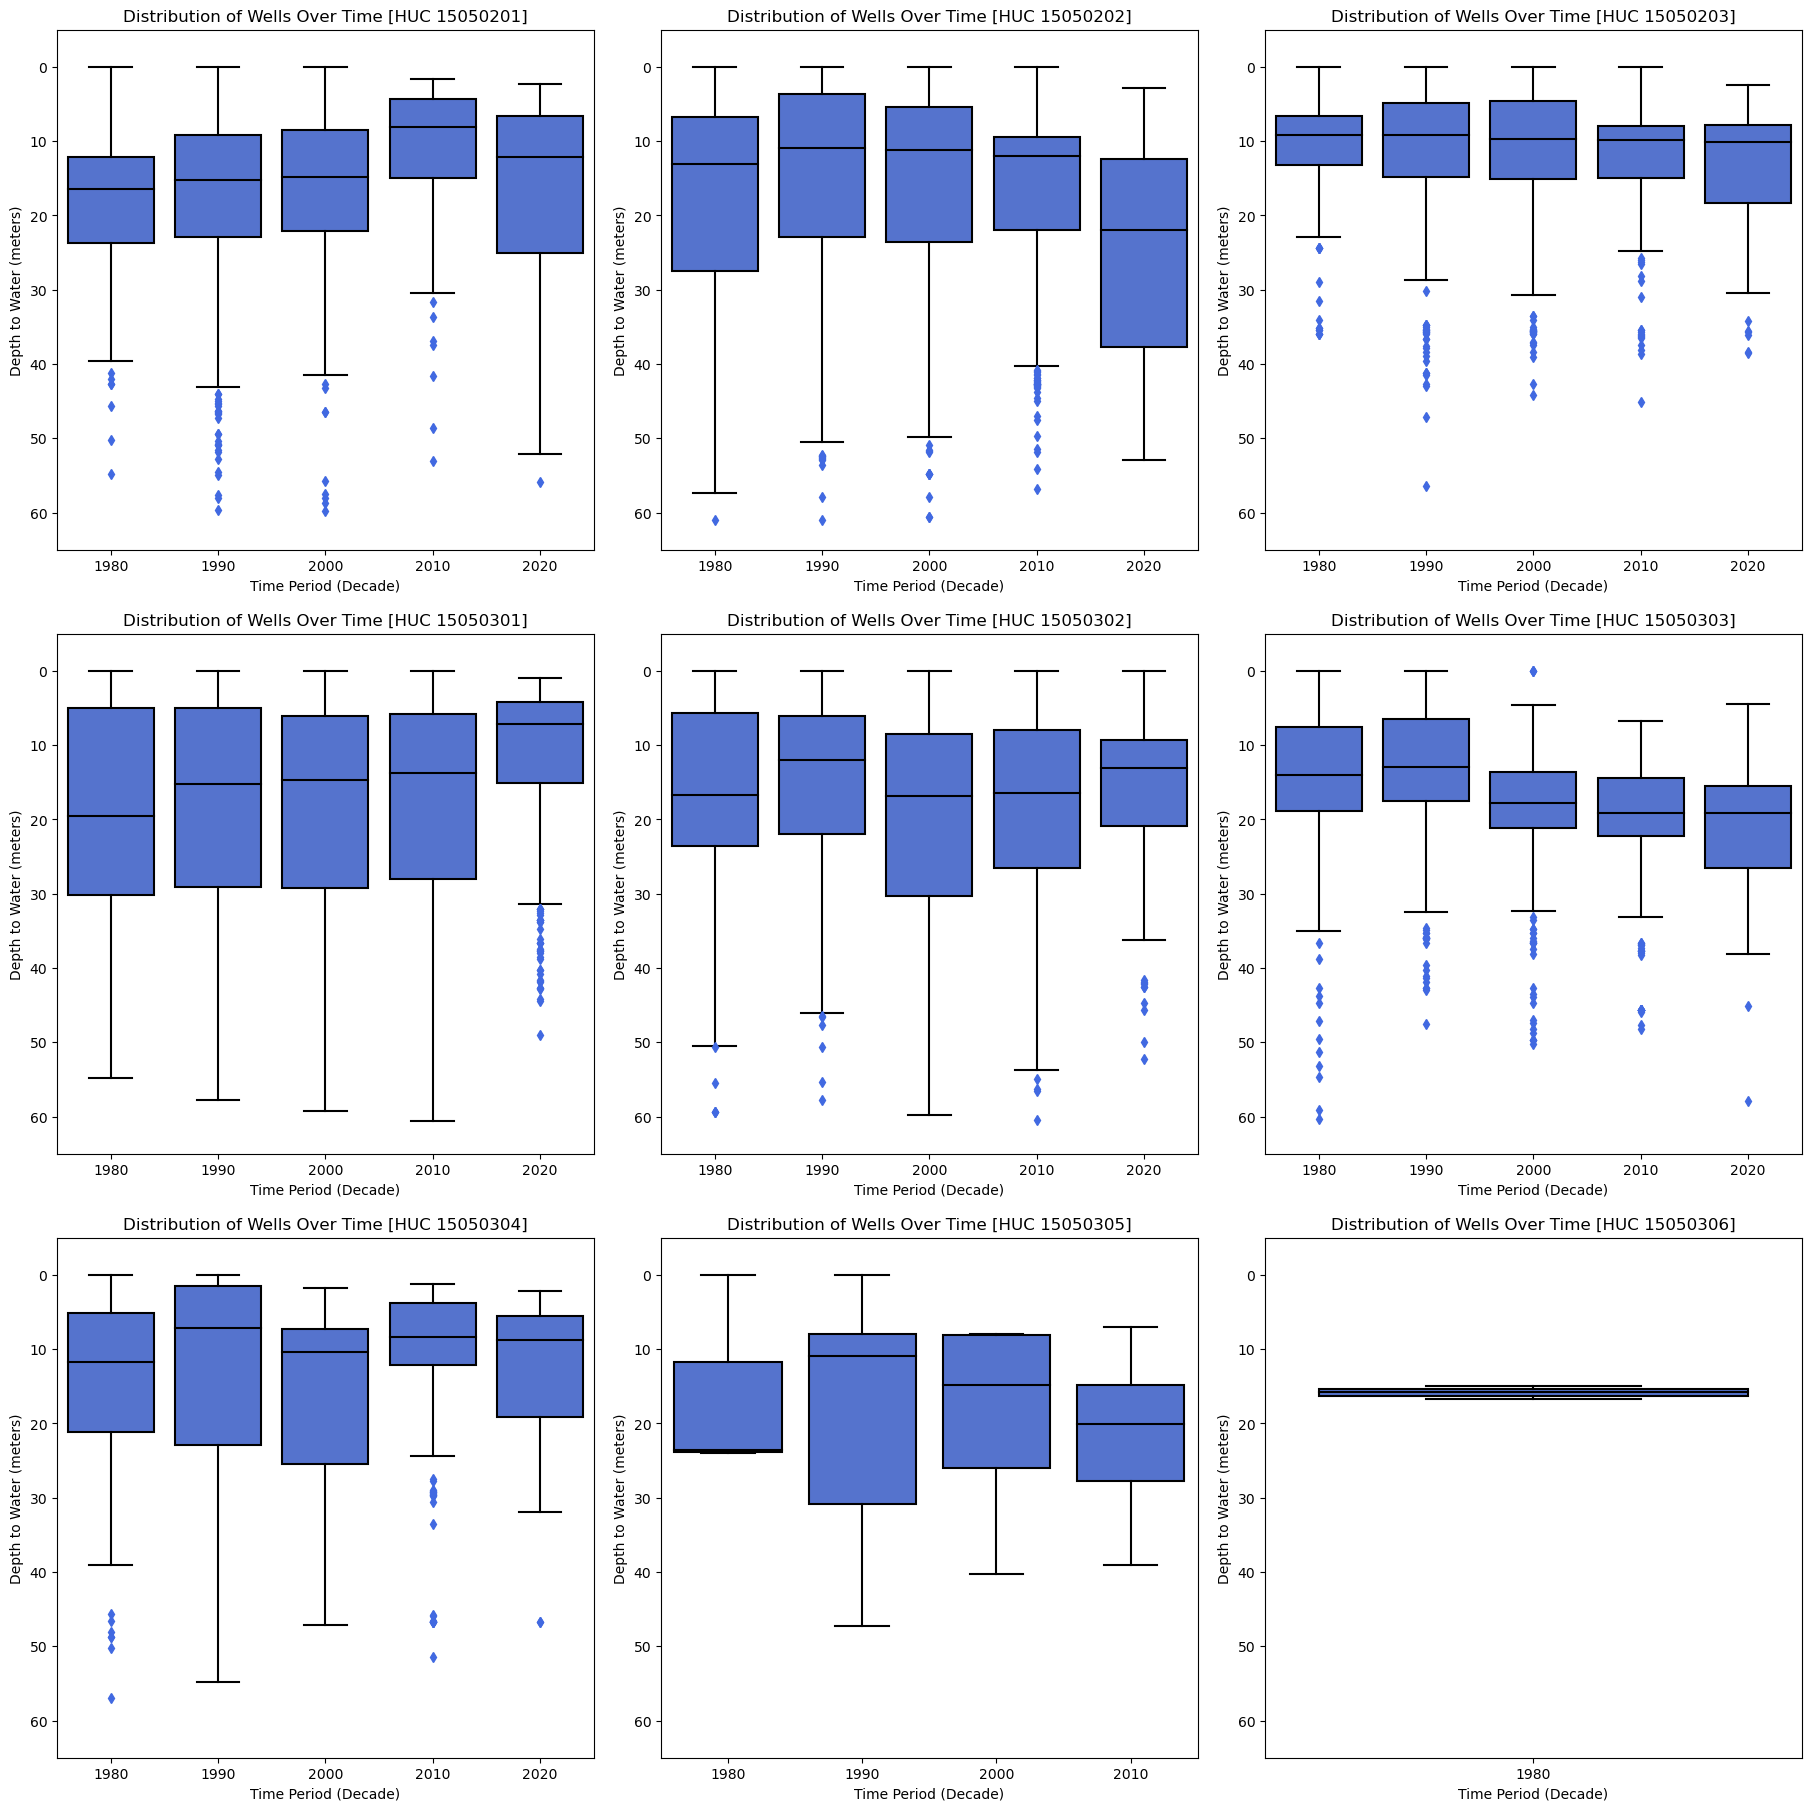

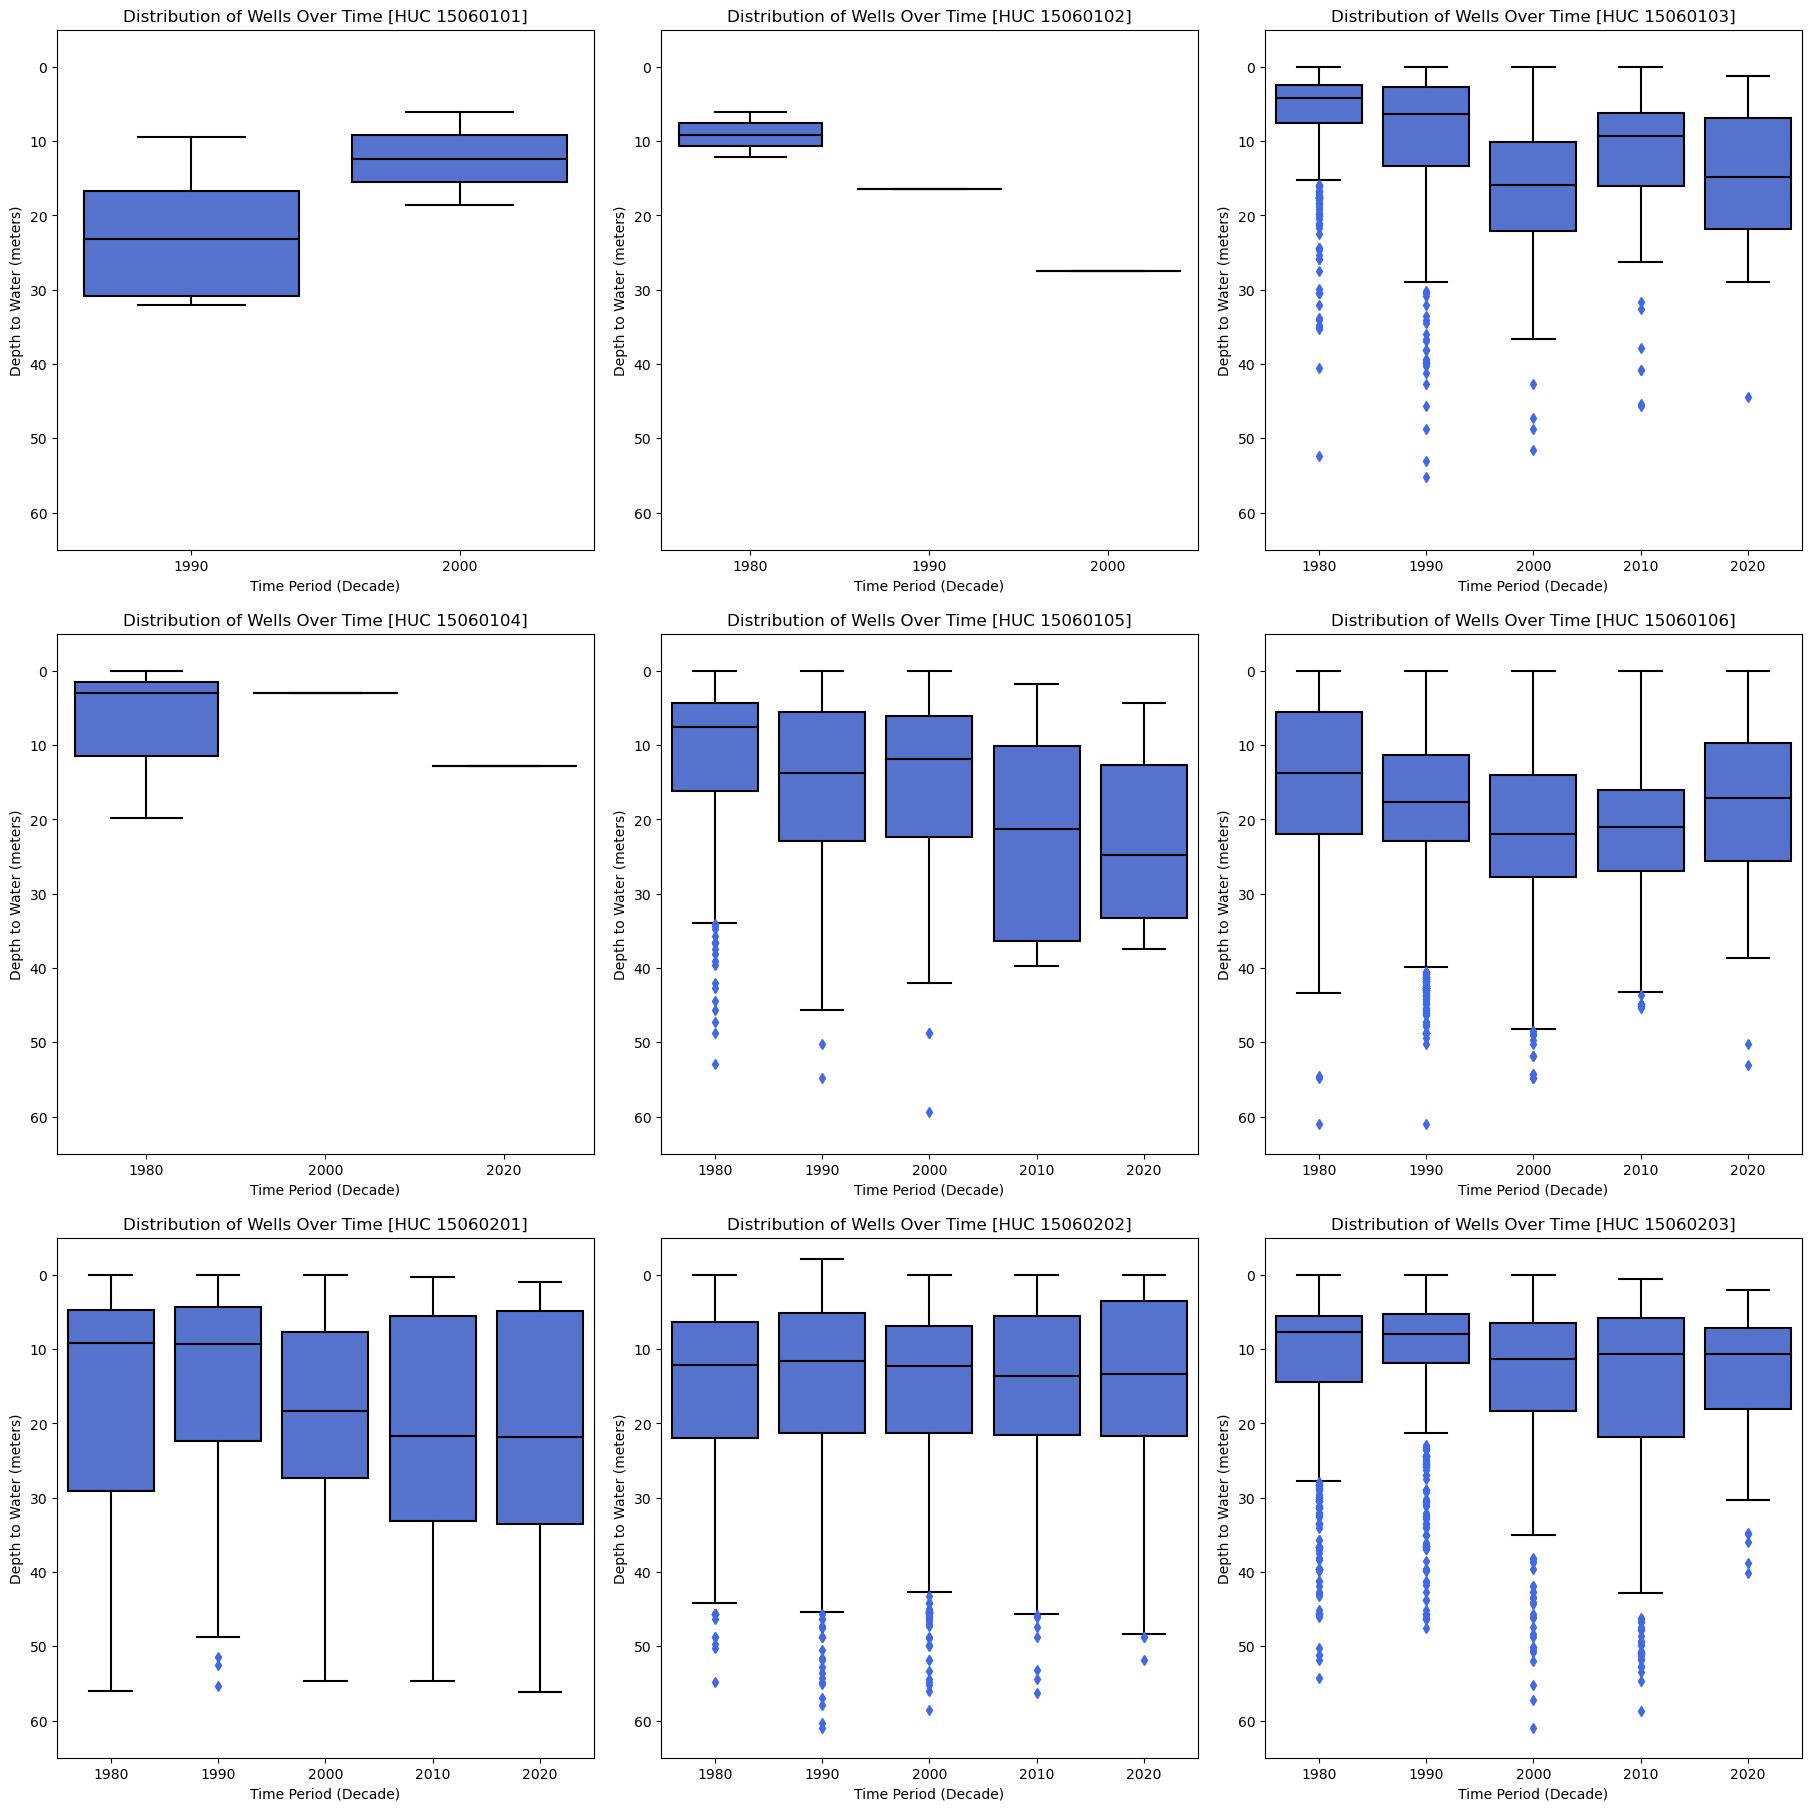

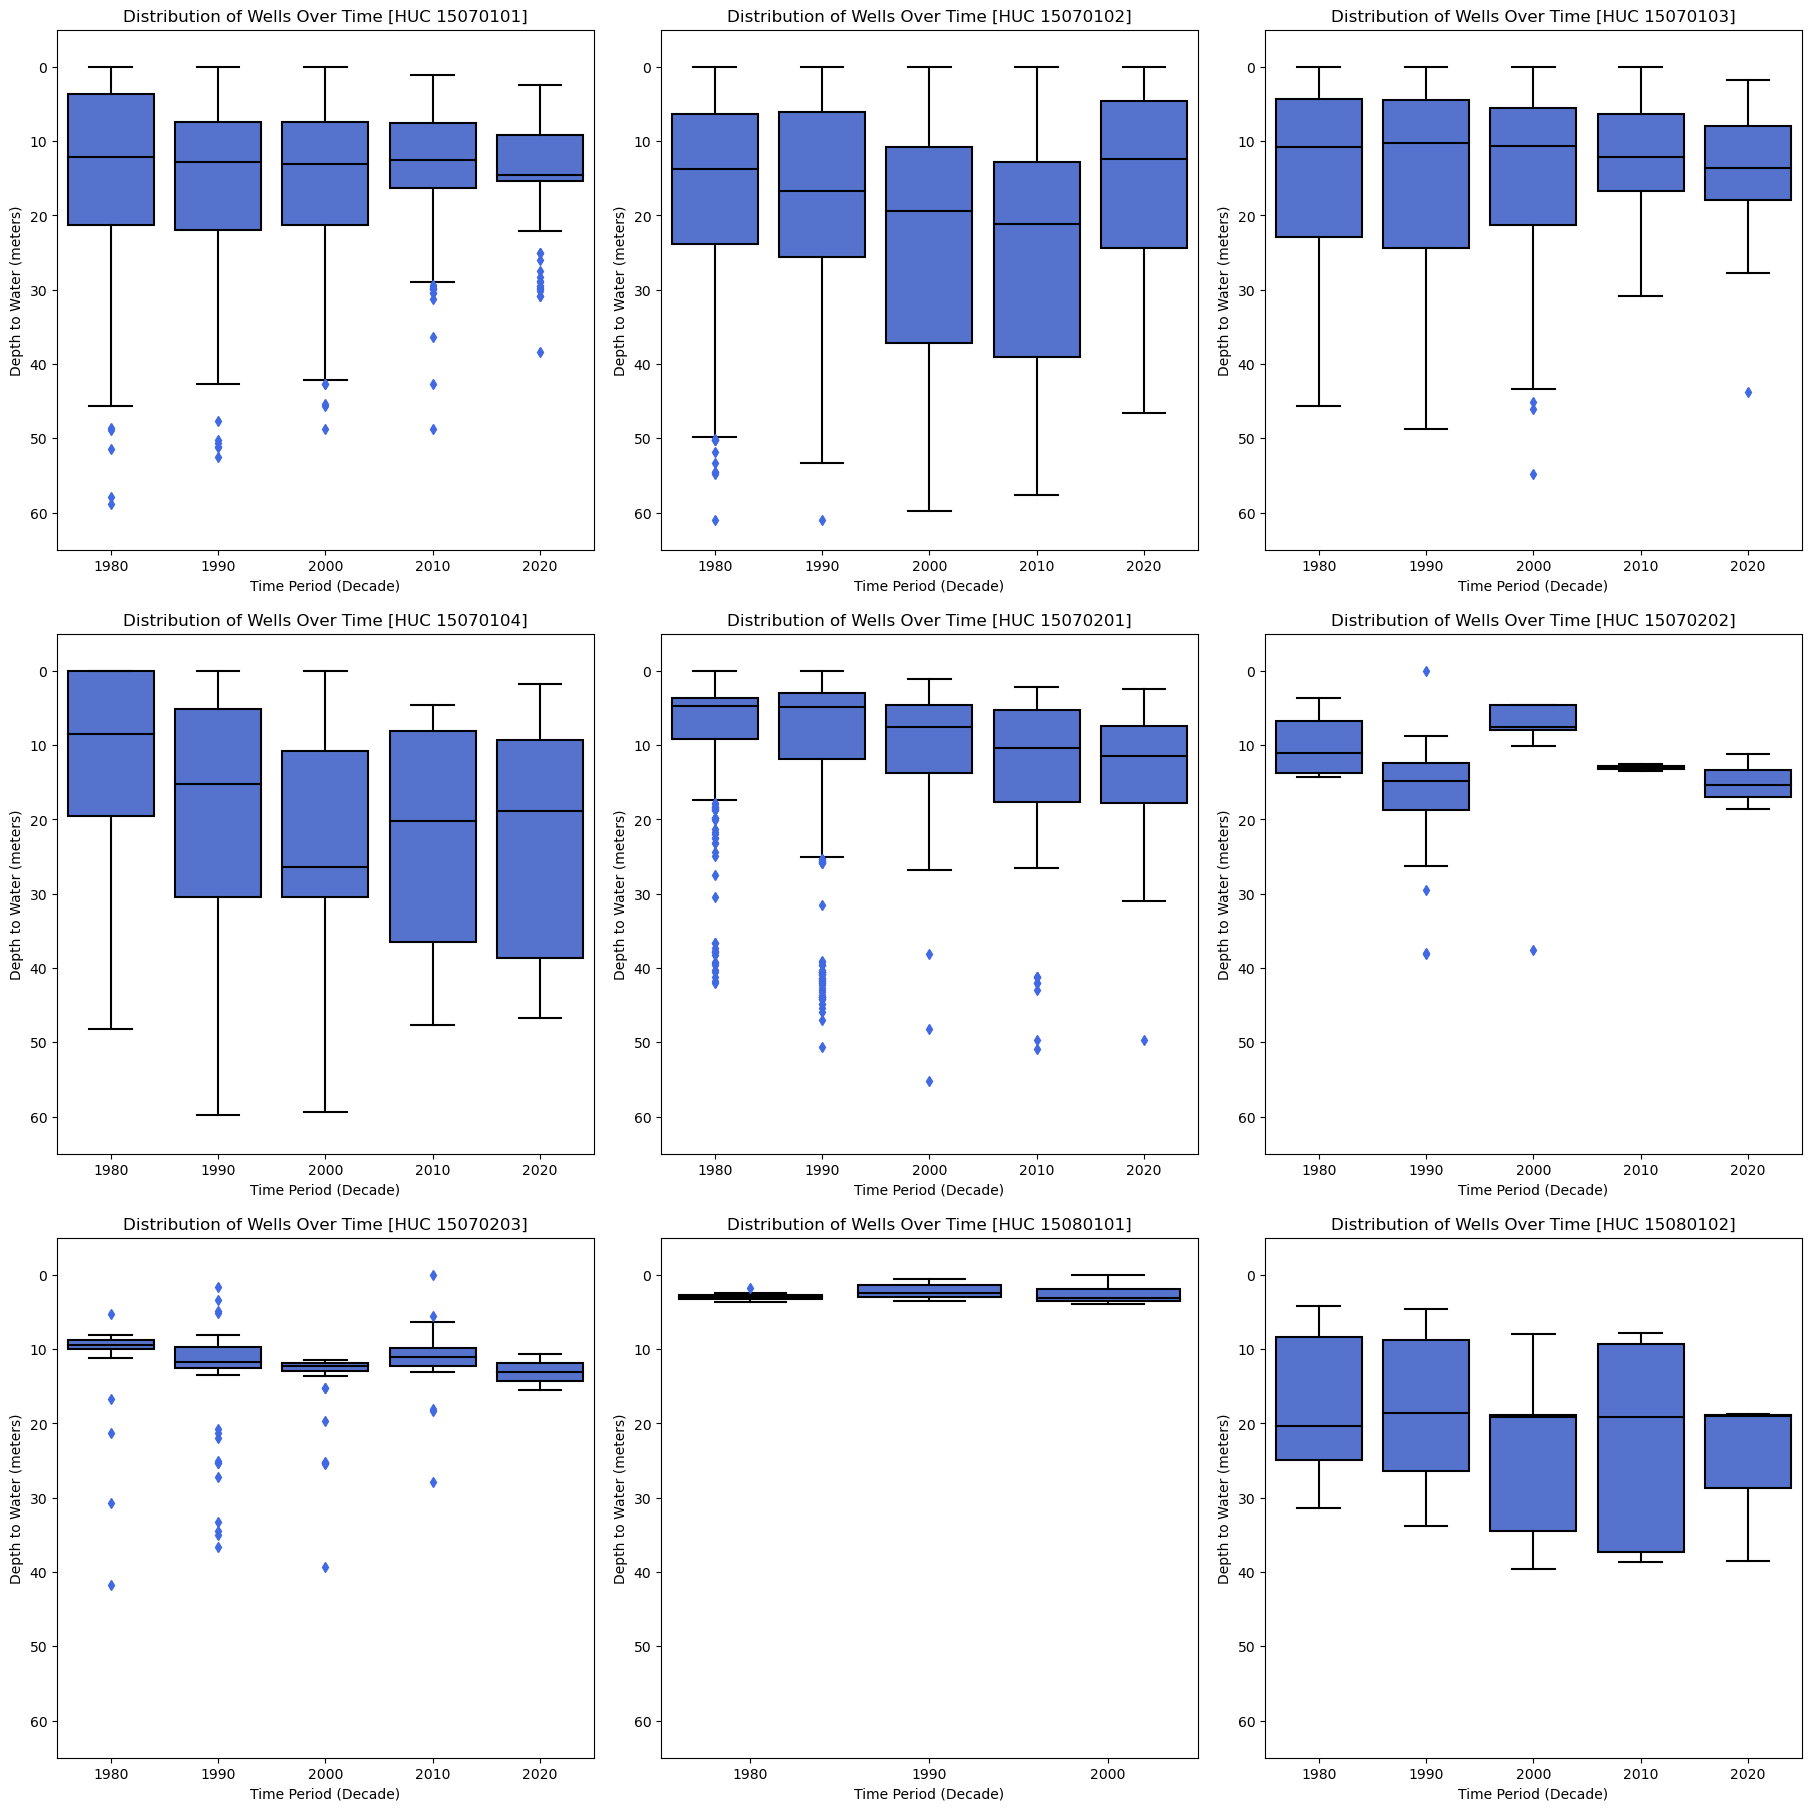

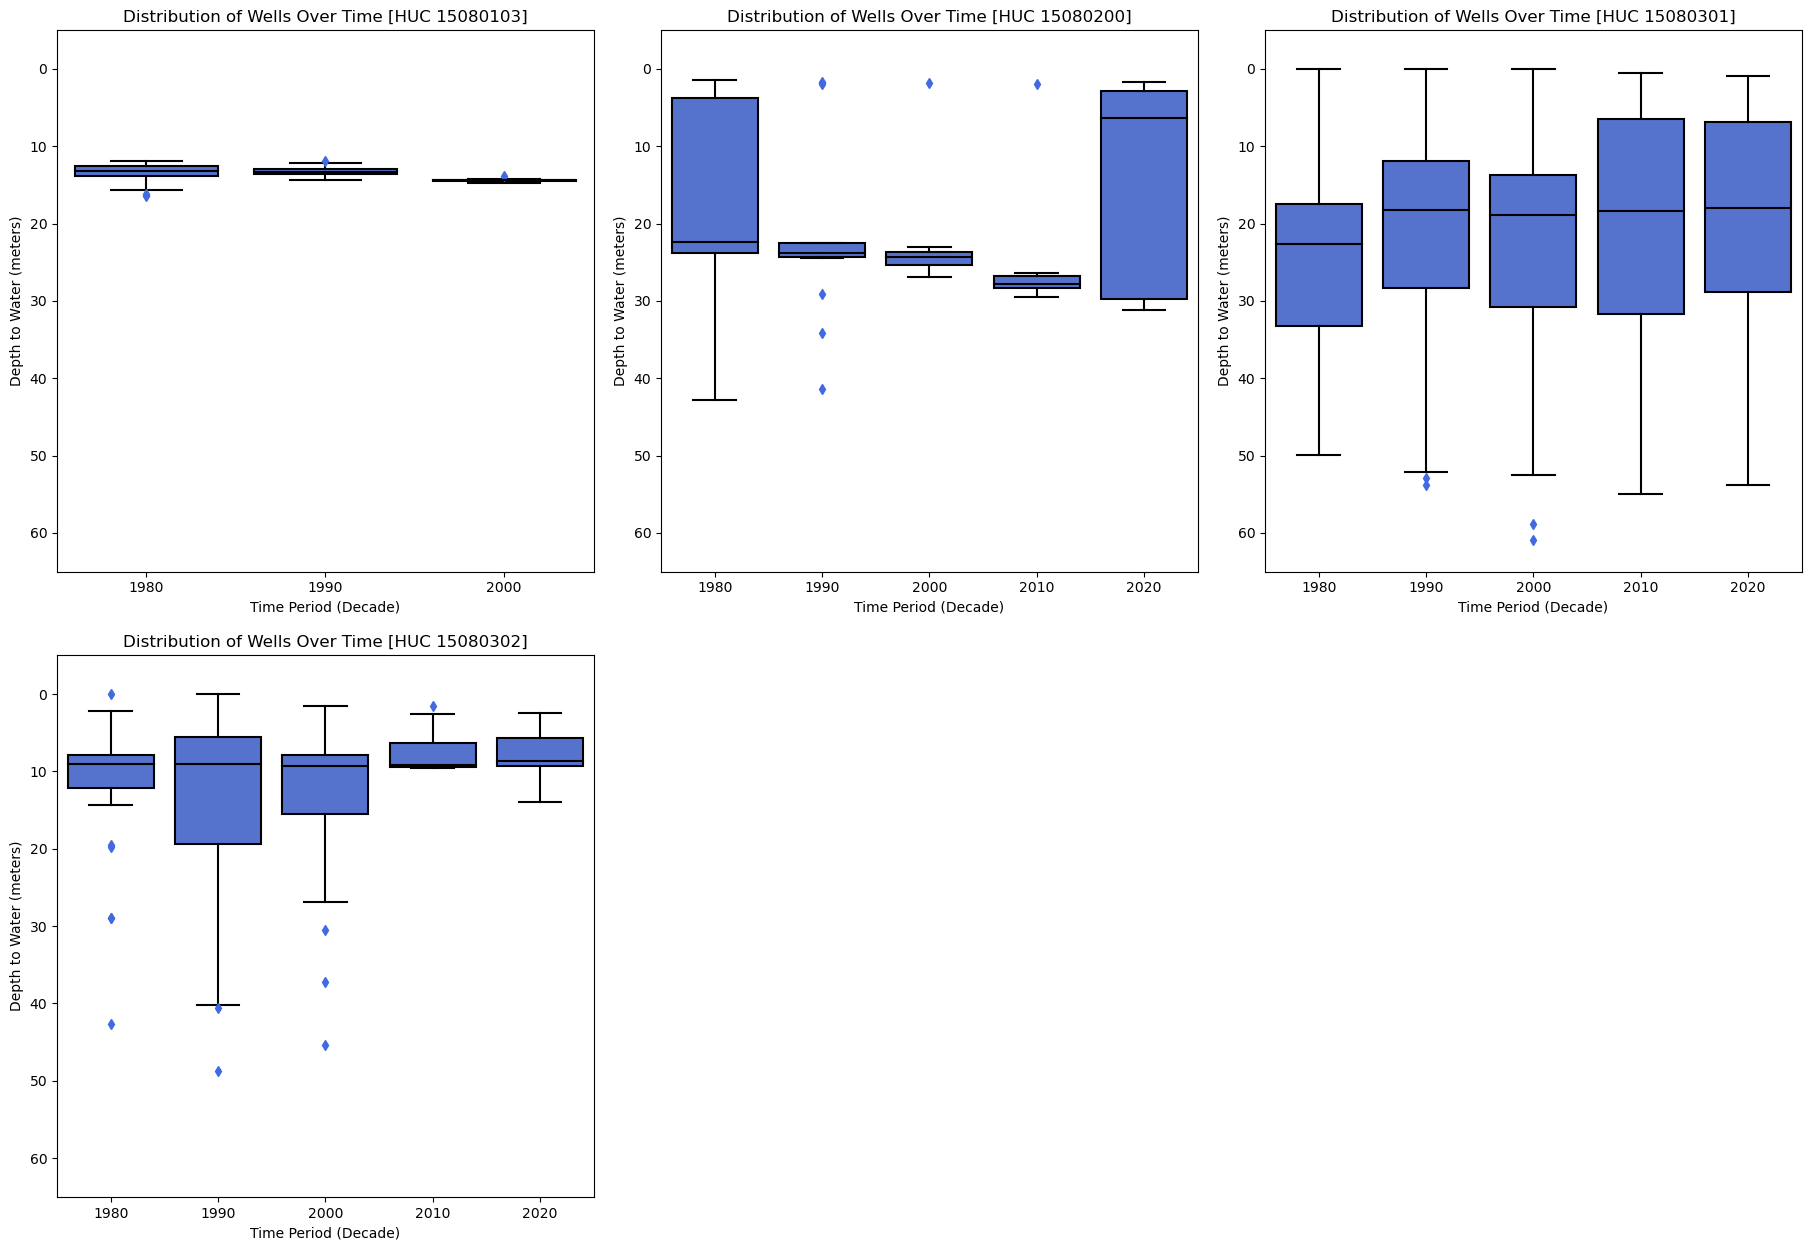

In [ ]:
listofhucs = boundaries_melted[Naming_col].unique().tolist()
num_hucs = len(listofhucs)

# Define batch size (3x3 grid)
batch_size = 9

# Define a single color for the boxes
box_color = "royalblue"

# Loop through HUCs in batches of 9
for batch_start in range(0, num_hucs, batch_size):
    batch = listofhucs[batch_start:batch_start + batch_size]
    num_in_batch = len(batch)

    # Create a 3x3 grid (or smaller if fewer plots in the batch)
    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), constrained_layout=True)
    axes = axes.flatten()  # Flatten for easy indexing

    for i, huc in enumerate(batch):
        subset = boundaries_melted[boundaries_melted[Naming_col] == huc]

        sns.boxplot(
            data=subset, 
            x='Decade',
            y='DTW_meters',
            color=box_color,
            ax=axes[i],
            boxprops=dict(edgecolor="black"),
            medianprops=dict(color="black"),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            flierprops=dict(markerfacecolor=box_color, markeredgecolor=box_color)
        )

        axes[i].set_title(f'Distribution of Wells Over Time [HUC {huc}]')
        axes[i].set_xlabel('Time Period (Decade)')
        axes[i].set_ylabel('Depth to Water (meters)')
        axes[i].tick_params(axis='x', rotation=0)
        axes[i].set_ylim(65, -5)

    # Remove any unused subplots
    for j in range(num_in_batch, len(axes)):
        fig.delaxes(axes[j])

    plt.show()


In [ ]:
melted_distances

{'100m':        Combo_ID      huc8        Date   DTW  DTW_meters        DTW_Category  \
 0        921252  15010001  2018-04-01  28.0     8.53440     Shallow (5-10m)   
 1        921254  15010001  2018-04-01  28.0     8.53440     Shallow (5-10m)   
 2        521579  15010003  1988-08-01   0.0     0.00000  Near Surface (<2m)   
 3        526741  15010003  1990-06-01  33.0    10.05840       Deep (10-61m)   
 4        919879  15010003  2016-09-01  30.0     9.14400     Shallow (5-10m)   
 ...         ...       ...         ...   ...         ...                 ...   
 10118    212327  15080302  2020-11-01  20.0     6.09600     Shallow (5-10m)   
 10119    616444  15080302  2020-11-01  31.5     9.60120     Shallow (5-10m)   
 10120    616444  15080302  2021-11-01  29.9     9.11352     Shallow (5-10m)   
 10121    616444  15080302  2022-11-01  29.0     8.83920     Shallow (5-10m)   
 10122    616444  15080302  2023-11-01  31.7     9.66216     Shallow (5-10m)   
 
        Decade  
 0        201

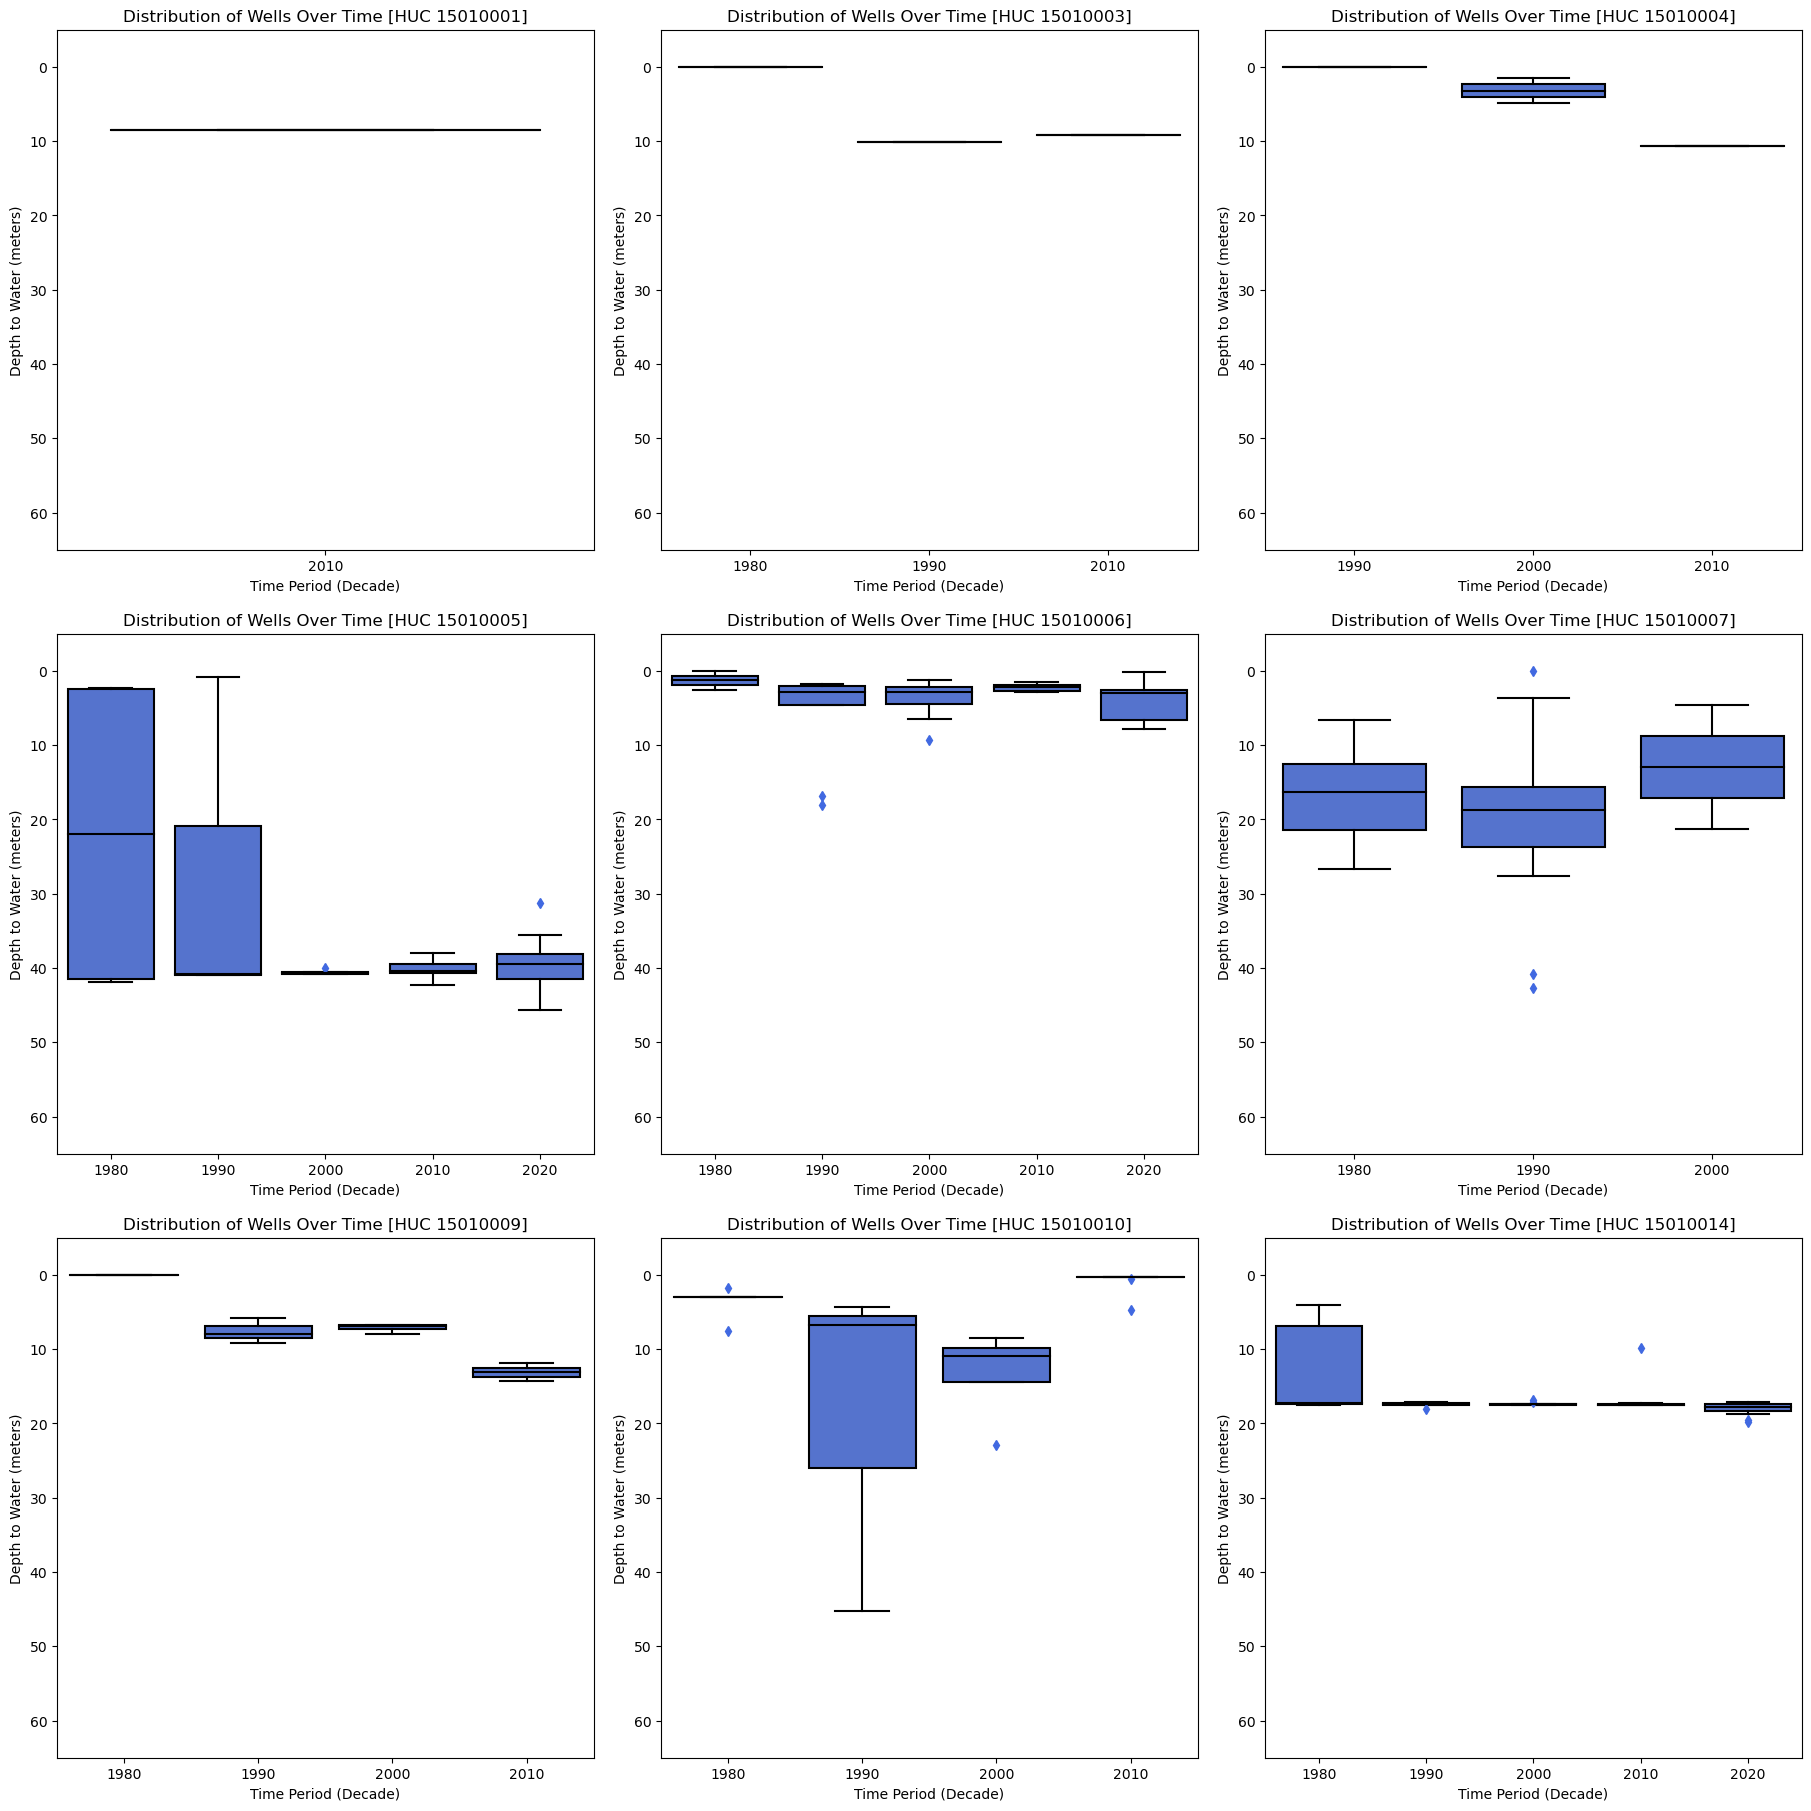

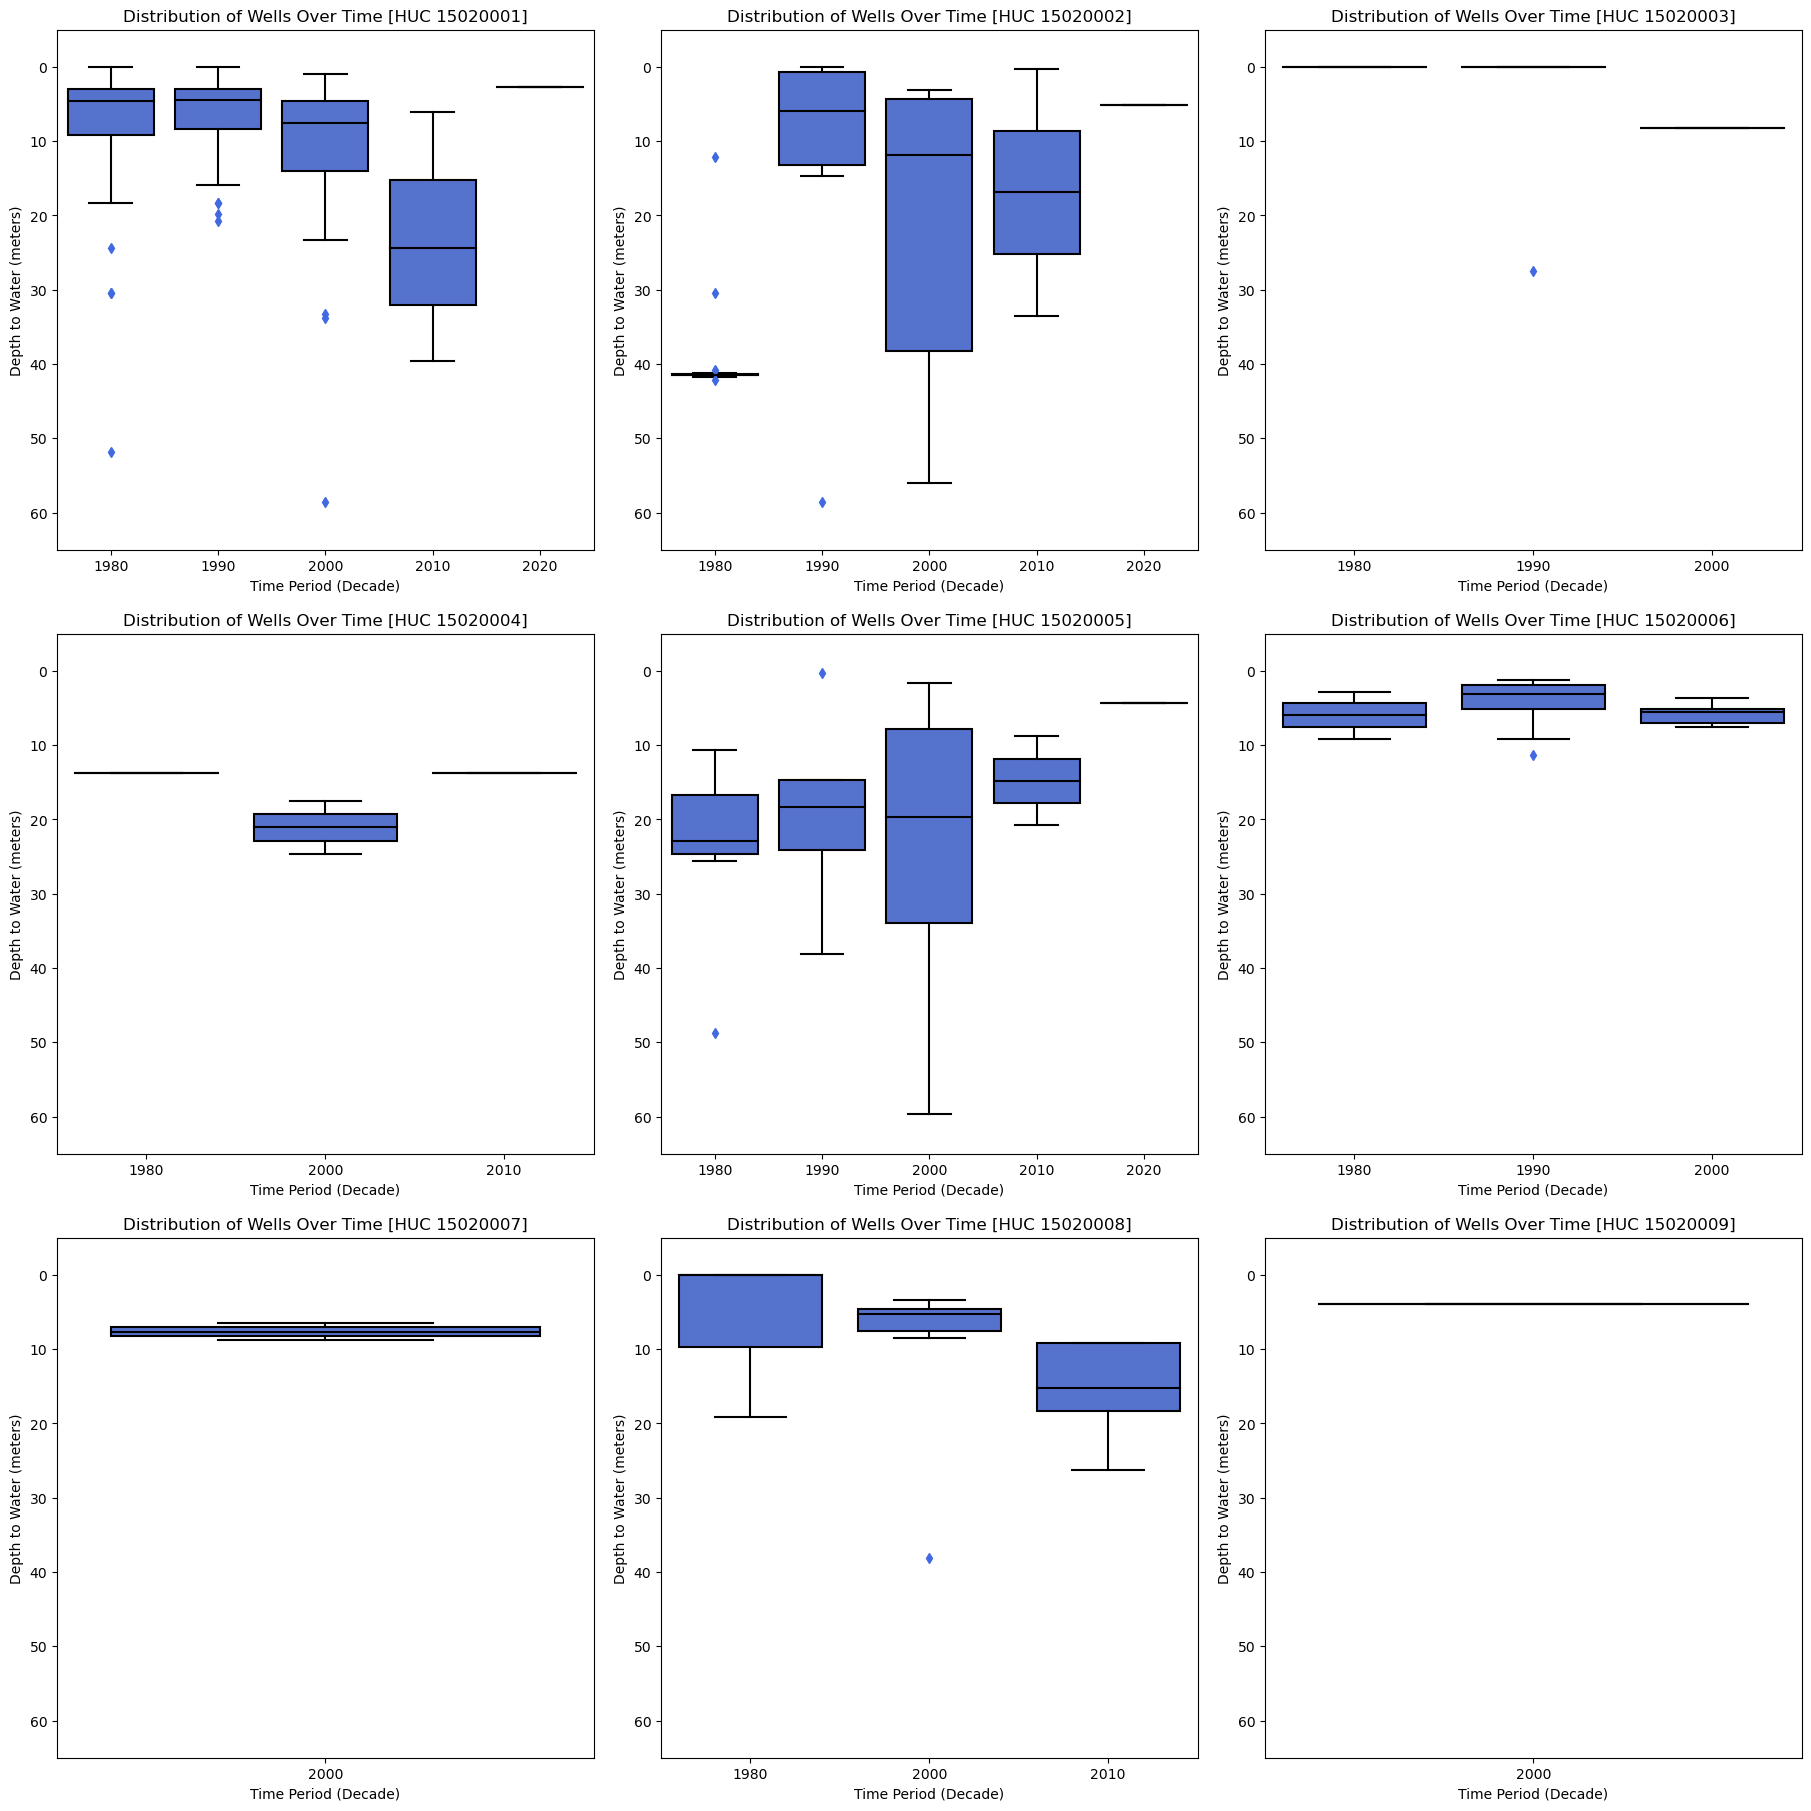

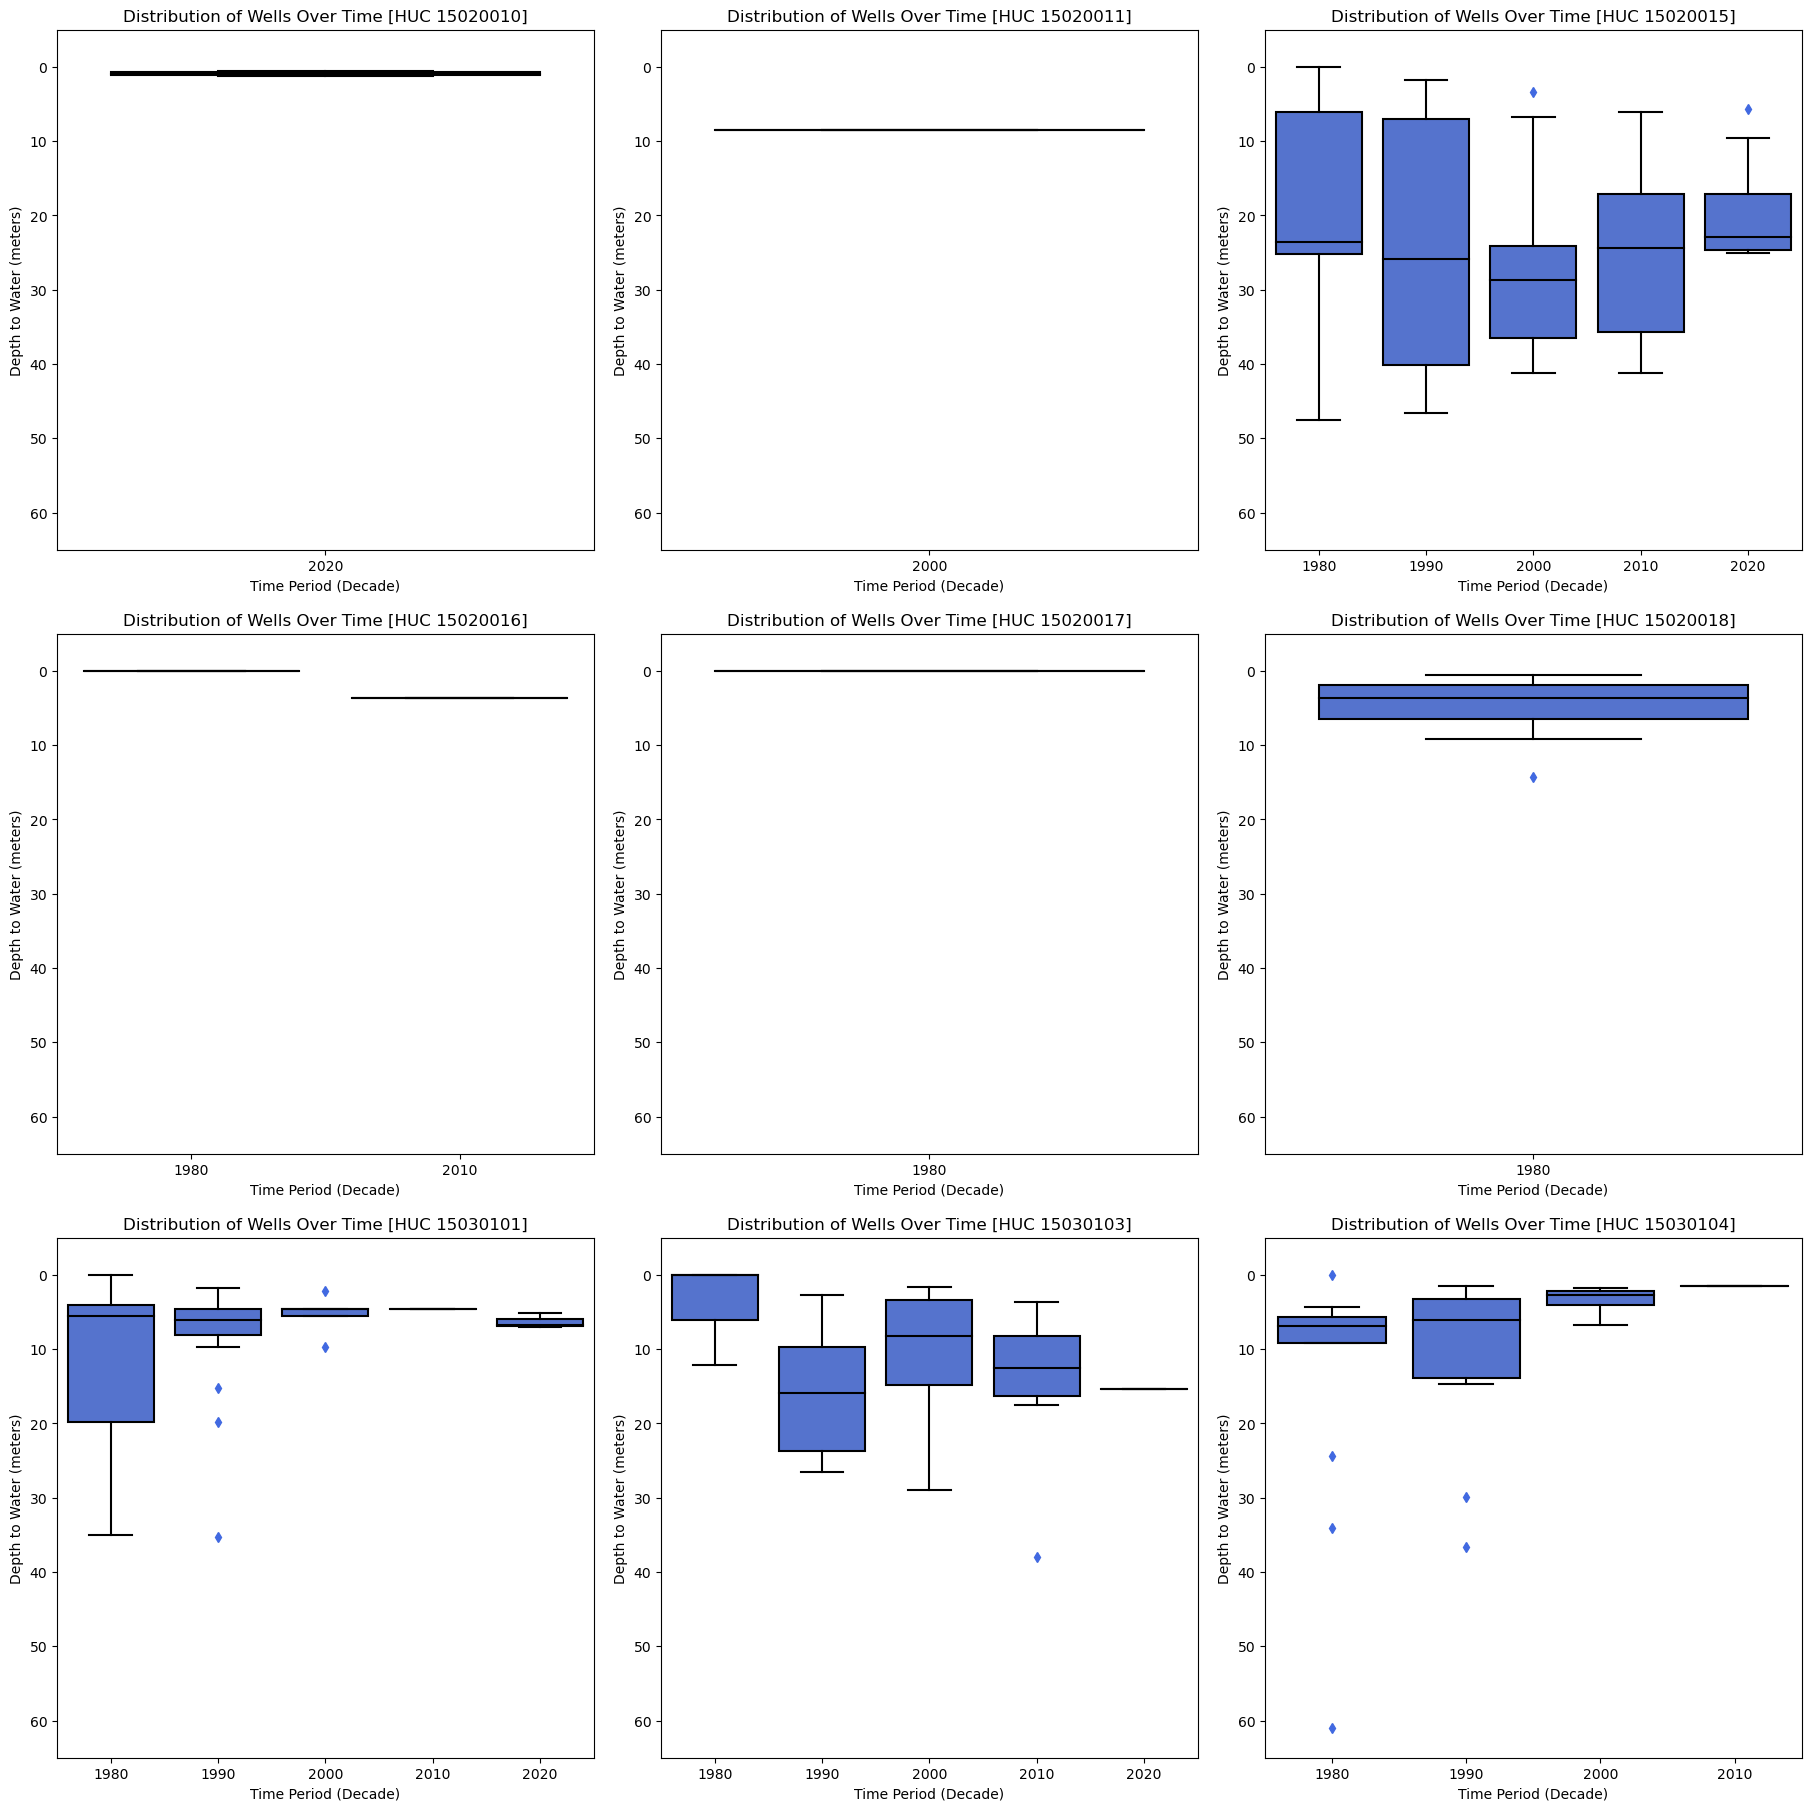

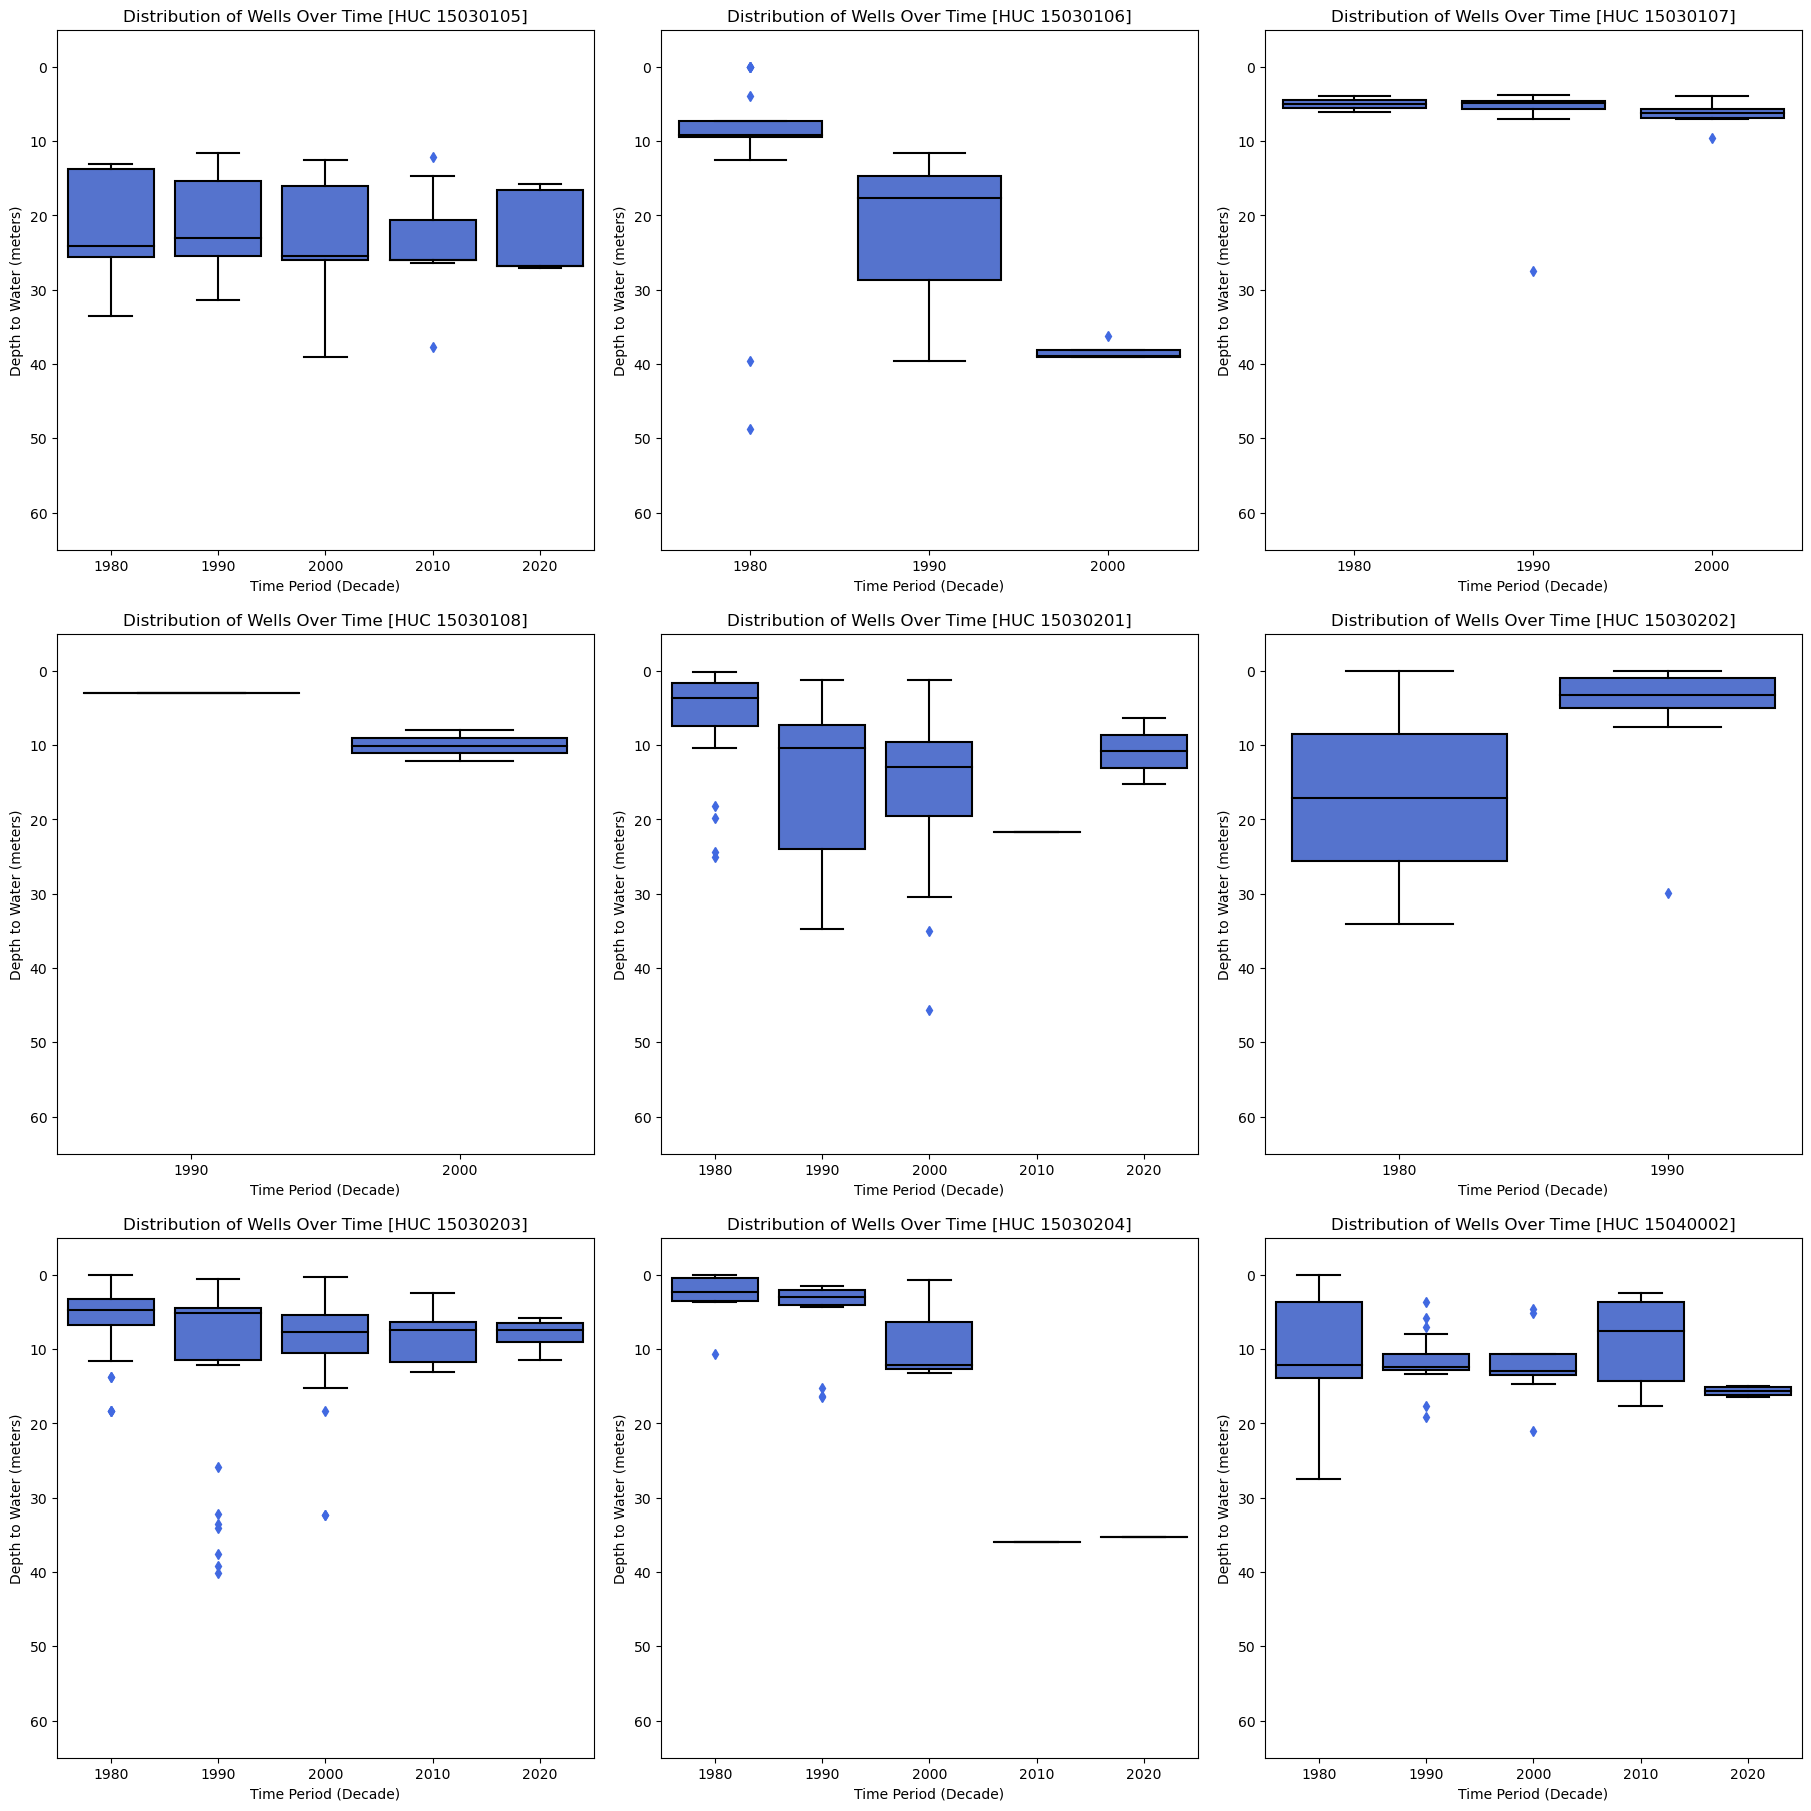

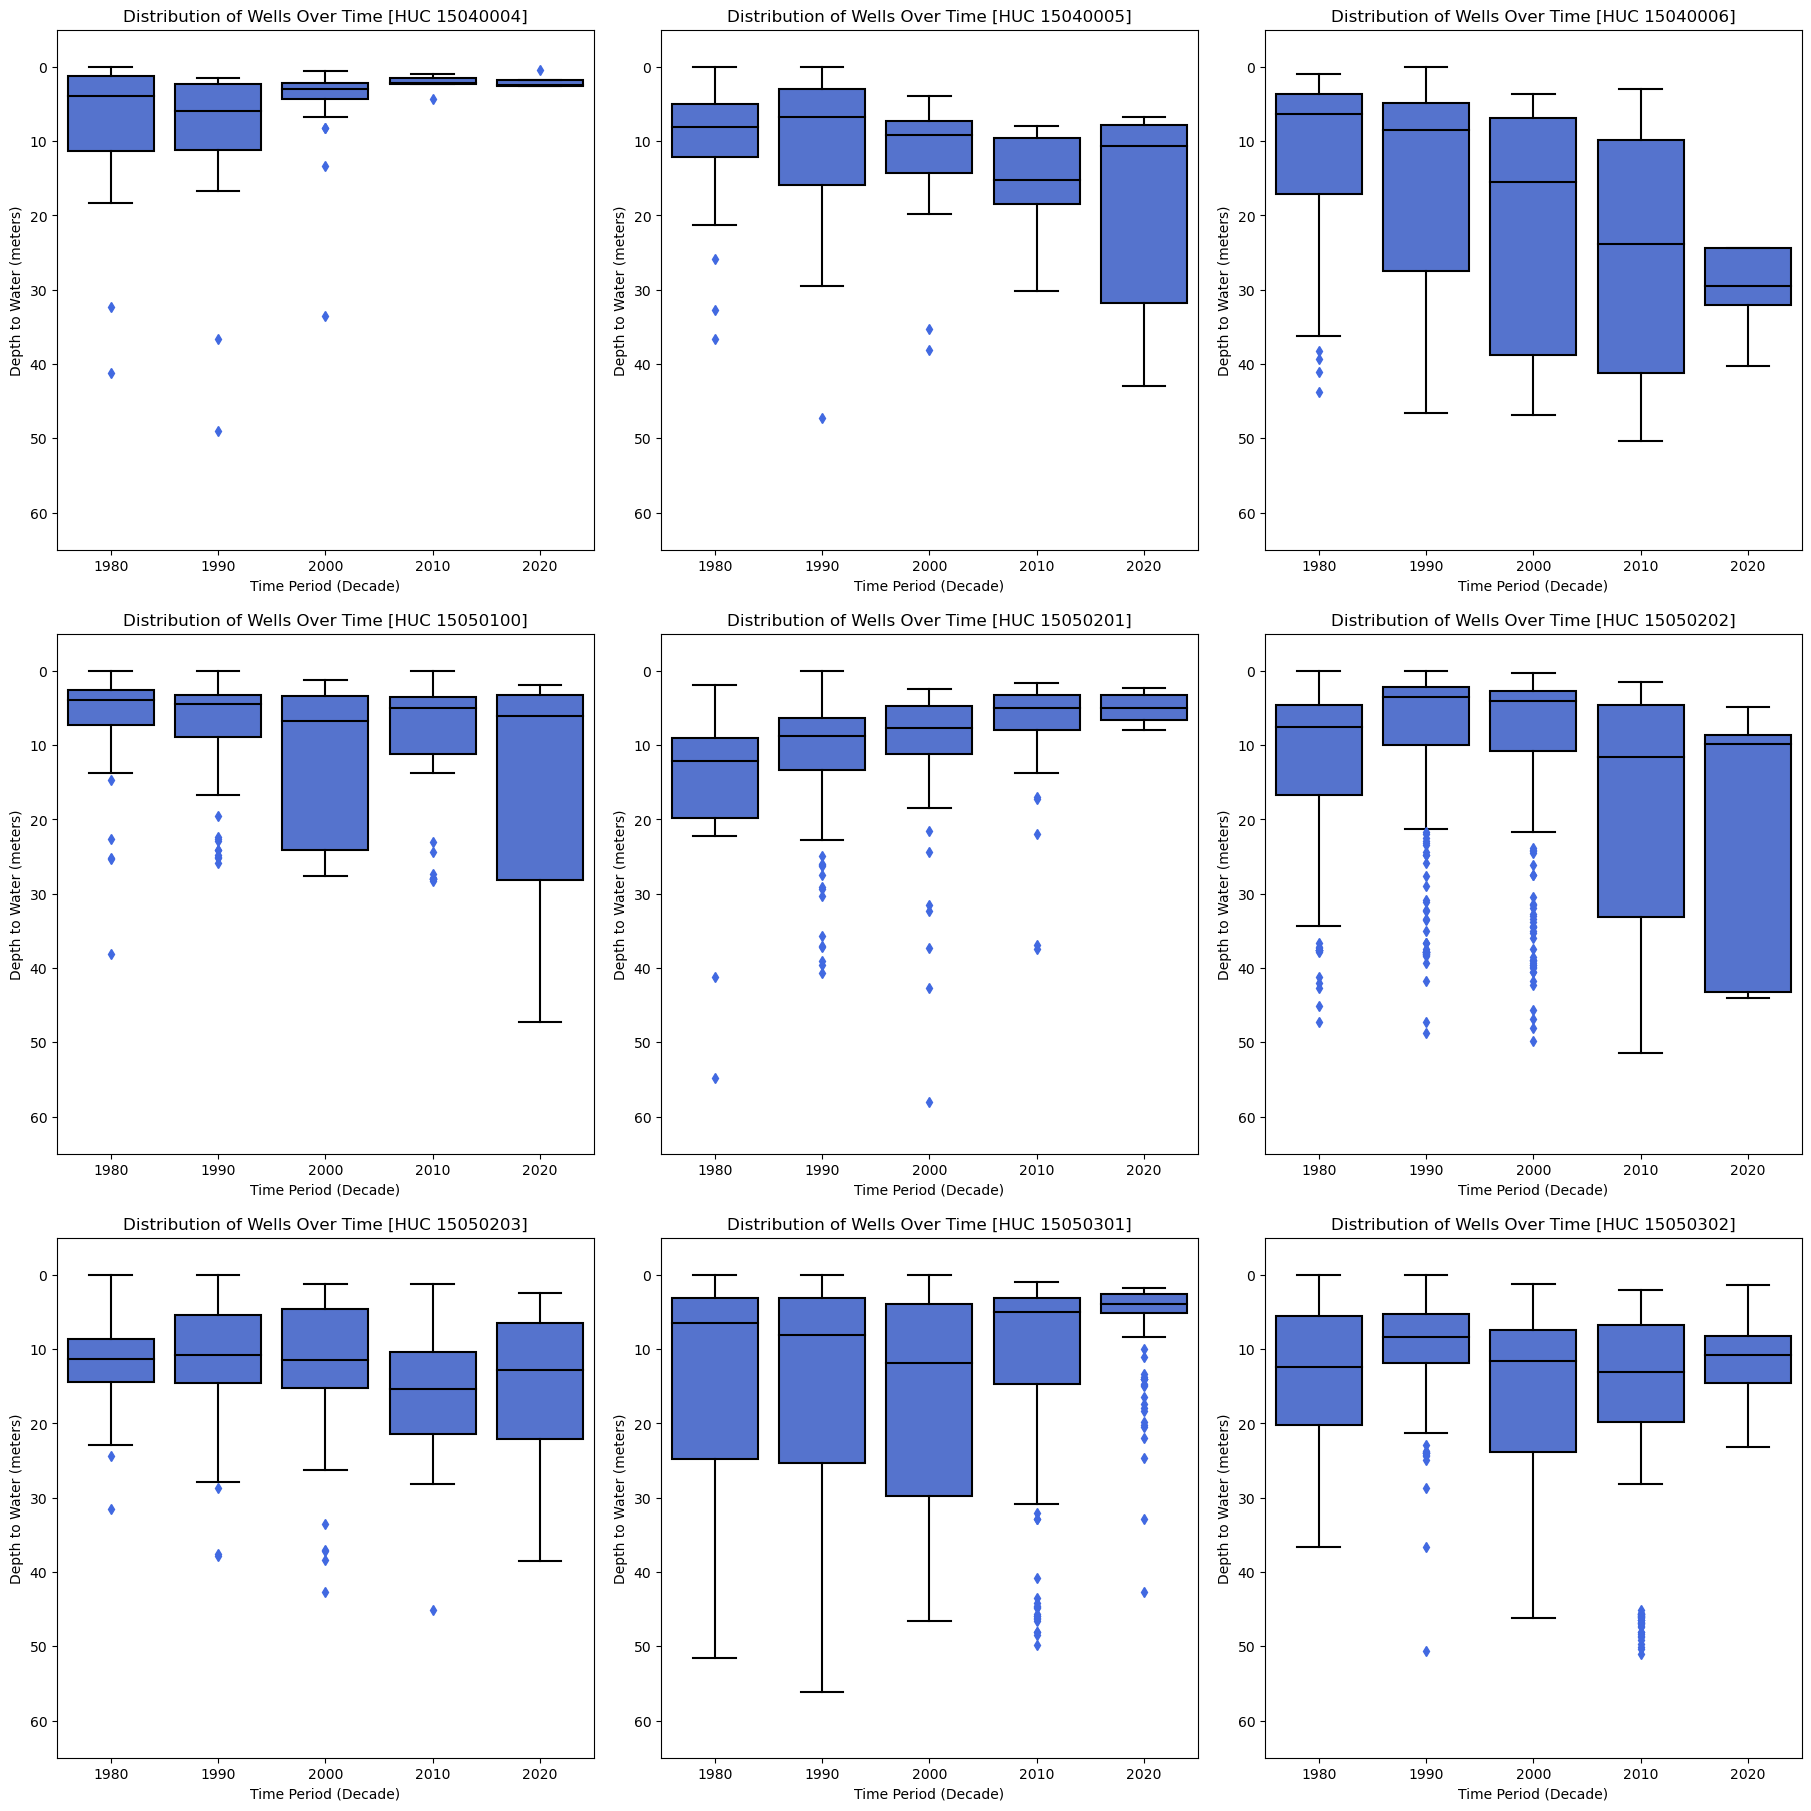

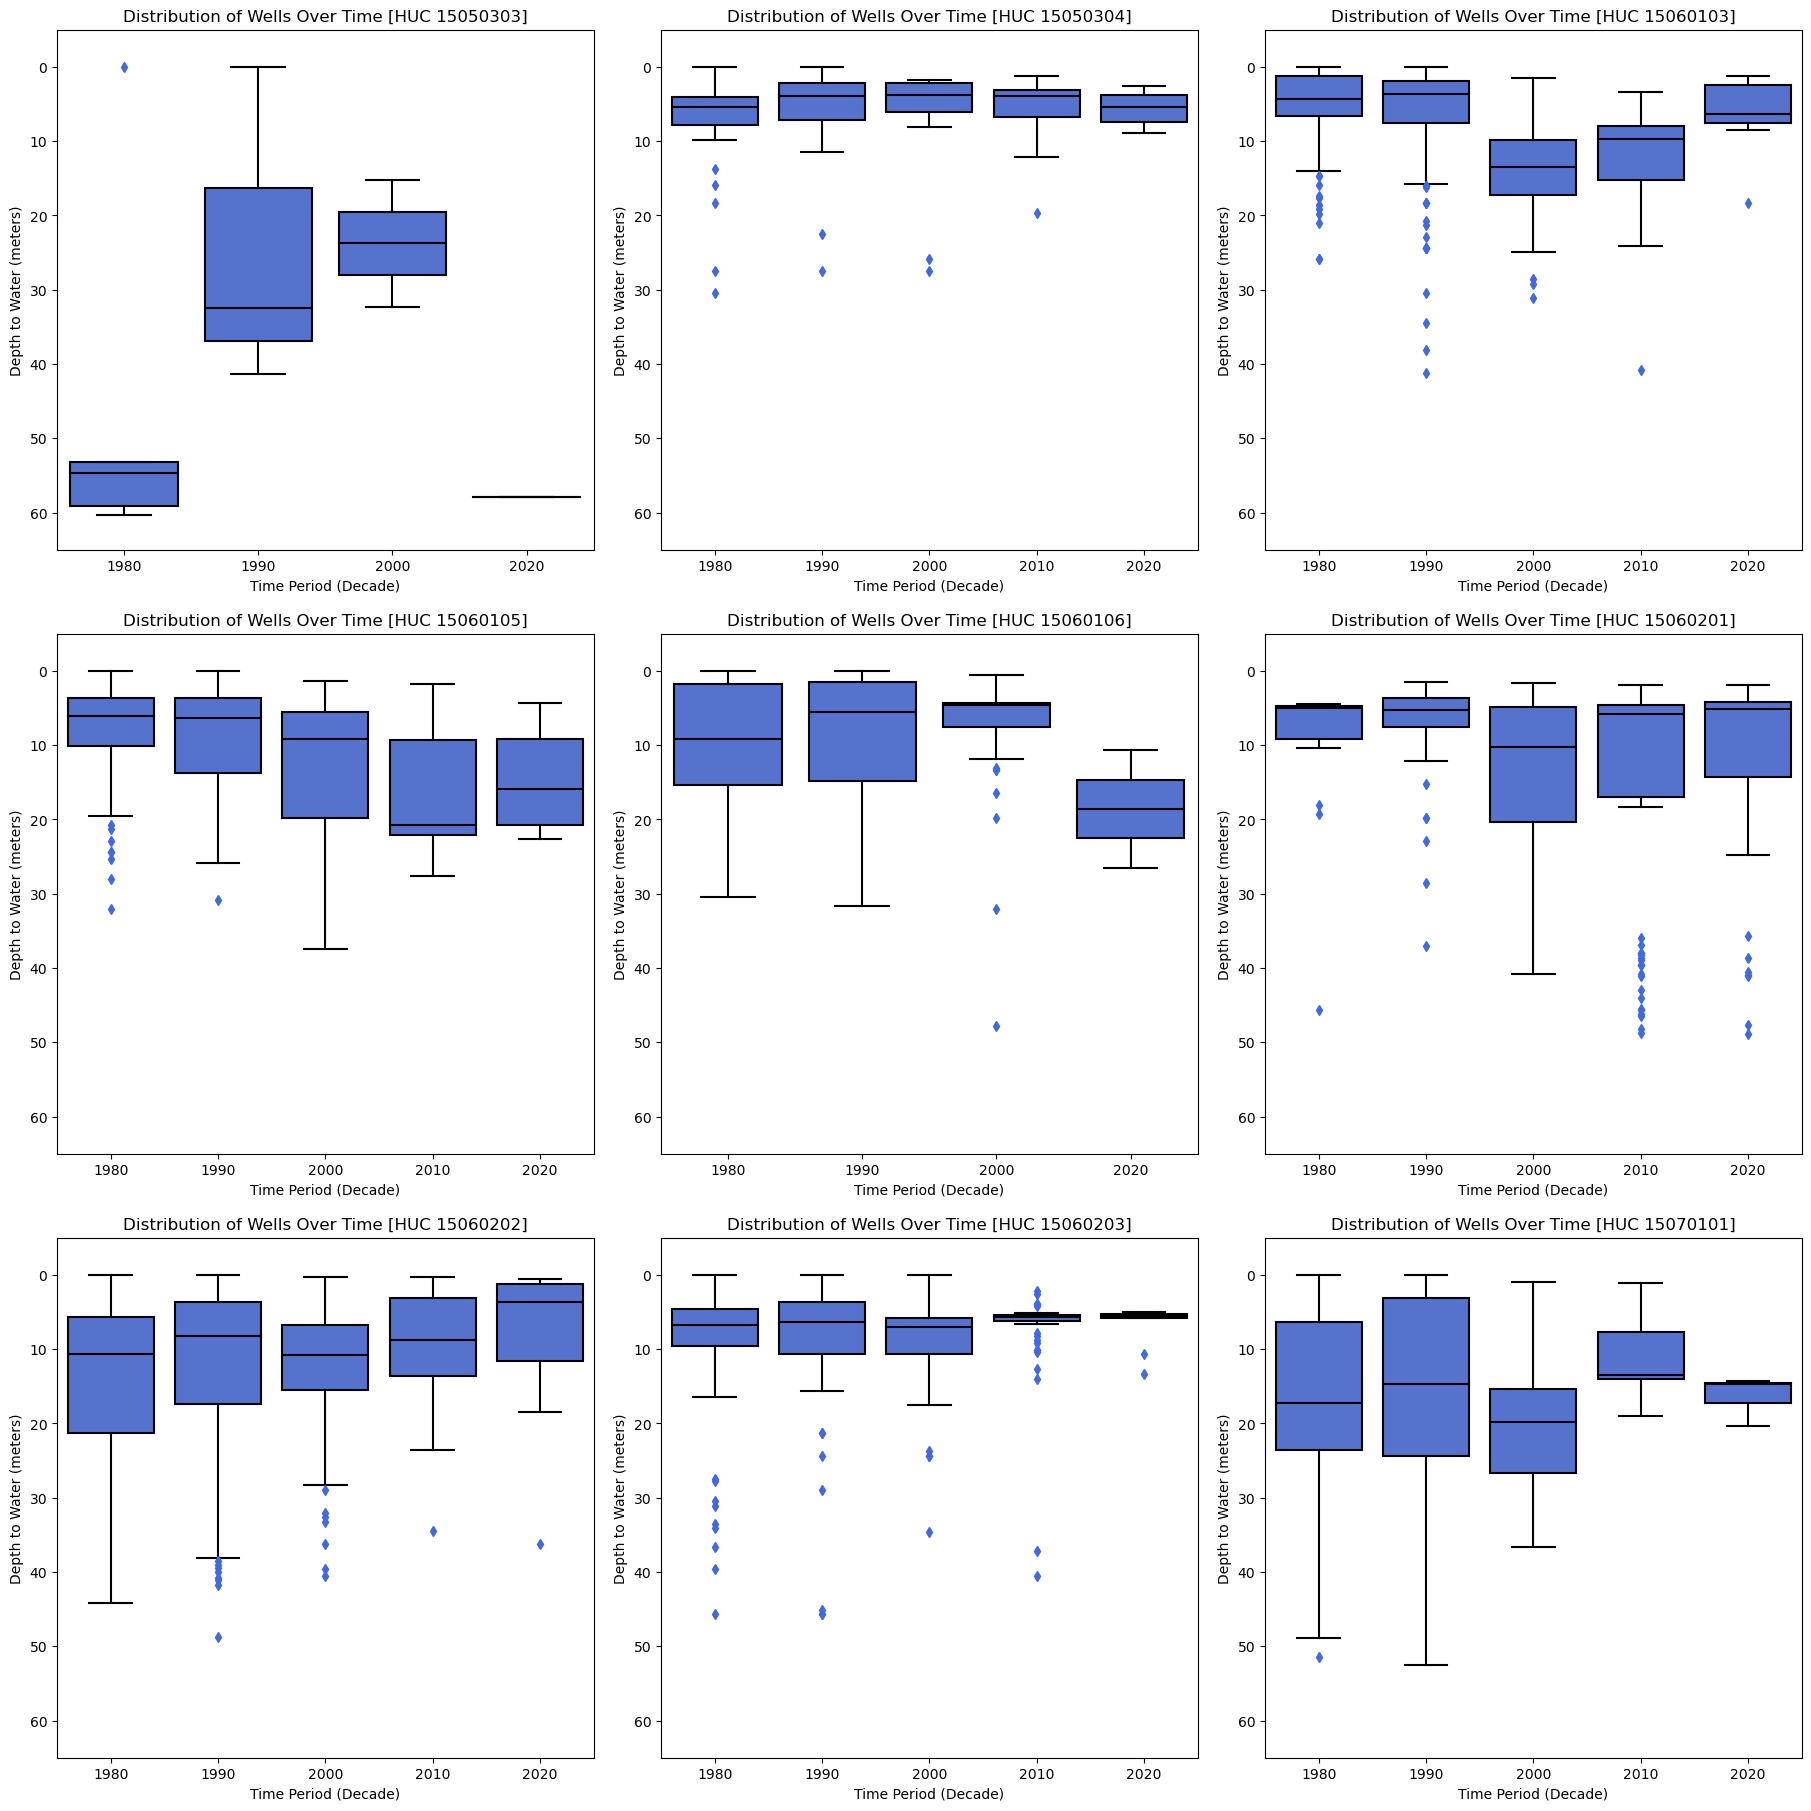

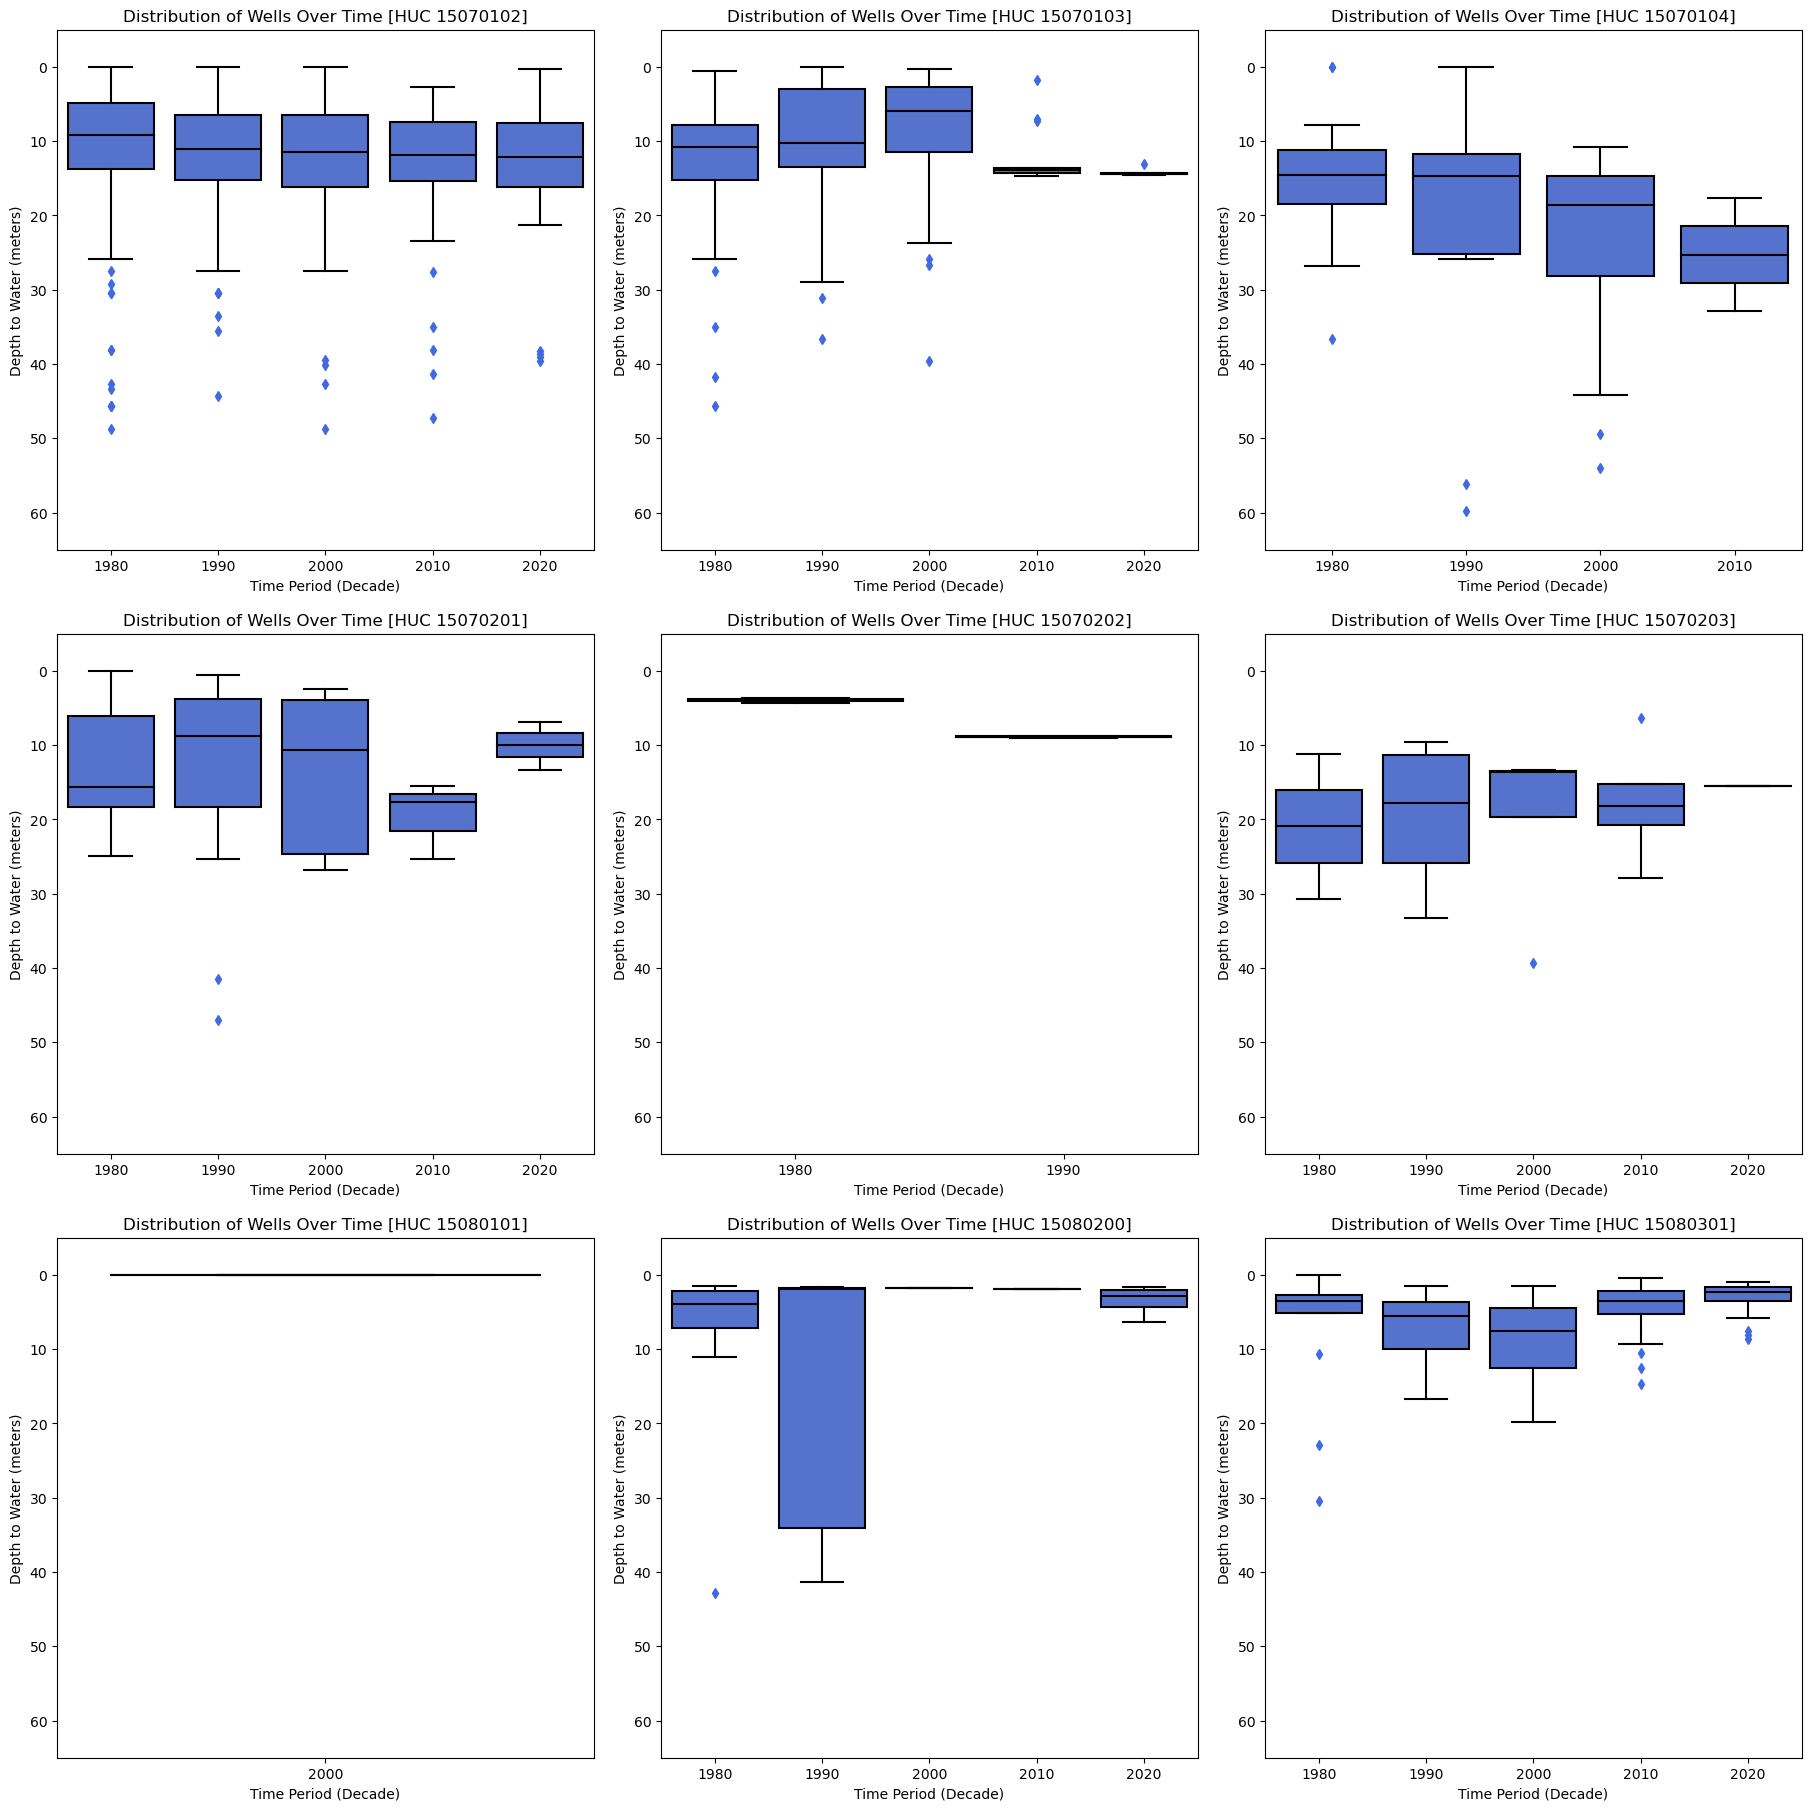

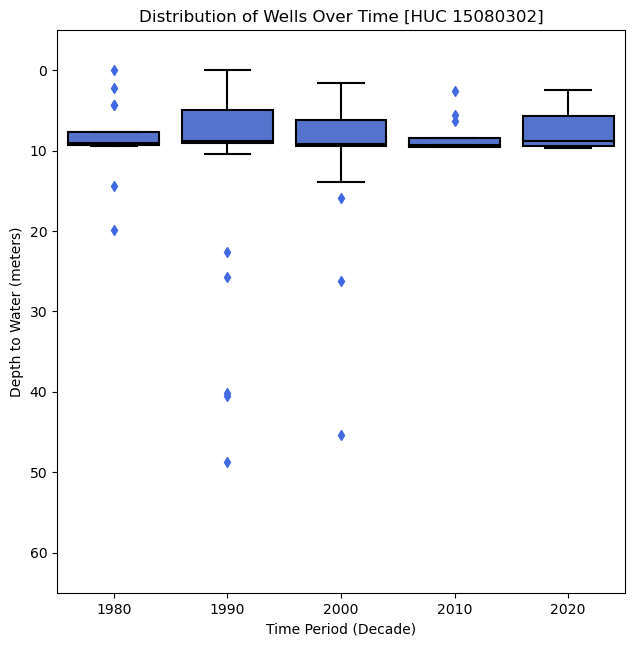

In [ ]:
df = melted_distances['100m']
listofhucs = df[Naming_col].unique().tolist()
num_hucs = len(listofhucs)

# Define batch size (3x3 grid)
batch_size = 9

# Define a single color for the boxes
box_color = "royalblue"

# Loop through HUCs in batches of 9
for batch_start in range(0, num_hucs, batch_size):
    batch = listofhucs[batch_start:batch_start + batch_size]
    num_in_batch = len(batch)

    # Create a 3x3 grid (or smaller if fewer plots in the batch)
    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), constrained_layout=True)
    axes = axes.flatten()  # Flatten for easy indexing

    for i, huc in enumerate(batch):
        subset = df[df[Naming_col] == huc]

        sns.boxplot(
            data=subset, 
            x='Decade',
            y='DTW_meters',
            color=box_color,
            ax=axes[i],
            boxprops=dict(edgecolor="black"),
            medianprops=dict(color="black"),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            flierprops=dict(markerfacecolor=box_color, markeredgecolor=box_color)
        )

        axes[i].set_title(f'Distribution of Wells Over Time [HUC {huc}]')
        axes[i].set_xlabel('Time Period (Decade)')
        axes[i].set_ylabel('Depth to Water (meters)')
        axes[i].tick_params(axis='x', rotation=0)
        axes[i].set_ylim(65, -5)

    # Remove any unused subplots
    for j in range(num_in_batch, len(axes)):
        fig.delaxes(axes[j])

    plt.show()


In [41]:
# Summing all HUCs together by Decade and DTW_Category
# summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()
summary_table = boundaries_percents.groupby(["Decade", "DTW_Category"]).sum().reset_index()

# Display the summary table
summary_table.head()


Decade         DTW_Category        huc8  Well Count  Away from Streams  \
0    1980        Deep (10-61m)   932647269        6509             1492.0   
1    1980   Near Surface (<2m)   932376490        1740              526.0   
2    1980      Shallow (5-10m)   872396473        2665              350.0   
3    1980  Very Shallow (2-5m)   842366144        1944              513.0   
4    1990        Deep (10-61m)  1037767108       10048             3389.0   

   Ratio_100m  Ratio_500m  Ratio_1000m  Ratio_1500m  Ratio_2000m  
0    6.561955   23.236617    35.390064    40.939071    46.262418  
1   11.109222   23.358913    32.763460    40.430359    45.275111  
2    8.746572   33.986048    42.426198    45.511006    48.057258  
3   14.652012   32.876452    39.169124    42.740349    44.603045  
4    7.210349   23.984899    37.574543    44.116032    50.356511

In [55]:
# Summing all HUCs together by Decade and DTW_Category
# summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()
summary_table_nocategories = boundaries_percents.groupby(["Decade", "DTW_Category"]).sum().reset_index()

# Display the summary table
summary_table.head()


Decade         DTW_Category        huc8  Well Count  Well Count_100m  \
0    1980        Deep (10-61m)   932647269        6509            599.0   
1    1980   Near Surface (<2m)   932376490        1740            244.0   
2    1980      Shallow (5-10m)   872396473        2665            462.0   
3    1980  Very Shallow (2-5m)   842366144        1944            331.0   
4    1990        Deep (10-61m)  1037767108       10048            666.0   

   Well Count_500m  Well Count_1000m  Well Count_1500m  Well Count_2000m  \
0           2471.0            3805.0            4523.0            5014.0   
1            640.0             896.0            1079.0            1206.0   
2           1530.0            1971.0            2161.0            2315.0   
3            938.0            1191.0            1335.0            1428.0   
4           2852.0            4295.0            5263.0            5929.0   

   Away from Streams  
0             1492.0  
1              526.0  
2              350.0  
3              513.0  
4             3389.0

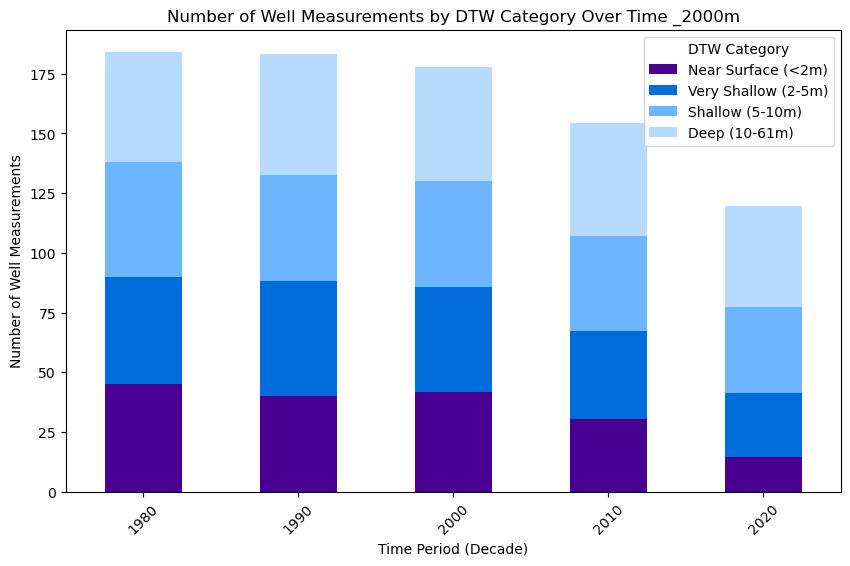

In [45]:
dist_plotting = "_2000m"

# Pivot the data to get each DTW category as a separate column for stacking
# summary_pivot = summary_table.pivot(index='Decade', columns='DTW_Category', values=f'Well Count{dist_plotting}').fillna(0)
summary_pivot = summary_table.pivot(index='Decade', columns='DTW_Category', values=f'Ratio{dist_plotting}').fillna(0)

# Define the desired order for DTW categories
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']

# Reorder the columns in summary_pivot
summary_pivot = summary_pivot[category_order]

# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)

# Labels and title
plt.xlabel('Time Period (Decade)')
plt.ylabel('Number of Well Measurements')
plt.title(f'Number of Well Measurements by DTW Category Over Time {dist_plotting}')
plt.legend(title='DTW Category')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
print(colors)

{'Near Surface (<2m)': '#490092', 'Very Shallow (2-5m)': '#006ddb', 'Shallow (5-10m)': '#6db6ff', 'Deep (10-61m)': '#b6dbff'}


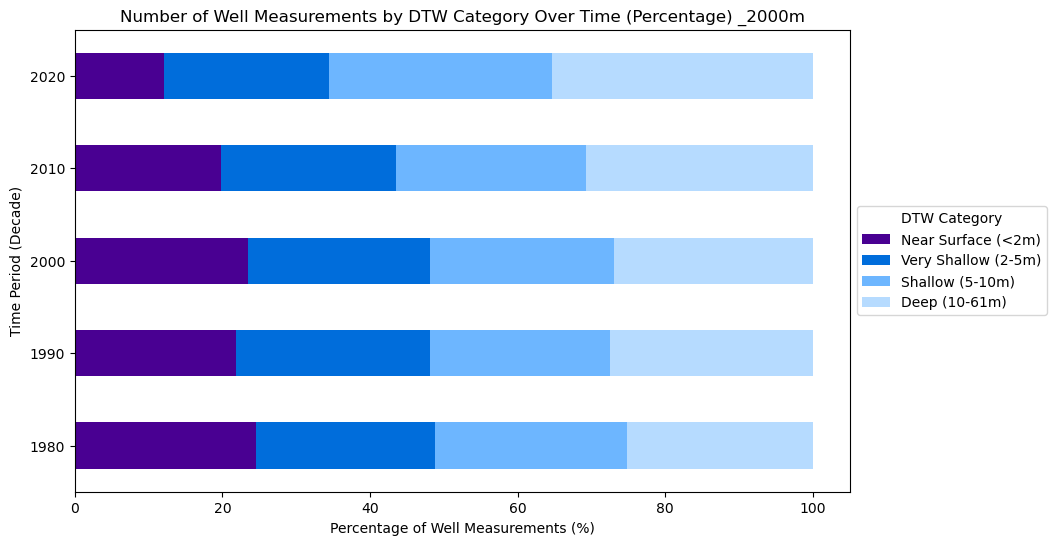

In [46]:
# Normalize data to get percentages
summary_pivot_percent = summary_pivot.div(summary_pivot.sum(axis=1), axis=0) * 100

# Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot_percent.plot(
    kind='barh',  # Horizontal bar chart
    stacked=True, 
    color=[colors[c] for c in summary_pivot.columns], 
    ax=ax
)

# Labels and title
plt.xlabel('Percentage of Well Measurements (%)')
plt.ylabel('Time Period (Decade)')
plt.title(f'Number of Well Measurements by DTW Category Over Time (Percentage) {dist_plotting}')
plt.legend(title='DTW Category', loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside for clarity
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

plt.show()


In [47]:
# Compute well counts per distance
distance_columns = [f"Well Count_{d}m" for d in distances]  # Adjust based on your column names
distance_sums = summary_table.groupby("Decade")[distance_columns].sum()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar plot
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax1)
ax1.set_xlabel("Time Period (Decade)")
ax1.set_ylabel("Number of Well Measurements")
ax1.set_title("Number of Well Measurements by DTW Category Over Time")

# Create a second y-axis for well counts per distance
ax2 = ax1.twinx()
for dist in distances:
    column_name = f"Well Count_{dist}m"
    ax2.plot(distance_sums.index, distance_sums[column_name], marker="o", label=f"{dist}m", linestyle="dashed")

ax2.set_ylabel("Total Well Counts by Distance")
ax2.legend(title="Buffer Distance", loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=45)
plt.show()


KeyError: "Columns not found: 'Well Count_2000m', 'Well Count_1000m', 'Well Count_100m', 'Well Count_1500m', 'Well Count_500m'"

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

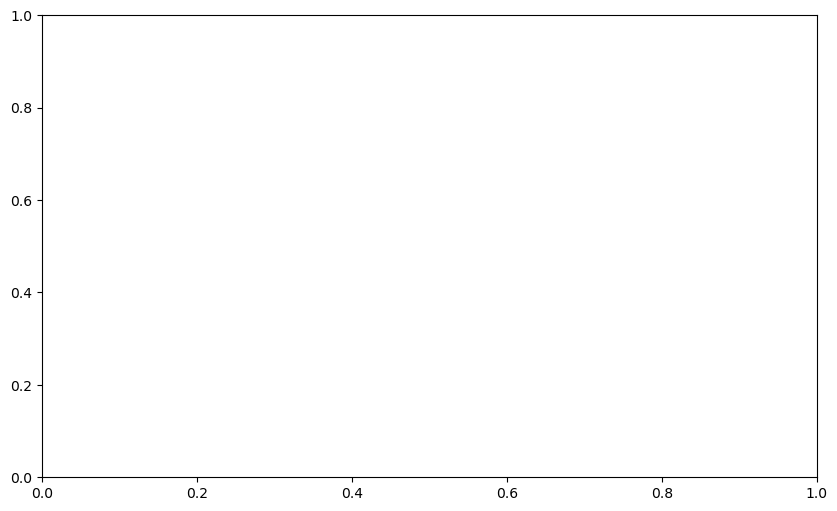

In [ ]:
# Compute well counts per distance
distance_columns = [f"Well Count_{d}m" for d in distances]  # Adjust based on your column names
distance_sums = summary_table.groupby("Decade")[distance_columns].sum()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each distance as a separate line
for dist in distances:
    column_name = f"Well Count_{dist}m"
    if column_name in distance_sums.columns:  # Ensure column exists
        ax.plot(distance_sums.index, distance_sums[column_name], marker="o", linestyle="-", label=f"{dist}m")

# Labels and title
ax.set_xlabel("Time Period (Decade)")
ax.set_ylabel("Number of Well Measurements")
ax.set_title("Well Measurements Over Time by Distance")
ax.legend(title="Buffer Distance")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
